# Setup

In [88]:
# import packages
import os
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
from datetime import timedelta
from scipy.stats import chi2_contingency
import datetime as dt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import StratifiedKFold

In [89]:
# function to create download links
def create_download_link( df, title = "Download CSV file", filename = "data.csv"):
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

# Drug Exposures: Clopidogrel

In [90]:
# Codes
# prescription dispensed in pharmacy - 38000175
# inpatient adminstration - 38000180
# physician adminstered drug - 38000179
# prescription dispensed through mail orders - 38000176

In [91]:
# de section contains autogenerated code from All of Us concept sets
clopidogrel_3_sql = f"""
-- get drug exposures
with de as (
    SELECT    
        d_exposure.drug_concept_id,
        d_exposure.drug_exposure_start_date,
        d_exposure.drug_type_concept_id,
        d_exposure.VISIT_OCCURRENCE_ID as de_visit_occurrence,
        d_exposure.provider_id,
        d_exposure.days_supply,
        d_exposure.person_id,
        d_standard_concept.concept_name as drug_name
    from
        ( SELECT
            * 
        from
            `{os.environ["WORKSPACE_CDR"]}.drug_exposure` d_exposure 
        WHERE
            (
                drug_concept_id in  (
                    select
                        distinct ca.descendant_id 
                    from
                        `{os.environ["WORKSPACE_CDR"]}.cb_criteria_ancestor` ca 
                    join
                        (
                            select
                                distinct c.concept_id 
                            from
                                `{os.environ["WORKSPACE_CDR"]}.cb_criteria` c 
                            join
                                (
                                    select
                                        cast(cr.id as string) as id 
                                    from
                                        `{os.environ["WORKSPACE_CDR"]}.cb_criteria` cr 
                                    where
                                        domain_id = 'DRUG' 
                                        and is_standard = 1 
                                        and concept_id in (
                                            1322184
                                        ) 
                                        and is_selectable = 1
                                ) a 
                                    on (
                                        c.path like concat('%.',
                                    a.id,
                                    '.%') 
                                    or c.path like concat('%.',
                                    a.id)) 
                                where
                                    domain_id = 'DRUG' 
                                    and is_standard = 1 
                                    and is_selectable = 1
                                ) b 
                                    on (
                                        ca.ancestor_id = b.concept_id
                                    )
                            )
                        )
                ) d_exposure 
        LEFT JOIN
            `{os.environ["WORKSPACE_CDR"]}.concept` d_route 
                on d_exposure.ROUTE_CONCEPT_ID = d_route.CONCEPT_ID 
        LEFT JOIN
            `{os.environ["WORKSPACE_CDR"]}.concept` d_type 
                on d_exposure.drug_type_concept_id = d_type.CONCEPT_ID 
        left join
            `{os.environ["WORKSPACE_CDR"]}.concept` d_standard_concept 
                on d_exposure.DRUG_CONCEPT_ID = d_standard_concept.CONCEPT_ID 
        LEFT JOIN
            `{os.environ["WORKSPACE_CDR"]}.concept` d_source_concept 
                on d_exposure.DRUG_SOURCE_CONCEPT_ID = d_source_concept.CONCEPT_ID 
        left join
            `{os.environ["WORKSPACE_CDR"]}.visit_occurrence` v 
                on d_exposure.VISIT_OCCURRENCE_ID = v.VISIT_OCCURRENCE_ID 
        LEFT JOIN
            `{os.environ["WORKSPACE_CDR"]}.concept` d_visit 
                on v.VISIT_CONCEPT_ID = d_visit.CONCEPT_ID
),
drug_type_qualifier as (
    select * from de 
    where drug_type_concept_id in (38000175, 38000180, 38000179, 38000176)
),
-- qualifier that there must be at least one visit occurrence in 365 days before the index date
with_visit_before as (
    select de.person_id, drug_name, de.drug_exposure_start_date as index_date,
    max(vo.visit_start_date) as before_visit_start_date
    from drug_type_qualifier de
    join (
        select * from  `{os.environ["WORKSPACE_CDR"]}`.visit_occurrence
    ) vo
    on de.PERSON_ID = vo.person_id 
    and vo.visit_start_date between DATE_SUB(de.drug_exposure_start_date, INTERVAL 1 YEAR) 
    and DATE_SUB(de.drug_exposure_start_date, INTERVAL 1 DAY)
    group by person_id, drug_name, index_date
),
-- for all drug exposures that satisfy qualifier (visit in one year before), get earliest record
index_dates as (
    select person_id, index_date, drug_name, before_visit_start_date from 
    (
        select *, ROW_NUMBER() over (PARTITION BY person_id order by index_date asc) as time_order 
        from with_visit_before
    )
    where time_order = 1
),
-- for each patient, get last drug exposure for clopidogrel
-- will be used to calculate follow_up_end_date
with_last_dispensed as (
    select person_id, max(drug_exposure_start_date) as last_dispensed from drug_type_qualifier
    group by person_id
),
-- for each patient and last dispensed date, get list of drug_names and max days supply given for clopidogrel
with_days_supply as (
    select a.person_id, STRING_AGG(a.drug_name) as drug_names, b.last_dispensed, max(a.days_supply) as days_supply from drug_type_qualifier a
    join (
        select * from with_last_dispensed
    ) b
    on a.person_id = b.person_id and a.drug_exposure_start_date = b.last_dispensed
    group by person_id, last_dispensed
),
-- calculate follow up period from last dispensed and days_supply
with_follow_up_period as (
    select *, DATE_ADD(last_dispensed, INTERVAL days_supply DAY) as follow_up_end_date 
    from with_days_supply
),
-- add follow up period dataset to dataset of index dates
with_index_and_follow_up as (
    select a.person_id, a.drug_name, a.before_visit_start_date, 
    a.index_date, b.last_dispensed, b.days_supply as last_days_supply, b.follow_up_end_date,
    date_diff(b.follow_up_end_date , a.index_date, DAY) as follow_up_period
    from index_dates a 
    join (
        select * from with_follow_up_period
    ) b 
    on a.person_id = b.person_id
),
-- get visit afterwards
-- qualifier that there must be at least one visit occurrence after index date during follow up period
with_visit_afterwards as (
    select a.person_id, a.drug_name, a.before_visit_start_date, 
    a.index_date, a.last_dispensed, a.last_days_supply, 
    a.follow_up_end_date, a.follow_up_period,
    min(vo.visit_start_date) as visit_after 
    from with_index_and_follow_up a
    join (
        select * from  `{os.environ["WORKSPACE_CDR"]}`.visit_occurrence
    ) vo
    on a.person_id = vo.person_id 
    and vo.visit_start_date between DATE_ADD(a.index_date, INTERVAL 1 DAY)
    and a.follow_up_end_date
    group by a.person_id, a.drug_name, a.before_visit_start_date, 
    a.index_date, a.last_dispensed, a.follow_up_period, a.last_days_supply, 
    a.follow_up_end_date
    
),
-- get all drug exposures of clopidogrel
with_all_dispensing_records as (
    select a.*, b.drug_exposure_start_date, b.days_supply from with_visit_afterwards a
    join (
        select * from drug_type_qualifier
    ) b
    on a.person_id = b.person_id and b.drug_exposure_start_date between a.index_date and a.follow_up_end_date
   -- order by person_id, index_date asc, drug_exposure_start_date asc
),
-- calculate days between previous dispensing record (using drug_exposure_start_date)
with_days_bw_records as (
    select *,
    case 
        when previous_record is not null then DATE_DIFF(drug_exposure_start_date, previous_record, DAY)
        else 0
    end as time_since_previous_record
    from (
        select *,
        lag(drug_exposure_start_date) over 
        (partition by person_id order by drug_exposure_start_date) as previous_record
        from with_all_dispensing_records
    )
),
-- get average days between drug exposures
with_avg_days_bw as (
    select person_id, drug_name, before_visit_start_date, index_date, last_dispensed, 
    last_days_supply, follow_up_end_date, follow_up_period, visit_after,
    avg(time_since_previous_record) as avg_days_bw_records, count(*) as dispensed_count, avg(days_supply) as avg_days_supply
    from with_days_bw_records
    group by person_id, drug_name, before_visit_start_date, index_date, last_dispensed, 
    last_days_supply, follow_up_end_date, follow_up_period, visit_after
),
-- add person info concept ids
with_person_info as (
    select a.*, gender_concept_id, year_of_birth, month_of_birth, day_of_birth, birth_datetime, 
    race_concept_id, ethnicity_concept_id, location_id, provider_id, care_site_id, 
    person_source_value, gender_source_value, gender_source_concept_id, race_source_value, 
    race_source_concept_id, ethnicity_source_value, ethnicity_source_concept_id, 
    sex_at_birth_concept_id, sex_at_birth_source_concept_id, 
    sex_at_birth_source_value,
     from with_avg_days_bw a
    inner join 
    ( 
        select * from `{os.environ["WORKSPACE_CDR"]}`.person
    ) b
    on a.person_id = b.person_id
),
-- add concept names for person info
 with_concept_names as (
    select person.*, 
    p_race_concept.concept_name as race,
    p_gender_concept.concept_name as gender,
    p_ethnicity_concept.concept_name as ethnicity,
    p_sex_at_birth_concept.concept_name as sex_at_birth 
    from with_person_info person
    LEFT JOIN
        {os.environ["WORKSPACE_CDR"]}.concept p_race_concept 
            on person.race_concept_id = p_race_concept.CONCEPT_ID 
    LEFT JOIN
        {os.environ["WORKSPACE_CDR"]}.concept p_gender_concept 
            on person.gender_concept_id = p_gender_concept.CONCEPT_ID 
    LEFT JOIN
        {os.environ["WORKSPACE_CDR"]}.concept p_ethnicity_concept 
            on person.ethnicity_concept_id = p_ethnicity_concept.CONCEPT_ID 
    LEFT JOIN
         {os.environ["WORKSPACE_CDR"]}.concept p_sex_at_birth_concept 
            on person.sex_at_birth_concept_id = p_sex_at_birth_concept.CONCEPT_ID
)
select * from with_concept_names 
"""
clopidogrel_3 = pd.read_gbq(clopidogrel_3_sql, dialect="standard")

In [92]:
clopidogrel_3['person_id']

0       1916421
1       1346402
2       2695051
3       3332553
4       3109285
         ...   
1902    3113739
1903    1654395
1904    1460951
1905    2285111
1906    1685356
Name: person_id, Length: 1907, dtype: int64

In [93]:
clopidogrel_3.head(3)

,person_id,drug_name,before_visit_start_date,index_date,last_dispensed,last_days_supply,follow_up_end_date,follow_up_period,visit_after,avg_days_bw_records,...,race_source_concept_id,ethnicity_source_value,ethnicity_source_concept_id,sex_at_birth_concept_id,sex_at_birth_source_concept_id,sex_at_birth_source_value,race,gender,ethnicity,sex_at_birth
0,1916421,clopidogrel 75 MG Oral Tablet,2016-02-15,2016-02-17,2016-03-01,13,2016-03-14,26,2016-03-13,4.333333,...,2000000008,No matching concept,0,45878463,1585847,SexAtBirth_Female,More than one population,Female,Not Hispanic or Latino,Female
1,1346402,clopidogrel 75 MG Oral Tablet,2018-06-02,2018-06-04,2018-12-18,90,2019-03-18,287,2018-06-18,32.833333,...,2000000008,No matching concept,0,45878463,1585847,SexAtBirth_Female,More than one population,Female,Not Hispanic or Latino,Female
2,2695051,clopidogrel 75 MG Oral Tablet,2018-08-30,2018-09-05,2019-08-17,30,2019-09-16,376,2018-10-17,26.615385,...,2000000008,No matching concept,0,45878463,1585847,SexAtBirth_Female,More than one population,Female,Not Hispanic or Latino,Female


In [94]:
# get care site ids for patients
care_sites_3_sql = f"""
with de as (
    SELECT
        d_exposure.drug_concept_id,
        d_exposure.drug_exposure_start_date,
        d_exposure.drug_type_concept_id,
        d_exposure.VISIT_OCCURRENCE_ID as de_visit_occurrence,
        d_exposure.provider_id,
        d_exposure.days_supply,
        d_exposure.person_id,
        d_type.concept_name as DRUG_TYPE_CONCEPT_NAME,
        d_standard_concept.concept_name as drug_name,
        v_ext.*
    from
        ( SELECT
            * 
        from
            `{os.environ["WORKSPACE_CDR"]}.drug_exposure` d_exposure 
        WHERE
            (
                drug_concept_id in  (
                    select
                        distinct ca.descendant_id 
                    from
                        `{os.environ["WORKSPACE_CDR"]}.cb_criteria_ancestor` ca 
                    join
                        (
                            select
                                distinct c.concept_id 
                            from
                                `{os.environ["WORKSPACE_CDR"]}.cb_criteria` c 
                            join
                                (
                                    select
                                        cast(cr.id as string) as id 
                                    from
                                        `{os.environ["WORKSPACE_CDR"]}.cb_criteria` cr 
                                    where
                                        domain_id = 'DRUG' 
                                        and is_standard = 1 
                                        and concept_id in (
                                            1322184
                                        ) 
                                        and is_selectable = 1
                                ) a 
                                    on (
                                        c.path like concat('%.',
                                    a.id,
                                    '.%') 
                                    or c.path like concat('%.',
                                    a.id)) 
                                where
                                    domain_id = 'DRUG' 
                                    and is_standard = 1 
                                    and is_selectable = 1
                                ) b 
                                    on (
                                        ca.ancestor_id = b.concept_id
                                    )
                            )
                        )
                ) d_exposure 
        LEFT JOIN
            `{os.environ["WORKSPACE_CDR"]}.concept` d_route 
                on d_exposure.ROUTE_CONCEPT_ID = d_route.CONCEPT_ID 
        LEFT JOIN
            `{os.environ["WORKSPACE_CDR"]}.concept` d_type 
                on d_exposure.drug_type_concept_id = d_type.CONCEPT_ID 
        left join
            `{os.environ["WORKSPACE_CDR"]}.concept` d_standard_concept 
                on d_exposure.DRUG_CONCEPT_ID = d_standard_concept.CONCEPT_ID 
        LEFT JOIN
            `{os.environ["WORKSPACE_CDR"]}.concept` d_source_concept 
                on d_exposure.DRUG_SOURCE_CONCEPT_ID = d_source_concept.CONCEPT_ID 
        left join
            `{os.environ["WORKSPACE_CDR"]}.visit_occurrence` v 
                on d_exposure.VISIT_OCCURRENCE_ID = v.VISIT_OCCURRENCE_ID 
        left join
            `{os.environ["WORKSPACE_CDR"]}.visit_occurrence_ext` v_ext 
                on d_exposure.VISIT_OCCURRENCE_ID = v_ext.VISIT_OCCURRENCE_ID 
        LEFT JOIN
            `{os.environ["WORKSPACE_CDR"]}.concept` d_visit 
                on v.VISIT_CONCEPT_ID = d_visit.CONCEPT_ID
        LEFT JOIN
            `{os.environ["WORKSPACE_CDR"]}.person` d_person 
                on v.person_id = d_person.person_id
),
drug_type_qualifier as (
    select * from de 
    where drug_type_concept_id in (38000175, 38000180, 38000179, 38000176)
),
group_by_person as (
    select person_id, src_id from drug_type_qualifier
    group by person_id, src_id
),
agg_care_sites as (
    select person_id, string_agg(src_id) as care_sites from group_by_person
    group by person_id
)

select * from agg_care_sites
"""
care_sites_3 = pd.read_gbq(care_sites_3_sql, dialect="standard")


In [95]:
care_sites_3

,person_id,care_sites
0,1305154,None
1,2110337,None
2,1163906,None
3,2592209,None
4,1896013,None
...,...,...
3934,1071023,EHR site 752
3935,2001515,EHR site 250
3936,1583188,EHR site 588
3937,1386842,EHR site 559


In [96]:
# join clopidogrel drug exposures with care sites for patients
clopidogrel_3 = pd.merge(clopidogrel_3, care_sites_3, on="person_id", how="left")

In [97]:
# download clopidogrel drug exposures
create_download_link(clopidogrel_3, 'clopidogrel 3 ', 'clopidogrel_3.csv')

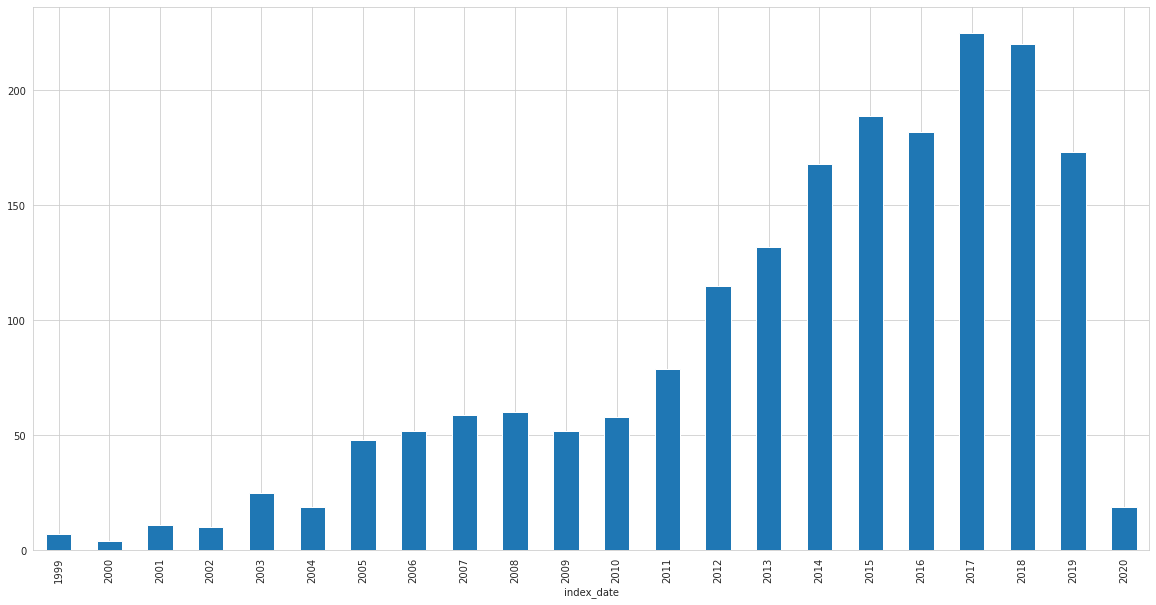

In [98]:
clopidogrel_3["index_date"].groupby([clopidogrel_3["index_date"].dt.year]).count().plot(
    kind="bar",
    figsize=(20,10)
)
plt.show()

# Incident Cohort

## Condition 1 Incidents
<b>Gastrointestinal Bleeding</b> <br> <br>
Description: Gastrointestinal bleeding events, defined by condition occurrences of Gastrointestinal hemorrhage GI bleeding conceptset occurring between start and end of inpatient or ER visit

In [99]:
# SQL for getting gastrointestinal hemorrhage conditions
# NOTE: source codes (ICD9 and ICD10) should be under condition_source_concept_id
# but there is an error in the database where it sometimes gets coded under condition_status_concept_id
# my solution has been to pull both columns
# use condition_source by default, but if its coded under condition_status, use that instead

cond1_codes = [ #SNOMED CODES
4138962, 4195231, 4147683, 4163865, 195584, 40482685, 28779, 4222896, 4296611, 200769, 4177387, 434400, 438795,
4204555, 24973, 23808, 2002608, 198798, 4198381, 4209746, 4112183, 2108900, 2108878, 4265600, 4248429, 192671,
4101104, 443530, 197925, 4027663, 4291028]
insert_cond1_sql0 = ",".join([f"('{x}')" for x in cond1_codes])
gi_incident_sql = f"""
-- temp SQL table for condition codes for faster lookup using join
CREATE TEMP TABLE temp
(
  condition_codes STRING
);
INSERT INTO temp (
    condition_codes
)
VALUES {insert_cond1_sql0};

-- create official table with correct integer cast
CREATE TEMP TABLE search_codes (
    condition_codes INT64
);

INSERT INTO search_codes
SELECT CAST(condition_codes as INT64) as condition_codes FROM temp;

SELECT * FROM search_codes;
        
-- get all condition occurrences with condition_status and condition_source
with co as (
    select condition_concept.concept_name as condition_name,
    condition_status.concept_name as condition_status_name,
    condition_status.concept_code as condition_status_code,
    condition_status.vocabulary_id as condition_status_vocabulary,
    condition_source.concept_name as condition_source_name,
    condition_source.concept_code as condition_source_code,
    condition_source.vocabulary_id as condition_source_vocabulary,
    a.person_id as person_id,
    a.condition_concept_id, 
    a.condition_start_date, 
    a.condition_end_date, 
    a.condition_type_concept_id, 
    a.visit_occurrence_id, 
    v.visit_occurrence_id as visit_occurrence_id_1, 
    v.person_id as person_id_1, 
    v.visit_concept_id,
    v.visit_start_date, 
    v.visit_start_datetime, 
    v.visit_end_date, 
    v.visit_end_datetime, 
    v.visit_type_concept_id, 
    v.visit_source_value, 
    v.visit_source_concept_id, 
    v.admitting_source_concept_id, 
    v.admitting_source_value, 
    v.discharge_to_concept_id, 
    v.discharge_to_source_value, 
    v.preceding_visit_occurrence_id,
    a.condition_source_concept_id,
    a.condition_status_concept_id
    from {os.environ["WORKSPACE_CDR"]}.condition_occurrence a
         
    LEFT JOIN
        {os.environ["WORKSPACE_CDR"]}.concept condition_concept 
        on a.condition_concept_id = condition_concept.concept_id   
    LEFT JOIN
        {os.environ["WORKSPACE_CDR"]}.concept condition_status
        on a.condition_status_concept_id = condition_status.concept_id 
    LEFT JOIN
        {os.environ["WORKSPACE_CDR"]}.concept condition_source
        on a.condition_source_concept_id = condition_source.concept_id 
    LEFT JOIN
        {os.environ["WORKSPACE_CDR"]}.visit_occurrence v
        on a.visit_occurrence_id = v.visit_occurrence_id
    where 
    (condition_status_concept_id is not null or 
    condition_source_concept_id is not null)
    and (condition_status_concept_id != 0 or 
    condition_source_concept_id != 0)
    --limit 100
),

-- combine status and source columns, refer to notes at top of this section
combine_status_and_source as (
    select
    person_id,
    condition_name, 
    condition_concept_id, 
    condition_start_date, 
    condition_end_date, 
    condition_type_concept_id, 
    visit_occurrence_id, 
    
    CASE
        when (condition_source_concept_id is null or condition_source_concept_id = 0)
        then condition_status_concept_id
        else condition_source_concept_id
    END as source_concept_id,
    CASE
        when (condition_source_concept_id is null or condition_source_concept_id = 0)
        then condition_status_name
        else condition_source_name
    END as source_name,
    CASE
        when (condition_source_concept_id is null or condition_source_concept_id = 0)
        then condition_status_code
        else condition_source_code
    END as source_code,
    CASE
        when (condition_source_concept_id is null or condition_source_concept_id = 0)
        then condition_status_vocabulary
        else condition_source_vocabulary
    END as source_vocab,
    
    visit_occurrence_id_1, 
    person_id_1, 
    visit_concept_id, 
    visit_start_date, 
    visit_start_datetime, 
    visit_end_date, 
    visit_end_datetime, 
    visit_type_concept_id, 
    visit_source_value, 
    visit_source_concept_id, 
    admitting_source_concept_id, 
    admitting_source_value, 
    discharge_to_concept_id, 
    discharge_to_source_value, 
    preceding_visit_occurrence_id
from co
),
-- use inner join to get only conditions that we care about
target_conditions as (
    select distinct a.* from combine_status_and_source a
    inner join search_codes
    on a.condition_concept_id = search_codes.condition_codes
)
select * from target_conditions;
"""

"""
-- get earliest condition_occurrence per patient for incident coohort
-- not using right now, because we want to keep all condition_occurrences 
-- in case earliest one doesn't fall after drug exposure
incidence_cohort as (
    select person_id, condition_name, condition_concept_id, condition_start_date, condition_end_date, 
    visit_occurrence_id, condition_type_concept_id, source_concept_id, source_name, source_code, 
    source_vocab from 
        (
            select *, ROW_NUMBER() over (PARTITION BY person_id order by condition_start_date asc) as time_order 
            from target_conditions
        )
        where time_order = 1
)
select * from target_conditions 
"""
gi_cond1 = pd.read_gbq(gi_incident_sql, dialect="standard")

In [100]:
gi_cond1

,person_id,condition_name,condition_concept_id,condition_start_date,condition_end_date,condition_type_concept_id,visit_occurrence_id,source_concept_id,source_name,source_code,...,visit_end_date,visit_end_datetime,visit_type_concept_id,visit_source_value,visit_source_concept_id,admitting_source_concept_id,admitting_source_value,discharge_to_concept_id,discharge_to_source_value,preceding_visit_occurrence_id
0,1129388,Gastric ulcer,4265600,2019-01-22,2019-01-22,0,3.700000e+16,44837160,"Gastric ulcer, unspecified as acute or chronic...",531.9,...,2019-01-25,2019-01-25 13:56:00+00:00,44818518.0,IP,9201.0,42627881.0,1021883,0.0,No matching concept,0.0
1,2760070,"Chronic peptic ulcer without hemorrhage, witho...",23808,2009-11-12,2009-11-16,44786629,1.500000e+16,44832457,Chronic peptic ulcer of unspecified site witho...,533.70,...,2009-11-16,2009-11-16 00:00:00+00:00,44818518.0,None,NaN,NaN,None,NaN,None,NaN
2,1537963,Peptic ulcer,4027663,2004-02-25,2004-02-25,0,1.500000e+16,1569564,"Peptic ulcer, site unspecified",K27,...,2004-02-25,2004-02-25 00:00:00+00:00,44818518.0,None,NaN,NaN,None,NaN,None,NaN
3,3164802,Bleeding esophageal varices,28779,2018-10-20,NaT,0,1.600000e+16,45538463,Esophageal varices with bleeding,I85.01,...,NaT,NaT,NaN,None,NaN,NaN,None,NaN,None,NaN
4,1061693,Gastric ulcer,4265600,2013-08-25,NaT,44786627,1.300000e+16,4265600,Gastric ulcer,397825006,...,2013-08-25,2013-08-25 00:00:00+00:00,44818518.0,OP,9202.0,NaN,None,NaN,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85897,1033242,Hematochezia,443530,2016-02-02,2016-02-02,32020,1.700000e+16,443530,Hematochezia,405729008,...,2016-02-02,2016-02-02 06:00:00+00:00,44818518.0,None,NaN,0.0,No matching concept,0.0,No matching concept,NaN
85898,2260063,Hematochezia,443530,1995-05-21,1995-05-21,32020,1.700000e+16,443530,Hematochezia,405729008,...,1995-05-21,1995-05-21 06:00:00+00:00,44818518.0,None,NaN,0.0,No matching concept,0.0,No matching concept,NaN
85899,1883347,Hematochezia,443530,2017-11-02,2017-11-02,32020,1.700000e+16,443530,Hematochezia,405729008,...,2017-11-02,2017-11-02 06:00:00+00:00,44818518.0,OP,9202.0,0.0,No matching concept,0.0,No matching concept,NaN
85900,1440258,Hematochezia,443530,2008-01-02,2008-01-02,32020,1.700000e+16,443530,Hematochezia,405729008,...,2008-01-02,2008-01-02 06:00:00+00:00,44818518.0,OP,9202.0,0.0,No matching concept,0.0,No matching concept,NaN


## Condition 2 Incidents
<b>Gastrointestinal Hemorrhage</b>
Description: Gastrointestinal hemorrhage by Siontis Circulation, 2018

In [101]:
# SQL for getting gastrointestinal hemorrhage conditions
# NOTE: source codes (ICD9 and ICD10) should be under condition_source_concept_id
# but there is an error in the database where it sometimes gets coded under condition_status_concept_id
# my solution has been to pull both columns
# use condition_source by default, but if its coded under condition_status, use that instead


cond2_codes = [46273183, 46270529, 46270145, 46270025, 46269911, 46269907, 46269901, 45757783, 
    45757654, 45757543, 4336230, 4294973, 4291649, 4289830, 4274491, 4247008, 4232181, 
    4231580, 4217947, 4211001, 4174044, 4169592, 4164920, 4112183, 4103703, 4046500, 
    4031954, 4027729, 4006994, 443779, 443530, 442314, 442190, 441328, 441063, 441062, 
    440756, 438796, 438468, 437326, 437323, 437027, 437021, 436729, 436148, 435855, 
    434402, 433515, 316457, 201885, 199855, 198801, 198798, 198467, 197925, 197018, 
    196442, 195845, 194986, 193795, 193250, 193249, 192671, 31335, 30770, 28779, 27026, 
    26727, 26441, 24397, 24076, 23245, 23237, 22665]
insert_cond2_sql0 = ",".join([f"('{x}')" for x in cond2_codes])
gi_incident_sql = f"""
-- temp SQL table for condition codes for faster lookup using join
CREATE TEMP TABLE temp
(
  condition_codes STRING
);
INSERT INTO temp (
    condition_codes
)
VALUES {insert_cond2_sql0};

-- create official table with correct integer cast
CREATE TEMP TABLE search_codes (
    condition_codes INT64
);

INSERT INTO search_codes
SELECT CAST(condition_codes as INT64) as condition_codes FROM temp;

SELECT * FROM search_codes;
        
-- get all condition occurrences with condition_status and condition_source
with co as (
    select condition_concept.concept_name as condition_name,
    condition_status.concept_name as condition_status_name,
    condition_status.concept_code as condition_status_code,
    condition_status.vocabulary_id as condition_status_vocabulary,
    condition_source.concept_name as condition_source_name,
    condition_source.concept_code as condition_source_code,
    condition_source.vocabulary_id as condition_source_vocabulary,
    a.person_id as person_id,
    a.condition_concept_id, 
    a.condition_start_date, 
    a.condition_end_date, 
    a.condition_type_concept_id, 
    a.visit_occurrence_id, 
    v.visit_occurrence_id as visit_occurrence_id_1, 
    v.person_id as person_id_1, 
    v.visit_concept_id,
    v.visit_start_date, 
    v.visit_start_datetime, 
    v.visit_end_date, 
    v.visit_end_datetime, 
    v.visit_type_concept_id, 
    v.visit_source_value, 
    v.visit_source_concept_id, 
    v.admitting_source_concept_id, 
    v.admitting_source_value, 
    v.discharge_to_concept_id, 
    v.discharge_to_source_value, 
    v.preceding_visit_occurrence_id,
    a.condition_source_concept_id,
    a.condition_status_concept_id
    from {os.environ["WORKSPACE_CDR"]}.condition_occurrence a
         
    LEFT JOIN
        {os.environ["WORKSPACE_CDR"]}.concept condition_concept 
        on a.condition_concept_id = condition_concept.concept_id   
    LEFT JOIN
        {os.environ["WORKSPACE_CDR"]}.concept condition_status
        on a.condition_status_concept_id = condition_status.concept_id 
    LEFT JOIN
        {os.environ["WORKSPACE_CDR"]}.concept condition_source
        on a.condition_source_concept_id = condition_source.concept_id 
    LEFT JOIN
        {os.environ["WORKSPACE_CDR"]}.visit_occurrence v
        on a.visit_occurrence_id = v.visit_occurrence_id
    where 
    (condition_status_concept_id is not null or 
    condition_source_concept_id is not null)
    and (condition_status_concept_id != 0 or 
    condition_source_concept_id != 0)
    --limit 100
),

-- combine status and source columns, refer to notes at top of this section
combine_status_and_source as (
    select
    person_id,
    condition_name, 
    condition_concept_id, 
    condition_start_date, 
    condition_end_date, 
    condition_type_concept_id, 
    visit_occurrence_id, 
    
    CASE
        when (condition_source_concept_id is null or condition_source_concept_id = 0)
        then condition_status_concept_id
        else condition_source_concept_id
    END as source_concept_id,
    CASE
        when (condition_source_concept_id is null or condition_source_concept_id = 0)
        then condition_status_name
        else condition_source_name
    END as source_name,
    CASE
        when (condition_source_concept_id is null or condition_source_concept_id = 0)
        then condition_status_code
        else condition_source_code
    END as source_code,
    CASE
        when (condition_source_concept_id is null or condition_source_concept_id = 0)
        then condition_status_vocabulary
        else condition_source_vocabulary
    END as source_vocab,
    
    visit_occurrence_id_1, 
    person_id_1, 
    visit_concept_id, 
    visit_start_date, 
    visit_start_datetime, 
    visit_end_date, 
    visit_end_datetime, 
    visit_type_concept_id, 
    visit_source_value, 
    visit_source_concept_id, 
    admitting_source_concept_id, 
    admitting_source_value, 
    discharge_to_concept_id, 
    discharge_to_source_value, 
    preceding_visit_occurrence_id
from co
),
-- use inner join to get only conditions that we care about
target_conditions as (
    select distinct a.* from combine_status_and_source a
    inner join search_codes
    on a.condition_concept_id = search_codes.condition_codes
)
select * from target_conditions;
"""

"""
-- get earliest condition_occurrence per patient for incident coohort
-- not using right now, because we want to keep all condition_occurrences 
-- in case earliest one doesn't fall after drug exposure
incidence_cohort as (
    select person_id, condition_name, condition_concept_id, condition_start_date, condition_end_date, 
    visit_occurrence_id, condition_type_concept_id, source_concept_id, source_name, source_code, 
    source_vocab from 
        (
            select *, ROW_NUMBER() over (PARTITION BY person_id order by condition_start_date asc) as time_order 
            from target_conditions
        )
        where time_order = 1
)
select * from target_conditions 
"""
gi_cond2 = pd.read_gbq(gi_incident_sql, dialect="standard")

In [102]:
gi_cond2.where(gi_cond2['condition_concept_id'] == 192671.0).dropna()

,person_id,condition_name,condition_concept_id,condition_start_date,condition_end_date,condition_type_concept_id,visit_occurrence_id,source_concept_id,source_name,source_code,...,visit_end_date,visit_end_datetime,visit_type_concept_id,visit_source_value,visit_source_concept_id,admitting_source_concept_id,admitting_source_value,discharge_to_concept_id,discharge_to_source_value,preceding_visit_occurrence_id
36765,1047321.0,Gastrointestinal hemorrhage,192671.0,2013-06-21,2013-06-21,0.0,3.700000e+16,44819812.0,"Hemorrhage of gastrointestinal tract, unspecified",578.9,...,2013-06-21,2013-06-21 00:00:00+00:00,44818518.0,OMOP4822458,581477.0,0.0,No matching concept,0.0,No matching concept,0.0
36801,1317524.0,Gastrointestinal hemorrhage,192671.0,2012-09-30,2012-09-30,0.0,2.600000e+16,44819812.0,"Hemorrhage of gastrointestinal tract, unspecified",578.9,...,2012-10-02,2012-10-02 13:00:00+00:00,44818518.0,No matching concept,0.0,8717.0,21,8536.0,12,0.0
36807,1315692.0,Gastrointestinal hemorrhage,192671.0,2014-09-07,2014-09-07,0.0,3.700000e+16,44819812.0,"Hemorrhage of gastrointestinal tract, unspecified",578.9,...,2014-09-07,2014-09-07 00:00:00+00:00,44818518.0,OMOP4822458,581477.0,0.0,No matching concept,0.0,No matching concept,0.0
36859,1364936.0,Gastrointestinal hemorrhage,192671.0,2015-04-21,2015-04-21,32020.0,4.500000e+16,44819812.0,"Hemorrhage of gastrointestinal tract, unspecified",578.9,...,2015-04-21,2015-04-21 00:00:00+00:00,44818518.0,ER,9203.0,8870.0,23,8536.0,12,0.0
36864,3127601.0,Gastrointestinal hemorrhage,192671.0,2017-01-04,2017-01-04,0.0,3.700000e+16,44819812.0,"Hemorrhage of gastrointestinal tract, unspecified",578.9,...,2017-01-04,2017-01-04 14:10:00+00:00,44818518.0,OP,9202.0,4119839.0,257585005,0.0,No matching concept,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94859,2080671.0,Gastrointestinal hemorrhage,192671.0,2018-01-04,2018-01-04,0.0,2.600000e+16,35208414.0,"Gastrointestinal hemorrhage, unspecified",K92.2,...,2018-01-04,2018-01-04 00:00:00+00:00,44818518.0,No matching concept,0.0,0.0,No matching concept,0.0,No matching concept,0.0
94869,3305977.0,Gastrointestinal hemorrhage,192671.0,2017-05-28,2017-06-20,32019.0,3.600000e+16,35208414.0,"Gastrointestinal hemorrhage, unspecified",K92.2,...,2017-06-20,2017-06-20 23:59:00+00:00,44818518.0,OP,9202.0,0.0,No matching concept,0.0,No matching concept,0.0
94873,2124606.0,Gastrointestinal hemorrhage,192671.0,2013-07-28,2013-07-28,0.0,4.100000e+16,35208414.0,"Gastrointestinal hemorrhage, unspecified",K92.2,...,2013-07-28,2013-07-28 21:40:00+00:00,44818518.0,OMOP4822458,581477.0,0.0,No matching concept,0.0,No matching concept,0.0
94909,1991805.0,Gastrointestinal hemorrhage,192671.0,2015-10-06,2015-10-06,0.0,2.600000e+16,35208414.0,"Gastrointestinal hemorrhage, unspecified",K92.2,...,2015-10-06,2015-10-06 00:00:00+00:00,44818518.0,No matching concept,0.0,0.0,No matching concept,0.0,No matching concept,0.0


In [103]:
gi_cond1.where(gi_cond1['condition_concept_id'] == 192671.0).dropna()

,person_id,condition_name,condition_concept_id,condition_start_date,condition_end_date,condition_type_concept_id,visit_occurrence_id,source_concept_id,source_name,source_code,...,visit_end_date,visit_end_datetime,visit_type_concept_id,visit_source_value,visit_source_concept_id,admitting_source_concept_id,admitting_source_value,discharge_to_concept_id,discharge_to_source_value,preceding_visit_occurrence_id
30972,1170496.0,Gastrointestinal hemorrhage,192671.0,2007-12-23,2007-12-23,32019.0,3.600000e+16,44819812.0,"Hemorrhage of gastrointestinal tract, unspecified",578.9,...,2007-12-23,2007-12-23 16:49:00+00:00,44818518.0,ER,9203.0,0.0,No matching concept,0.0,No matching concept,0.0
30980,1831101.0,Gastrointestinal hemorrhage,192671.0,2013-05-18,2013-05-18,0.0,2.600000e+16,44819812.0,"Hemorrhage of gastrointestinal tract, unspecified",578.9,...,2013-05-18,2013-05-18 00:00:00+00:00,44818518.0,No matching concept,0.0,0.0,No matching concept,0.0,No matching concept,0.0
31055,1883546.0,Gastrointestinal hemorrhage,192671.0,2012-10-08,2012-10-08,38000245.0,8.000000e+15,44819812.0,"Hemorrhage of gastrointestinal tract, unspecified",578.9,...,2012-10-08,2012-10-08 11:00:00+00:00,44818518.0,No matching concept,0.0,0.0,No matching concept,0.0,No matching concept,0.0
31062,1047321.0,Gastrointestinal hemorrhage,192671.0,2017-12-12,2017-12-12,0.0,3.700000e+16,44819812.0,"Hemorrhage of gastrointestinal tract, unspecified",578.9,...,2017-12-12,2017-12-12 00:00:00+00:00,44818518.0,OMOP4822458,581477.0,0.0,No matching concept,0.0,No matching concept,0.0
31078,1044723.0,Gastrointestinal hemorrhage,192671.0,2018-08-06,2018-08-06,0.0,3.700000e+16,44819812.0,"Hemorrhage of gastrointestinal tract, unspecified",578.9,...,2018-08-11,2018-08-11 16:00:00+00:00,44818518.0,IP,9201.0,4214465.0,39350007,0.0,No matching concept,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82194,2932830.0,Gastrointestinal hemorrhage,192671.0,2019-08-02,2019-08-02,44786629.0,4.000000e+15,35208414.0,"Gastrointestinal hemorrhage, unspecified",K92.2,...,2019-08-02,2019-08-02 00:00:00+00:00,44818518.0,No matching concept,0.0,0.0,No matching concept,0.0,No matching concept,28251.0
82196,3274209.0,Gastrointestinal hemorrhage,192671.0,2016-11-29,2016-11-29,0.0,4.100000e+16,35208414.0,"Gastrointestinal hemorrhage, unspecified",K92.2,...,2016-11-29,2016-11-29 07:00:00+00:00,44818518.0,IP,9201.0,0.0,No matching concept,0.0,No matching concept,0.0
82225,2011821.0,Gastrointestinal hemorrhage,192671.0,2017-08-30,2017-08-30,38000245.0,8.000000e+15,35208414.0,"Gastrointestinal hemorrhage, unspecified",K92.2,...,2017-08-30,2017-08-30 14:35:00+00:00,44818518.0,No matching concept,0.0,0.0,No matching concept,0.0,No matching concept,0.0
82265,1810815.0,Gastrointestinal hemorrhage,192671.0,2014-06-19,2014-06-28,0.0,4.100000e+16,35208414.0,"Gastrointestinal hemorrhage, unspecified",K92.2,...,2014-06-28,2014-06-28 09:58:00+00:00,44818518.0,ER,9203.0,9203.0,ER,0.0,No matching concept,0.0


## Condition 3 Incidents
<b>Intracranial Hemorrhage</b> <br> <br>
Description: Hemorrhagic stroke events, defined by condition occurrences of intracranial bleed Hemorrhagic stroke conceptset occurring between start and end of inpatient or ER visit

In [104]:
# SQL for getting gastrointestinal hemorrhage conditions
# NOTE: source codes (ICD9 and ICD10) should be under condition_source_concept_id
# but there is an error in the database where it sometimes gets coded under condition_status_concept_id
# my solution has been to pull both columns
# use condition_source by default, but if its coded under condition_status, use that instead

cond3_codes = [ #SNOMED CODES
376713, 439847, 432923, 43530727, 4148906, 43530674, 42535425]
insert_cond3_sql0 = ",".join([f"('{x}')" for x in cond3_codes])
gi_incident_sql = f"""
-- temp SQL table for condition codes for faster lookup using join
CREATE TEMP TABLE temp
(
  condition_codes STRING
);
INSERT INTO temp (
    condition_codes
)
VALUES {insert_cond3_sql0};

-- create official table with correct integer cast
CREATE TEMP TABLE search_codes (
    condition_codes INT64
);

INSERT INTO search_codes
SELECT CAST(condition_codes as INT64) as condition_codes FROM temp;

SELECT * FROM search_codes;
        
-- get all condition occurrences with condition_status and condition_source
with co as (
    select condition_concept.concept_name as condition_name,
    condition_status.concept_name as condition_status_name,
    condition_status.concept_code as condition_status_code,
    condition_status.vocabulary_id as condition_status_vocabulary,
    condition_source.concept_name as condition_source_name,
    condition_source.concept_code as condition_source_code,
    condition_source.vocabulary_id as condition_source_vocabulary,
    a.person_id as person_id,
    a.condition_concept_id, 
    a.condition_start_date, 
    a.condition_end_date, 
    a.condition_type_concept_id, 
    a.visit_occurrence_id, 
    v.visit_occurrence_id as visit_occurrence_id_1, 
    v.person_id as person_id_1, 
    v.visit_concept_id,
    v.visit_start_date, 
    v.visit_start_datetime, 
    v.visit_end_date, 
    v.visit_end_datetime, 
    v.visit_type_concept_id, 
    v.visit_source_value, 
    v.visit_source_concept_id, 
    v.admitting_source_concept_id, 
    v.admitting_source_value, 
    v.discharge_to_concept_id, 
    v.discharge_to_source_value, 
    v.preceding_visit_occurrence_id,
    a.condition_source_concept_id,
    a.condition_status_concept_id
    from {os.environ["WORKSPACE_CDR"]}.condition_occurrence a
         
    LEFT JOIN
        {os.environ["WORKSPACE_CDR"]}.concept condition_concept 
        on a.condition_concept_id = condition_concept.concept_id   
    LEFT JOIN
        {os.environ["WORKSPACE_CDR"]}.concept condition_status
        on a.condition_status_concept_id = condition_status.concept_id 
    LEFT JOIN
        {os.environ["WORKSPACE_CDR"]}.concept condition_source
        on a.condition_source_concept_id = condition_source.concept_id 
    LEFT JOIN
        {os.environ["WORKSPACE_CDR"]}.visit_occurrence v
        on a.visit_occurrence_id = v.visit_occurrence_id
    where 
    (condition_status_concept_id is not null or 
    condition_source_concept_id is not null)
    and (condition_status_concept_id != 0 or 
    condition_source_concept_id != 0)
    --limit 100
),

-- combine status and source columns, refer to notes at top of this section
combine_status_and_source as (
    select
    person_id,
    condition_name, 
    condition_concept_id, 
    condition_start_date, 
    condition_end_date, 
    condition_type_concept_id, 
    visit_occurrence_id, 
    
    CASE
        when (condition_source_concept_id is null or condition_source_concept_id = 0)
        then condition_status_concept_id
        else condition_source_concept_id
    END as source_concept_id,
    CASE
        when (condition_source_concept_id is null or condition_source_concept_id = 0)
        then condition_status_name
        else condition_source_name
    END as source_name,
    CASE
        when (condition_source_concept_id is null or condition_source_concept_id = 0)
        then condition_status_code
        else condition_source_code
    END as source_code,
    CASE
        when (condition_source_concept_id is null or condition_source_concept_id = 0)
        then condition_status_vocabulary
        else condition_source_vocabulary
    END as source_vocab,
    
    visit_occurrence_id_1, 
    person_id_1, 
    visit_concept_id, 
    visit_start_date, 
    visit_start_datetime, 
    visit_end_date, 
    visit_end_datetime, 
    visit_type_concept_id, 
    visit_source_value, 
    visit_source_concept_id, 
    admitting_source_concept_id, 
    admitting_source_value, 
    discharge_to_concept_id, 
    discharge_to_source_value, 
    preceding_visit_occurrence_id
from co
),
-- use inner join to get only conditions that we care about
target_conditions as (
    select distinct a.* from combine_status_and_source a
    inner join search_codes
    on a.condition_concept_id = search_codes.condition_codes
)
select * from target_conditions;
"""

"""
-- get earliest condition_occurrence per patient for incident coohort
-- not using right now, because we want to keep all condition_occurrences 
-- in case earliest one doesn't fall after drug exposure
incidence_cohort as (
    select person_id, condition_name, condition_concept_id, condition_start_date, condition_end_date, 
    visit_occurrence_id, condition_type_concept_id, source_concept_id, source_name, source_code, 
    source_vocab from 
        (
            select *, ROW_NUMBER() over (PARTITION BY person_id order by condition_start_date asc) as time_order 
            from target_conditions
        )
        where time_order = 1
)
select * from target_conditions 
"""
gi_cond3 = pd.read_gbq(gi_incident_sql, dialect="standard")

In [105]:
gi_cond3[gi_cond3["condition_concept_id"] == 439847]

,person_id,condition_name,condition_concept_id,condition_start_date,condition_end_date,condition_type_concept_id,visit_occurrence_id,source_concept_id,source_name,source_code,...,visit_end_date,visit_end_datetime,visit_type_concept_id,visit_source_value,visit_source_concept_id,admitting_source_concept_id,admitting_source_value,discharge_to_concept_id,discharge_to_source_value,preceding_visit_occurrence_id
321,1999068,Intracranial hemorrhage,439847,2019-12-05,NaT,32020,1.800000e+16,44826644,Unspecified intracranial hemorrhage,432.9,...,2019-12-19,2019-12-19 10:44:00+00:00,44818518.0,None,NaN,NaN,None,NaN,None,NaN
322,3380965,Intracranial hemorrhage,439847,2019-08-11,2019-08-14,32020,1.700000e+16,44826644,Unspecified intracranial hemorrhage,432.9,...,2019-08-14,2019-08-14 20:18:00+00:00,44818518.0,IP,9201.0,0.0,No matching concept,0.0,No matching concept,NaN
323,2871842,Intracranial hemorrhage,439847,2013-04-03,NaT,0,3.800000e+16,44826644,Unspecified intracranial hemorrhage,432.9,...,2013-04-03,2013-04-03 13:11:00+00:00,44818518.0,No matching concept,0.0,44814653.0,Generic-UN,NaN,None,3.243048e+09
324,2871842,Intracranial hemorrhage,439847,2012-04-03,NaT,0,3.800000e+16,44826644,Unspecified intracranial hemorrhage,432.9,...,2012-04-03,2012-04-03 13:11:00+00:00,44818518.0,No matching concept,0.0,44814653.0,Generic-UN,NaN,None,3.229402e+09
325,1759281,Intracranial hemorrhage,439847,2018-12-24,2018-12-24,32020,1.700000e+16,44826644,Unspecified intracranial hemorrhage,432.9,...,2018-12-24,2018-12-24 06:00:00+00:00,44818518.0,OP,9202.0,0.0,No matching concept,0.0,No matching concept,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11811,2638080,Intracranial hemorrhage,439847,2018-06-11,NaT,38000245,1.900000e+16,35207818,"Nontraumatic intracranial hemorrhage, unspecified",I62.9,...,2018-06-16,2018-06-16 15:00:00+00:00,44818518.0,None,NaN,NaN,None,NaN,None,NaN
11843,2097673,Intracranial hemorrhage,439847,2020-01-29,NaT,32020,1.900000e+16,35207818,"Nontraumatic intracranial hemorrhage, unspecified",I62.9,...,2020-02-02,2020-02-02 18:10:00+00:00,44818518.0,None,NaN,NaN,None,NaN,None,NaN
11865,1146754,Intracranial hemorrhage,439847,2019-02-09,NaT,5086,1.900000e+16,35207818,"Nontraumatic intracranial hemorrhage, unspecified",I62.9,...,2019-02-12,2019-02-12 13:01:00+00:00,44818518.0,None,NaN,NaN,None,NaN,None,NaN
11907,1146754,Intracranial hemorrhage,439847,2019-02-04,NaT,5086,1.900000e+16,35207818,"Nontraumatic intracranial hemorrhage, unspecified",I62.9,...,2019-02-12,2019-02-12 13:01:00+00:00,44818518.0,None,NaN,NaN,None,NaN,None,NaN


## Condition 4 Incidents
<b>Intracranial Hemorrhage</b> <br> <br>
Description: Hemorrhagic stroke events, defined by condition occurrences of intracranial bleed Hemorrhagic stroke conceptset occurring between start and end of inpatient or ER visit, with removal of concept_id = 4148906, 42535425, 43530674, 43530727

In [106]:
# SQL for getting gastrointestinal hemorrhage conditions
# NOTE: source codes (ICD9 and ICD10) should be under condition_source_concept_id
# but there is an error in the database where it sometimes gets coded under condition_status_concept_id
# my solution has been to pull both columns
# use condition_source by default, but if its coded under condition_status, use that instead


cond4_codes = [ #SNOMED CODES
376713, 439847, 432923]
insert_cond4_sql0 = ",".join([f"('{x}')" for x in cond4_codes])
gi_incident_sql = f"""
-- temp SQL table for condition codes for faster lookup using join
CREATE TEMP TABLE temp
(
  condition_codes STRING
);
INSERT INTO temp (
    condition_codes
)
VALUES {insert_cond4_sql0};

-- create official table with correct integer cast
CREATE TEMP TABLE search_codes (
    condition_codes INT64
);

INSERT INTO search_codes
SELECT CAST(condition_codes as INT64) as condition_codes FROM temp;

SELECT * FROM search_codes;
        
-- get all condition occurrences with condition_status and condition_source
with co as (
    select condition_concept.concept_name as condition_name,
    condition_status.concept_name as condition_status_name,
    condition_status.concept_code as condition_status_code,
    condition_status.vocabulary_id as condition_status_vocabulary,
    condition_source.concept_name as condition_source_name,
    condition_source.concept_code as condition_source_code,
    condition_source.vocabulary_id as condition_source_vocabulary,
    a.person_id as person_id,
    a.condition_concept_id, 
    a.condition_start_date, 
    a.condition_end_date, 
    a.condition_type_concept_id, 
    a.visit_occurrence_id, 
    v.visit_occurrence_id as visit_occurrence_id_1, 
    v.person_id as person_id_1, 
    v.visit_concept_id,
    v.visit_start_date, 
    v.visit_start_datetime, 
    v.visit_end_date, 
    v.visit_end_datetime, 
    v.visit_type_concept_id, 
    v.visit_source_value, 
    v.visit_source_concept_id, 
    v.admitting_source_concept_id, 
    v.admitting_source_value, 
    v.discharge_to_concept_id, 
    v.discharge_to_source_value, 
    v.preceding_visit_occurrence_id,
    a.condition_source_concept_id,
    a.condition_status_concept_id
    from {os.environ["WORKSPACE_CDR"]}.condition_occurrence a
         
    LEFT JOIN
        {os.environ["WORKSPACE_CDR"]}.concept condition_concept 
        on a.condition_concept_id = condition_concept.concept_id   
    LEFT JOIN
        {os.environ["WORKSPACE_CDR"]}.concept condition_status
        on a.condition_status_concept_id = condition_status.concept_id 
    LEFT JOIN
        {os.environ["WORKSPACE_CDR"]}.concept condition_source
        on a.condition_source_concept_id = condition_source.concept_id 
    LEFT JOIN
        {os.environ["WORKSPACE_CDR"]}.visit_occurrence v
        on a.visit_occurrence_id = v.visit_occurrence_id
    where 
    (condition_status_concept_id is not null or 
    condition_source_concept_id is not null)
    and (condition_status_concept_id != 0 or 
    condition_source_concept_id != 0)
    --limit 100
),

-- combine status and source columns, refer to notes at top of this section
combine_status_and_source as (
    select
    person_id,
    condition_name, 
    condition_concept_id, 
    condition_start_date, 
    condition_end_date, 
    condition_type_concept_id, 
    visit_occurrence_id, 
    
    CASE
        when (condition_source_concept_id is null or condition_source_concept_id = 0)
        then condition_status_concept_id
        else condition_source_concept_id
    END as source_concept_id,
    CASE
        when (condition_source_concept_id is null or condition_source_concept_id = 0)
        then condition_status_name
        else condition_source_name
    END as source_name,
    CASE
        when (condition_source_concept_id is null or condition_source_concept_id = 0)
        then condition_status_code
        else condition_source_code
    END as source_code,
    CASE
        when (condition_source_concept_id is null or condition_source_concept_id = 0)
        then condition_status_vocabulary
        else condition_source_vocabulary
    END as source_vocab,
    
    visit_occurrence_id_1, 
    person_id_1, 
    visit_concept_id, 
    visit_start_date, 
    visit_start_datetime, 
    visit_end_date, 
    visit_end_datetime, 
    visit_type_concept_id, 
    visit_source_value, 
    visit_source_concept_id, 
    admitting_source_concept_id, 
    admitting_source_value, 
    discharge_to_concept_id, 
    discharge_to_source_value, 
    preceding_visit_occurrence_id
from co
),
-- use inner join to get only conditions that we care about
target_conditions as (
    select distinct a.* from combine_status_and_source a
    inner join search_codes
    on a.condition_concept_id = search_codes.condition_codes
)
select * from target_conditions;
"""

"""
-- get earliest condition_occurrence per patient for incident coohort
-- not using right now, because we want to keep all condition_occurrences 
-- in case earliest one doesn't fall after drug exposure
incidence_cohort as (
    select person_id, condition_name, condition_concept_id, condition_start_date, condition_end_date, 
    visit_occurrence_id, condition_type_concept_id, source_concept_id, source_name, source_code, 
    source_vocab from 
        (
            select *, ROW_NUMBER() over (PARTITION BY person_id order by condition_start_date asc) as time_order 
            from target_conditions
        )
        where time_order = 1
)
select * from target_conditions 
"""
gi_cond4 = pd.read_gbq(gi_incident_sql, dialect="standard")

In [107]:
gi_cond4

,person_id,condition_name,condition_concept_id,condition_start_date,condition_end_date,condition_type_concept_id,visit_occurrence_id,source_concept_id,source_name,source_code,...,visit_end_date,visit_end_datetime,visit_type_concept_id,visit_source_value,visit_source_concept_id,admitting_source_concept_id,admitting_source_value,discharge_to_concept_id,discharge_to_source_value,preceding_visit_occurrence_id
0,1521443,Subarachnoid hemorrhage,432923,2018-05-09,NaT,0,1.300000e+16,432923,Subarachnoid hemorrhage,21454007,...,2018-05-09,2018-05-09 00:00:00+00:00,44818518.0,OP,9202.0,NaN,None,NaN,None,NaN
1,1351236,Cerebral hemorrhage,376713,2005-08-15,NaT,44786627,1.100000e+16,44835946,Intracerebral hemorrhage,431,...,2005-08-15,2005-08-15 18:35:00.120000+00:00,44818518.0,No matching concept,0.0,38004207.0,261Q00000X,8536.0,12,NaN
2,1751798,Cerebral hemorrhage,376713,2007-03-11,NaT,44786629,1.300000e+16,44835946,Intracerebral hemorrhage,431,...,2007-03-13,2007-03-13 00:00:00+00:00,44818518.0,IP,9201.0,NaN,None,NaN,None,NaN
3,2305558,Subarachnoid hemorrhage,432923,2003-08-28,NaT,44786627,3.202003e+16,44820872,Subarachnoid hemorrhage,430,...,2003-08-28,2003-08-28 00:00:00+00:00,44818518.0,OP,9202.0,0.0,No matching concept,0.0,No matching concept,0.0
4,1999068,Intracranial hemorrhage,439847,2019-12-21,NaT,32020,1.800000e+16,44826644,Unspecified intracranial hemorrhage,432.9,...,2020-01-19,2020-01-19 19:00:00+00:00,44818518.0,None,NaN,NaN,None,NaN,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5725,1128180,Subarachnoid hemorrhage,432923,2004-07-26,NaT,32019,2.700000e+16,44820872,Subarachnoid hemorrhage,430,...,2004-08-13,2004-08-13 19:10:00+00:00,44818518.0,No matching concept,0.0,NaN,None,NaN,None,5763100.0
5726,1128180,Subarachnoid hemorrhage,432923,2004-07-19,NaT,32019,2.700000e+16,44820872,Subarachnoid hemorrhage,430,...,2004-08-13,2004-08-13 19:10:00+00:00,44818518.0,No matching concept,0.0,NaN,None,NaN,None,5763100.0
5727,1128180,Subarachnoid hemorrhage,432923,2004-07-20,NaT,32019,2.700000e+16,44820872,Subarachnoid hemorrhage,430,...,2004-08-13,2004-08-13 19:10:00+00:00,44818518.0,No matching concept,0.0,NaN,None,NaN,None,5763100.0
5728,1128180,Subarachnoid hemorrhage,432923,2004-08-07,NaT,32019,2.700000e+16,44820872,Subarachnoid hemorrhage,430,...,2004-08-13,2004-08-13 19:10:00+00:00,44818518.0,No matching concept,0.0,NaN,None,NaN,None,5763100.0


## Condition 5 Incidents
<b>Platelet Transfusion</b>

In [108]:
# SQL for getting gastrointestinal hemorrhage conditions
# NOTE: source codes (ICD9 and ICD10) should be under condition_source_concept_id
# but there is an error in the database where it sometimes gets coded under condition_status_concept_id
# my solution has been to pull both columns
# use condition_source by default, but if its coded under condition_status, use that instead

cond5_codes = [4130829]
insert_cond5_sql0 = ",".join([f"('{x}')" for x in cond5_codes])
gi_incident_sql = f"""
-- temp SQL table for procedure codes for faster lookup using join
CREATE TEMP TABLE temp
(
  procedure_codes STRING
);
INSERT INTO temp (
    procedure_codes
)
VALUES {insert_cond5_sql0};

-- create official table with correct integer cast
CREATE TEMP TABLE search_codes (
    procedure_codes INT64
);

INSERT INTO search_codes
SELECT CAST(procedure_codes as INT64) as procedure_codes FROM temp;

SELECT * FROM search_codes;
        
-- get procedure occurrences
with co as (
    select 
    concept.concept_name as procedure_name,
    a.person_id as person_id,
    a.procedure_concept_id, 
    a.procedure_date,
    a.procedure_type_concept_id, 
    a.visit_occurrence_id, 
    v.visit_occurrence_id as visit_occurrence_id_1, 
    v.person_id as person_id_1, 
    v.visit_concept_id,
    v.visit_start_date, 
    v.visit_start_datetime, 
    v.visit_end_date, 
    v.visit_end_datetime, 
    v.visit_type_concept_id, 
    v.visit_source_value, 
    v.visit_source_concept_id, 
    v.admitting_source_concept_id, 
    v.admitting_source_value, 
    v.discharge_to_concept_id, 
    v.discharge_to_source_value, 
    v.preceding_visit_occurrence_id,
    a.procedure_source_concept_id
    from {os.environ["WORKSPACE_CDR"]}.procedure_occurrence a
         
    LEFT JOIN
        {os.environ["WORKSPACE_CDR"]}.concept concept 
        on a.procedure_concept_id = concept.concept_id
    LEFT JOIN
        {os.environ["WORKSPACE_CDR"]}.visit_occurrence v
        on a.visit_occurrence_id = v.visit_occurrence_id
),

search_all as(
SELECT * 
FROM search_codes s
LEFT JOIN 
        {os.environ["WORKSPACE_CDR"]}.concept_ancestor ca 
        on s.procedure_codes = ca.ancestor_concept_id
),
-- use inner join to get only conditions that we care about
target_conditions as (
    select distinct a.* from co a
    inner join search_all
    on a.procedure_concept_id = search_all.descendant_concept_id
)
select * from target_conditions;
"""

gi_cond5 = pd.read_gbq(gi_incident_sql, dialect="standard")

In [109]:
gi_cond5

,procedure_name,person_id,procedure_concept_id,procedure_date,procedure_type_concept_id,visit_occurrence_id,visit_occurrence_id_1,person_id_1,visit_concept_id,visit_start_date,...,visit_end_datetime,visit_type_concept_id,visit_source_value,visit_source_concept_id,admitting_source_concept_id,admitting_source_value,discharge_to_concept_id,discharge_to_source_value,preceding_visit_occurrence_id,procedure_source_concept_id
0,Platelet transfusion,2533629,4130829,2012-02-11,0,1.500000e+16,1.500000e+16,2533629.0,9201.0,2012-02-01,...,2012-02-22 00:00:00+00:00,44818518.0,None,NaN,NaN,None,NaN,None,NaN,2008239
1,Platelet transfusion,2198715,4130829,2014-12-18,0,1.500000e+16,1.500000e+16,2198715.0,9201.0,2014-12-18,...,2015-03-18 00:00:00+00:00,44818518.0,None,NaN,NaN,None,NaN,None,NaN,2008239
2,Platelet transfusion,1511935,4130829,2009-12-01,44786630,1.100000e+16,1.100000e+16,1511935.0,262.0,2009-11-26,...,2009-12-05 21:18:00.100000+00:00,44818518.0,No matching concept,0.0,8870.0,23,44814650.0,Generic-NI,NaN,2008239
3,"Injection(s), platelet rich plasma, any site, ...",2574803,40756831,2018-07-21,44786630,7.095525e+15,7.095525e+15,2574803.0,9202.0,2018-07-21,...,2018-07-21 00:00:00+00:00,44818518.0,OP,9202.0,NaN,None,0.0,No matching concept,NaN,40756831
4,Platelet transfusion,2035597,4130829,2010-03-24,0,1.500000e+16,1.500000e+16,2035597.0,9201.0,2010-03-24,...,2010-04-16 00:00:00+00:00,44818518.0,None,NaN,NaN,None,NaN,None,NaN,2008239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
773,"Injection(s), platelet rich plasma, any site, ...",1283416,40756831,2013-01-24,38000275,NaN,NaN,NaN,NaN,NaT,...,NaT,NaN,None,NaN,NaN,None,NaN,None,NaN,40756831
774,"Injection(s), platelet rich plasma, any site, ...",1509542,40756831,2012-06-08,38000275,7.080000e+15,7.080000e+15,1509542.0,581477.0,2012-06-08,...,2012-06-08 00:00:00+00:00,44818518.0,OMOP4822458,581477.0,NaN,None,0.0,No matching concept,NaN,40756831
775,Platelet transfusion,1622372,4130829,2005-04-04,0,3.202006e+16,3.202006e+16,1622372.0,9201.0,2005-04-04,...,2005-04-06 00:00:00+00:00,44818518.0,IP,9201.0,0.0,No matching concept,0.0,No matching concept,0.0,2008239
776,Platelet transfusion,3094676,4130829,1988-11-26,44786630,1.100000e+16,1.100000e+16,3094676.0,9201.0,1988-11-16,...,1988-12-06 22:30:00+00:00,44818518.0,No matching concept,0.0,8870.0,23,8536.0,12,NaN,2008239


# Overlap between Drug Exposures and Condition Occurrences

In [110]:
clopidogrel_3.set_index('person_id').head(3)

,drug_name,before_visit_start_date,index_date,last_dispensed,last_days_supply,follow_up_end_date,follow_up_period,visit_after,avg_days_bw_records,dispensed_count,...,ethnicity_source_value,ethnicity_source_concept_id,sex_at_birth_concept_id,sex_at_birth_source_concept_id,sex_at_birth_source_value,race,gender,ethnicity,sex_at_birth,care_sites
person_id,,,,,,,,,,,,,,,,,,,,,
1916421,clopidogrel 75 MG Oral Tablet,2016-02-15,2016-02-17,2016-03-01,13,2016-03-14,26,2016-03-13,4.333333,3,...,No matching concept,0,45878463,1585847,SexAtBirth_Female,More than one population,Female,Not Hispanic or Latino,Female,None
1346402,clopidogrel 75 MG Oral Tablet,2018-06-02,2018-06-04,2018-12-18,90,2019-03-18,287,2018-06-18,32.833333,6,...,No matching concept,0,45878463,1585847,SexAtBirth_Female,More than one population,Female,Not Hispanic or Latino,Female,None
2695051,clopidogrel 75 MG Oral Tablet,2018-08-30,2018-09-05,2019-08-17,30,2019-09-16,376,2018-10-17,26.615385,13,...,No matching concept,0,45878463,1585847,SexAtBirth_Female,More than one population,Female,Not Hispanic or Latino,Female,None


## Instance Cohort
This records all patients who are both in the drug exposure and the condition tables, looking specifically for patients whose <code>condition_start_date</code> is before their <code>index_date</code> yet after the <code>follow_up_end_date</code>. Note that this table is only looking looking at the first time a patient has a visit in relation to a condition after their drug-exposure, not all visits.

### Condition 1 
Overlap for Instance Cohort <br>
Gastrointestinal Bleeding

In [111]:
# join drug exposures with condition_occurrences
overlap = clopidogrel_3.set_index('person_id').join(
    gi_cond1.set_index('person_id'), on='person_id', how='left').reset_index()

In [112]:
# get rows where condition starts before drug exposure index date
# NOTE: patient can only be in dataset once now

#index_date = time patient was given drug (Clopidogrel)

a = overlap[overlap['index_date'] < overlap['condition_start_date']]
a = a[a['follow_up_end_date'] > a['condition_start_date']]

b = a.groupby('person_id').apply(lambda x: x.sort_values('condition_start_date', ascending=True).head(1))

overlap_df1 = b.reset_index(drop = True).set_index("person_id")
overlap_df1_er = overlap_df1[(overlap_df1['visit_concept_id'] == 262.0) | (overlap_df1['visit_concept_id'] == 9201.0)| (overlap_df1['visit_concept_id'] == 9203.0)]

assert len(a.person_id.unique())==len(b.person_id.unique())
display(overlap_df1.head(5))
create_download_link(overlap_df1, "Download Overlap CSV", "overlap(gi_bleeding).csv")

,drug_name,before_visit_start_date,index_date,last_dispensed,last_days_supply,follow_up_end_date,follow_up_period,visit_after,avg_days_bw_records,dispensed_count,...,visit_end_date,visit_end_datetime,visit_type_concept_id,visit_source_value,visit_source_concept_id,admitting_source_concept_id,admitting_source_value,discharge_to_concept_id,discharge_to_source_value,preceding_visit_occurrence_id
person_id,,,,,,,,,,,,,,,,,,,,,
1006714,clopidogrel 75 MG Oral Tablet,2013-11-17,2013-11-18,2019-07-08,30,2019-08-07,2088,2013-12-03,73.500000,28,...,2016-08-30,2016-08-30 13:30:00+00:00,44818518.0,None,NaN,NaN,None,NaN,None,NaN
1018331,clopidogrel 75 MG Oral Tablet [Plavix],2007-01-20,2007-01-21,2019-03-30,90,2019-06-28,4541,2007-01-28,222.550000,20,...,2007-02-21,2007-02-21 22:28:00+00:00,44818518.0,No matching concept,0.0,NaN,None,NaN,None,893142.0
1026276,clopidogrel 75 MG Oral Tablet,2014-07-01,2015-02-16,2016-01-14,34,2016-02-17,366,2015-02-17,47.428571,7,...,2015-06-07,2015-06-07 17:25:00+00:00,44818518.0,ER,9203.0,NaN,None,8536.0,12,NaN
1029997,clopidogrel 75 MG Oral Tablet,2014-06-27,2014-06-28,2016-06-13,0,2016-06-13,716,2014-07-13,119.333333,6,...,2014-08-03,2014-08-03 22:30:00+00:00,44818518.0,OMOP4822458,581477.0,0.0,No matching concept,0.0,No matching concept,0.0
1032148,clopidogrel 300 MG Oral Tablet [Plavix],2009-12-03,2009-12-05,2019-06-19,90,2019-09-17,3573,2009-12-26,120.103448,29,...,2010-10-28,2010-10-28 00:00:00+00:00,44818518.0,OMOP4822458,581477.0,NaN,None,0.0,No matching concept,NaN


In [113]:
overlap_df1.columns

Index(['drug_name', 'before_visit_start_date', 'index_date', 'last_dispensed',
       'last_days_supply', 'follow_up_end_date', 'follow_up_period',
       'visit_after', 'avg_days_bw_records', 'dispensed_count',
       'avg_days_supply', 'gender_concept_id', 'year_of_birth',
       'month_of_birth', 'day_of_birth', 'birth_datetime', 'race_concept_id',
       'ethnicity_concept_id', 'location_id', 'provider_id', 'care_site_id',
       'person_source_value', 'gender_source_value',
       'gender_source_concept_id', 'race_source_value',
       'race_source_concept_id', 'ethnicity_source_value',
       'ethnicity_source_concept_id', 'sex_at_birth_concept_id',
       'sex_at_birth_source_concept_id', 'sex_at_birth_source_value', 'race',
       'gender', 'ethnicity', 'sex_at_birth', 'care_sites', 'condition_name',
       'condition_concept_id', 'condition_start_date', 'condition_end_date',
       'condition_type_concept_id', 'visit_occurrence_id', 'source_concept_id',
       'source_name', '

### Condition 2
Overlap for Instance Cohort <br>
Gastrointestinal Hemorrhage

In [114]:
# join drug exposures with condition_occurrences
overlap = clopidogrel_3.set_index('person_id').join(gi_cond2.set_index('person_id'), on='person_id', how='left').reset_index()

In [115]:
# get rows where condition starts before drug exposure index date
# NOTE: patient can only be in dataset once now

a = overlap[overlap['index_date'] < overlap['condition_start_date']]
a = a[a['follow_up_end_date'] > a['condition_start_date']]

b = a.groupby('person_id').apply(lambda x: x.sort_values('condition_start_date', ascending=True).head(1))

overlap_df2 = b.reset_index(drop = True).set_index("person_id")
overlap_df2_er = overlap_df2[(overlap_df2['visit_concept_id'] == 262.0) | (overlap_df2['visit_concept_id'] == 9201.0)| (overlap_df2['visit_concept_id'] == 9203.0)]

assert len(a.person_id.unique())==len(b.person_id.unique())
display(overlap_df2.head(5))
create_download_link(overlap_df2, "Download Overlap CSV", "overlap2(gi_hemorrhage).csv")

,drug_name,before_visit_start_date,index_date,last_dispensed,last_days_supply,follow_up_end_date,follow_up_period,visit_after,avg_days_bw_records,dispensed_count,...,visit_end_date,visit_end_datetime,visit_type_concept_id,visit_source_value,visit_source_concept_id,admitting_source_concept_id,admitting_source_value,discharge_to_concept_id,discharge_to_source_value,preceding_visit_occurrence_id
person_id,,,,,,,,,,,,,,,,,,,,,
1018331,clopidogrel 75 MG Oral Tablet [Plavix],2007-01-20,2007-01-21,2019-03-30,90,2019-06-28,4541,2007-01-28,222.550000,20,...,2007-02-21,2007-02-21 22:28:00+00:00,44818518.0,No matching concept,0.0,NaN,None,NaN,None,893142.0
1032148,clopidogrel 300 MG Oral Tablet [Plavix],2009-12-03,2009-12-05,2019-06-19,90,2019-09-17,3573,2009-12-26,120.103448,29,...,2010-10-28,2010-10-28 00:00:00+00:00,44818518.0,OMOP4822458,581477.0,NaN,None,0.0,No matching concept,NaN
1045908,clopidogrel 75 MG Oral Tablet,2012-04-30,2012-05-02,2016-10-01,3,2016-10-04,1616,2012-05-08,146.636364,11,...,NaT,NaT,NaN,None,NaN,NaN,None,NaN,None,NaN
1056504,clopidogrel 75 MG Oral Tablet,2014-03-01,2014-03-02,2014-03-05,0,2014-03-05,3,2014-03-04,1.500000,2,...,2014-03-08,2014-03-08 16:30:00+00:00,44818518.0,None,NaN,8536.0,12,8536.0,12,NaN
1056933,clopidogrel 75 MG Oral Tablet,2006-10-07,2006-10-13,2018-12-21,90,2019-03-21,4542,2006-12-20,278.250000,16,...,2016-07-04,2016-07-04 10:48:00+00:00,44818518.0,IP,9201.0,NaN,None,0.0,No matching concept,NaN


In [116]:
overlap_df2

,drug_name,before_visit_start_date,index_date,last_dispensed,last_days_supply,follow_up_end_date,follow_up_period,visit_after,avg_days_bw_records,dispensed_count,...,visit_end_date,visit_end_datetime,visit_type_concept_id,visit_source_value,visit_source_concept_id,admitting_source_concept_id,admitting_source_value,discharge_to_concept_id,discharge_to_source_value,preceding_visit_occurrence_id
person_id,,,,,,,,,,,,,,,,,,,,,
1018331,clopidogrel 75 MG Oral Tablet [Plavix],2007-01-20,2007-01-21,2019-03-30,90,2019-06-28,4541,2007-01-28,222.550000,20,...,2007-02-21,2007-02-21 22:28:00+00:00,44818518.0,No matching concept,0.0,NaN,None,NaN,None,893142.0
1032148,clopidogrel 300 MG Oral Tablet [Plavix],2009-12-03,2009-12-05,2019-06-19,90,2019-09-17,3573,2009-12-26,120.103448,29,...,2010-10-28,2010-10-28 00:00:00+00:00,44818518.0,OMOP4822458,581477.0,NaN,None,0.0,No matching concept,NaN
1045908,clopidogrel 75 MG Oral Tablet,2012-04-30,2012-05-02,2016-10-01,3,2016-10-04,1616,2012-05-08,146.636364,11,...,NaT,NaT,NaN,None,NaN,NaN,None,NaN,None,NaN
1056504,clopidogrel 75 MG Oral Tablet,2014-03-01,2014-03-02,2014-03-05,0,2014-03-05,3,2014-03-04,1.500000,2,...,2014-03-08,2014-03-08 16:30:00+00:00,44818518.0,None,NaN,8536.0,12,8536.0,12,NaN
1056933,clopidogrel 75 MG Oral Tablet,2006-10-07,2006-10-13,2018-12-21,90,2019-03-21,4542,2006-12-20,278.250000,16,...,2016-07-04,2016-07-04 10:48:00+00:00,44818518.0,IP,9201.0,NaN,None,0.0,No matching concept,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3475205,clopidogrel,2013-10-19,2013-11-02,2018-08-18,180,2019-02-14,1930,2013-12-05,583.333333,3,...,NaT,NaT,NaN,None,NaN,NaN,None,NaN,None,NaN
3479484,clopidogrel 75 MG Oral Tablet,2014-05-27,2014-06-27,2019-09-17,30,2019-10-17,1938,2014-06-30,318.000000,6,...,2015-03-25,2015-03-25 19:28:00+00:00,44818518.0,ER,9203.0,NaN,None,8536.0,12,NaN
3486785,clopidogrel 300 MG Oral Tablet,2007-07-06,2007-08-08,2019-07-12,90,2019-10-10,4446,2007-10-05,435.600000,10,...,2007-10-05,2007-10-05 00:00:00+00:00,44818518.0,OMOP4822458,581477.0,NaN,None,0.0,No matching concept,NaN


### Condition 3 
Overlap for Instance Cohort <br>
Intracranial Hemorrhage

In [117]:
# join drug exposures with condition_occurrences
overlap = clopidogrel_3.set_index('person_id').join(gi_cond3.set_index('person_id'), on='person_id', how='left').reset_index()

In [118]:
# get rows where condition starts before drug exposure index date
# NOTE: patient can only be in dataset once now

a = overlap[overlap['index_date'] < overlap['condition_start_date']]
a = a[a['follow_up_end_date'] > a['condition_start_date']]

b = a.groupby('person_id').apply(lambda x: x.sort_values('condition_start_date', ascending=True).head(1))

overlap_df3 = b.reset_index(drop = True).set_index("person_id")
overlap_df3_er = overlap_df3[(overlap_df3['visit_concept_id'] == 262.0) | (overlap_df3['visit_concept_id'] == 9201.0)| (overlap_df3['visit_concept_id'] == 9203.0)]

assert len(a.person_id.unique())==len(b.person_id.unique())
display(overlap_df3.head(5))
create_download_link(overlap_df3, "Download Overlap CSV", "overlap3(strokeEvents).csv")

,drug_name,before_visit_start_date,index_date,last_dispensed,last_days_supply,follow_up_end_date,follow_up_period,visit_after,avg_days_bw_records,dispensed_count,...,visit_end_date,visit_end_datetime,visit_type_concept_id,visit_source_value,visit_source_concept_id,admitting_source_concept_id,admitting_source_value,discharge_to_concept_id,discharge_to_source_value,preceding_visit_occurrence_id
person_id,,,,,,,,,,,,,,,,,,,,,
1086621,clopidogrel 75 MG Oral Tablet,2008-07-04,2008-07-05,2019-02-28,90,2019-05-29,3980,2008-07-08,432.222222,9,...,2013-11-10,2013-11-10 20:30:00+00:00,44818518.0,None,NaN,NaN,None,NaN,None,NaN
1089593,clopidogrel 75 MG Oral Tablet,2008-07-06,2008-07-08,2015-08-07,12,2015-08-19,2598,2008-08-27,80.812500,32,...,2008-09-29,2008-09-29 00:00:00+00:00,44818518.0,OP,9202.0,NaN,None,0.0,No matching concept,NaN
1143466,clopidogrel 75 MG Oral Tablet,2013-01-30,2013-03-05,2020-03-05,28,2020-04-02,2585,2013-05-29,31.182927,82,...,2015-07-16,2015-07-16 00:00:00+00:00,44818518.0,OMOP4822458,581477.0,NaN,None,0.0,No matching concept,NaN
1172953,clopidogrel 75 MG Oral Tablet,2017-07-21,2017-07-26,2017-07-26,90,2017-10-24,90,2017-08-02,0.000000,1,...,2017-08-05,2017-08-05 20:45:00+00:00,44818518.0,No matching concept,0.0,NaN,None,NaN,None,7803573.0
1371800,clopidogrel,2017-10-23,2017-12-25,2018-01-18,180,2018-07-17,204,2018-01-18,12.000000,2,...,2018-01-04,2018-01-04 20:00:00+00:00,44818518.0,394656005,4214577.0,4266017.0,397764000,4240723.0,58000006,0.0


In [119]:
overlap_df3

,drug_name,before_visit_start_date,index_date,last_dispensed,last_days_supply,follow_up_end_date,follow_up_period,visit_after,avg_days_bw_records,dispensed_count,...,visit_end_date,visit_end_datetime,visit_type_concept_id,visit_source_value,visit_source_concept_id,admitting_source_concept_id,admitting_source_value,discharge_to_concept_id,discharge_to_source_value,preceding_visit_occurrence_id
person_id,,,,,,,,,,,,,,,,,,,,,
1086621,clopidogrel 75 MG Oral Tablet,2008-07-04,2008-07-05,2019-02-28,90,2019-05-29,3980,2008-07-08,432.222222,9,...,2013-11-10,2013-11-10 20:30:00+00:00,44818518.0,None,NaN,NaN,None,NaN,None,NaN
1089593,clopidogrel 75 MG Oral Tablet,2008-07-06,2008-07-08,2015-08-07,12,2015-08-19,2598,2008-08-27,80.812500,32,...,2008-09-29,2008-09-29 00:00:00+00:00,44818518.0,OP,9202.0,NaN,None,0.0,No matching concept,NaN
1143466,clopidogrel 75 MG Oral Tablet,2013-01-30,2013-03-05,2020-03-05,28,2020-04-02,2585,2013-05-29,31.182927,82,...,2015-07-16,2015-07-16 00:00:00+00:00,44818518.0,OMOP4822458,581477.0,NaN,None,0.0,No matching concept,NaN
1172953,clopidogrel 75 MG Oral Tablet,2017-07-21,2017-07-26,2017-07-26,90,2017-10-24,90,2017-08-02,0.000000,1,...,2017-08-05,2017-08-05 20:45:00+00:00,44818518.0,No matching concept,0.0,NaN,None,NaN,None,7803573.0
1371800,clopidogrel,2017-10-23,2017-12-25,2018-01-18,180,2018-07-17,204,2018-01-18,12.000000,2,...,2018-01-04,2018-01-04 20:00:00+00:00,44818518.0,394656005,4214577.0,4266017.0,397764000,4240723.0,58000006,0.0
1474757,clopidogrel 75 MG Oral Tablet,2012-04-05,2012-05-27,2012-06-24,40,2012-08-03,68,2012-05-29,9.333333,3,...,2012-06-02,2012-06-02 07:02:00+00:00,44818518.0,IP,9201.0,NaN,None,0.0,No matching concept,NaN
1695061,clopidogrel 75 MG Oral Tablet,2015-01-21,2015-03-24,2019-03-14,90,2019-06-12,1541,2015-03-31,111.615385,13,...,2015-03-31,2015-03-31 00:00:00+00:00,44818518.0,OMOP4822458,581477.0,NaN,None,0.0,No matching concept,NaN
1703206,clopidogrel 75 MG Oral Tablet,2012-01-14,2012-07-07,2019-08-03,90,2019-11-01,2673,2012-08-27,33.986842,76,...,2012-11-30,2012-11-30 00:00:00+00:00,44818518.0,OMOP4822458,581477.0,NaN,None,0.0,No matching concept,NaN
1819850,clopidogrel 75 MG Oral Tablet [Plavix],2011-02-15,2011-02-23,2011-09-20,14,2011-10-04,223,2011-02-26,104.500000,2,...,NaT,NaT,NaN,None,NaN,NaN,None,NaN,None,NaN


### Condition 4
Overlap for Instance Cohort <br>
Intracranial Hemorrhage (Minimized)

In [120]:
# join drug exposures with condition_occurrences
overlap = clopidogrel_3.set_index('person_id').join(gi_cond4.set_index('person_id'), on='person_id', how='left').reset_index()

In [121]:
# get rows where condition starts before drug exposure index date
# NOTE: patient can only be in dataset once now

a = overlap[overlap['index_date'] < overlap['condition_start_date']]
a = a[a['follow_up_end_date'] > a['condition_start_date']]

b = a.groupby('person_id').apply(lambda x: x.sort_values('condition_start_date', ascending=True).head(1))

overlap_df4 = b.reset_index(drop = True).set_index("person_id")
overlap_df4_er = overlap_df4[(overlap_df4['visit_concept_id'] == 262.0) | (overlap_df4['visit_concept_id'] == 9201.0)| (overlap_df4['visit_concept_id'] == 9203.0)]

assert len(a.person_id.unique())==len(b.person_id.unique())
display(overlap_df4.head(5))
create_download_link(overlap_df4, "Download Overlap CSV", "overlap4(strokeEventsMin).csv")

,drug_name,before_visit_start_date,index_date,last_dispensed,last_days_supply,follow_up_end_date,follow_up_period,visit_after,avg_days_bw_records,dispensed_count,...,visit_end_date,visit_end_datetime,visit_type_concept_id,visit_source_value,visit_source_concept_id,admitting_source_concept_id,admitting_source_value,discharge_to_concept_id,discharge_to_source_value,preceding_visit_occurrence_id
person_id,,,,,,,,,,,,,,,,,,,,,
1086621,clopidogrel 75 MG Oral Tablet,2008-07-04,2008-07-05,2019-02-28,90,2019-05-29,3980,2008-07-08,432.222222,9,...,2013-11-10,2013-11-10 20:30:00+00:00,44818518.0,None,NaN,NaN,None,NaN,None,NaN
1089593,clopidogrel 75 MG Oral Tablet,2008-07-06,2008-07-08,2015-08-07,12,2015-08-19,2598,2008-08-27,80.812500,32,...,2008-09-29,2008-09-29 00:00:00+00:00,44818518.0,OP,9202.0,NaN,None,0.0,No matching concept,NaN
1474757,clopidogrel 75 MG Oral Tablet,2012-04-05,2012-05-27,2012-06-24,40,2012-08-03,68,2012-05-29,9.333333,3,...,2012-06-02,2012-06-02 07:02:00+00:00,44818518.0,IP,9201.0,NaN,None,0.0,No matching concept,NaN
1703206,clopidogrel 75 MG Oral Tablet,2012-01-14,2012-07-07,2019-08-03,90,2019-11-01,2673,2012-08-27,33.986842,76,...,2012-11-30,2012-11-30 00:00:00+00:00,44818518.0,OMOP4822458,581477.0,NaN,None,0.0,No matching concept,NaN
1819850,clopidogrel 75 MG Oral Tablet [Plavix],2011-02-15,2011-02-23,2011-09-20,14,2011-10-04,223,2011-02-26,104.500000,2,...,NaT,NaT,NaN,None,NaN,NaN,None,NaN,None,NaN


In [122]:
overlap_df4

,drug_name,before_visit_start_date,index_date,last_dispensed,last_days_supply,follow_up_end_date,follow_up_period,visit_after,avg_days_bw_records,dispensed_count,...,visit_end_date,visit_end_datetime,visit_type_concept_id,visit_source_value,visit_source_concept_id,admitting_source_concept_id,admitting_source_value,discharge_to_concept_id,discharge_to_source_value,preceding_visit_occurrence_id
person_id,,,,,,,,,,,,,,,,,,,,,
1086621,clopidogrel 75 MG Oral Tablet,2008-07-04,2008-07-05,2019-02-28,90,2019-05-29,3980,2008-07-08,432.222222,9,...,2013-11-10,2013-11-10 20:30:00+00:00,44818518.0,None,NaN,NaN,None,NaN,None,NaN
1089593,clopidogrel 75 MG Oral Tablet,2008-07-06,2008-07-08,2015-08-07,12,2015-08-19,2598,2008-08-27,80.812500,32,...,2008-09-29,2008-09-29 00:00:00+00:00,44818518.0,OP,9202.0,NaN,None,0.0,No matching concept,NaN
1474757,clopidogrel 75 MG Oral Tablet,2012-04-05,2012-05-27,2012-06-24,40,2012-08-03,68,2012-05-29,9.333333,3,...,2012-06-02,2012-06-02 07:02:00+00:00,44818518.0,IP,9201.0,NaN,None,0.0,No matching concept,NaN
1703206,clopidogrel 75 MG Oral Tablet,2012-01-14,2012-07-07,2019-08-03,90,2019-11-01,2673,2012-08-27,33.986842,76,...,2012-11-30,2012-11-30 00:00:00+00:00,44818518.0,OMOP4822458,581477.0,NaN,None,0.0,No matching concept,NaN
1819850,clopidogrel 75 MG Oral Tablet [Plavix],2011-02-15,2011-02-23,2011-09-20,14,2011-10-04,223,2011-02-26,104.500000,2,...,NaT,NaT,NaN,None,NaN,NaN,None,NaN,None,NaN
1999214,clopidogrel 300 MG Oral Tablet [Plavix],2011-06-24,2011-06-25,2012-05-12,30,2012-06-11,352,2011-06-28,46.000000,7,...,2011-08-12,2011-08-12 10:49:00+00:00,44818518.0,IP,9201.0,NaN,None,0.0,No matching concept,NaN
2017555,clopidogrel 75 MG Oral Tablet,2008-07-13,2008-07-18,2019-01-22,30,2019-02-21,3870,2008-08-01,240.000000,16,...,NaT,NaT,NaN,None,NaN,NaN,None,NaN,None,NaN
2211687,clopidogrel 75 MG Oral Tablet [Plavix],2012-11-29,2013-02-27,2019-10-12,11,2019-10-23,2429,2013-03-02,268.666667,9,...,NaT,NaT,NaN,None,NaN,NaN,None,NaN,None,NaN
2273723,clopidogrel 75 MG Oral Tablet,2006-07-16,2006-07-17,2013-10-03,90,2014-01-01,2725,2007-05-24,329.375000,8,...,NaT,NaT,NaN,None,NaN,NaN,None,NaN,None,NaN


### Contion 5 
Overlap for Instance Cohort <br>
Platelet Transfusion

In [123]:
gi_cond5.columns

Index(['procedure_name', 'person_id', 'procedure_concept_id', 'procedure_date',
       'procedure_type_concept_id', 'visit_occurrence_id',
       'visit_occurrence_id_1', 'person_id_1', 'visit_concept_id',
       'visit_start_date', 'visit_start_datetime', 'visit_end_date',
       'visit_end_datetime', 'visit_type_concept_id', 'visit_source_value',
       'visit_source_concept_id', 'admitting_source_concept_id',
       'admitting_source_value', 'discharge_to_concept_id',
       'discharge_to_source_value', 'preceding_visit_occurrence_id',
       'procedure_source_concept_id'],
      dtype='object')

In [124]:
# join drug exposures with condition_occurrences
overlap = clopidogrel_3.set_index('person_id').join(
    gi_cond5.set_index('person_id'), on='person_id', how='left').reset_index()

In [125]:
# get rows where condition starts before drug exposure index date
# NOTE: patient can only be in dataset once now

a = overlap[overlap['index_date'] < overlap['procedure_date']]
a = a[a['follow_up_end_date'] > a['procedure_date']]

b = a.groupby('person_id').apply(lambda x: x.sort_values('procedure_date', ascending=True).head(1))

overlap_df5 = b.reset_index(drop = True).set_index("person_id")
overlap_df5_er = overlap_df5[
    (overlap_df5['visit_concept_id'] == 262.0) | 
    (overlap_df5['visit_concept_id'] == 9201.0)| 
    (overlap_df5['visit_concept_id'] == 9203.0)]

assert len(a.person_id.unique())==len(b.person_id.unique())
display(overlap_df5.head(5))
create_download_link(overlap_df5, "Download Overlap CSV", "overlap5(TransfusionProcedure).csv")

,drug_name,before_visit_start_date,index_date,last_dispensed,last_days_supply,follow_up_end_date,follow_up_period,visit_after,avg_days_bw_records,dispensed_count,...,visit_end_datetime,visit_type_concept_id,visit_source_value,visit_source_concept_id,admitting_source_concept_id,admitting_source_value,discharge_to_concept_id,discharge_to_source_value,preceding_visit_occurrence_id,procedure_source_concept_id
person_id,,,,,,,,,,,,,,,,,,,,,
1558103,clopidogrel 75 MG Oral Tablet,2013-11-16,2013-12-26,2014-02-05,3,2014-02-08,44,2013-12-28,10.25,4,...,2014-02-01 11:24:00+00:00,44818518.0,IP,9201.0,NaN,None,8863.0,31,NaN,2008239.0
2507219,clopidogrel 75 MG Oral Tablet,2006-10-01,2006-10-07,2019-07-23,90,2019-10-21,4762,2006-11-27,233.60,20,...,2010-12-18 21:30:00+00:00,44818518.0,IP,9201.0,NaN,None,8863.0,31,NaN,2008239.0
3183454,clopidogrel 75 MG Oral Tablet [Plavix],2009-02-16,2009-03-09,2014-01-05,90,2014-04-05,1853,2009-05-01,88.15,20,...,2014-03-07 17:08:00+00:00,44818518.0,IP,9201.0,NaN,None,8536.0,12,NaN,2008239.0


In [126]:
overlap_df5

,drug_name,before_visit_start_date,index_date,last_dispensed,last_days_supply,follow_up_end_date,follow_up_period,visit_after,avg_days_bw_records,dispensed_count,...,visit_end_datetime,visit_type_concept_id,visit_source_value,visit_source_concept_id,admitting_source_concept_id,admitting_source_value,discharge_to_concept_id,discharge_to_source_value,preceding_visit_occurrence_id,procedure_source_concept_id
person_id,,,,,,,,,,,,,,,,,,,,,
1558103,clopidogrel 75 MG Oral Tablet,2013-11-16,2013-12-26,2014-02-05,3,2014-02-08,44,2013-12-28,10.25,4,...,2014-02-01 11:24:00+00:00,44818518.0,IP,9201.0,NaN,None,8863.0,31,NaN,2008239.0
2507219,clopidogrel 75 MG Oral Tablet,2006-10-01,2006-10-07,2019-07-23,90,2019-10-21,4762,2006-11-27,233.60,20,...,2010-12-18 21:30:00+00:00,44818518.0,IP,9201.0,NaN,None,8863.0,31,NaN,2008239.0
3183454,clopidogrel 75 MG Oral Tablet [Plavix],2009-02-16,2009-03-09,2014-01-05,90,2014-04-05,1853,2009-05-01,88.15,20,...,2014-03-07 17:08:00+00:00,44818518.0,IP,9201.0,NaN,None,8536.0,12,NaN,2008239.0


### Patient Counts per Condition for Instance Cohort

In [127]:
d = {'Condition': ['1 (Bleeding)', '2 (Hemorrhage)', '3 (ICH)', '4 (ICH Min)', '5 (Transfusion Procedure)'], 
     'Patient Count': [overlap_df1.shape[0], overlap_df2.shape[0], overlap_df3.shape[0], overlap_df4.shape[0], overlap_df5.shape[0]]}
cond_counts_inst = pd.DataFrame(data=d)
cond_counts_inst

,Condition,Patient Count
0,1 (Bleeding),194
1,2 (Hemorrhage),197
2,3 (ICH),19
3,4 (ICH Min),11
4,5 (Transfusion Procedure),3


## Recurring Cohort
This table records all patients who are both in the drug exposure and the condition tables, looking specifically for patients whose <code>condition_start_date</code> is before their <code>index_date</code> yet after the <code>follow_up_end_date</code>. Note that this table, unlike that in section 4.1, is looking at every time a patient has a visit in relation to a condition after their drug-exposure, not just their first instance visit.

### Condition 1
Overlap for Recurring Cohort <br>
Gastrointestinal Bleeding

In [128]:
# join drug exposures with condition_occurrences
overlap = clopidogrel_3.set_index('person_id').join(
    gi_cond1.set_index('person_id'), on='person_id', how='left').reset_index()

In [129]:
# get rows where condition starts before drug exposure index date
# NOTE: patient can only be in dataset once now

#index_date = time patient was given drug (Clopidogrel)

a = overlap[overlap['index_date'] < overlap['condition_start_date']]
a = a[a['follow_up_end_date'] > a['condition_start_date']]

b = a.groupby('person_id').apply(lambda x: x.sort_values('condition_start_date', ascending=True))

overlap_df1_all = b.reset_index(drop = True).set_index("person_id")
overlap_df1_all_er = overlap_df1[(overlap_df1['visit_concept_id'] == 262.0) | (overlap_df1['visit_concept_id'] == 9201.0)| (overlap_df1['visit_concept_id'] == 9203.0)]

assert len(a.person_id.unique())==len(b.person_id.unique())
display(overlap_df1.head(5))
create_download_link(overlap_df1, "Download Overlap CSV", "overlap(gi_bleeding)_recurring_events.csv")

,drug_name,before_visit_start_date,index_date,last_dispensed,last_days_supply,follow_up_end_date,follow_up_period,visit_after,avg_days_bw_records,dispensed_count,...,visit_end_date,visit_end_datetime,visit_type_concept_id,visit_source_value,visit_source_concept_id,admitting_source_concept_id,admitting_source_value,discharge_to_concept_id,discharge_to_source_value,preceding_visit_occurrence_id
person_id,,,,,,,,,,,,,,,,,,,,,
1006714,clopidogrel 75 MG Oral Tablet,2013-11-17,2013-11-18,2019-07-08,30,2019-08-07,2088,2013-12-03,73.500000,28,...,2016-08-30,2016-08-30 13:30:00+00:00,44818518.0,None,NaN,NaN,None,NaN,None,NaN
1018331,clopidogrel 75 MG Oral Tablet [Plavix],2007-01-20,2007-01-21,2019-03-30,90,2019-06-28,4541,2007-01-28,222.550000,20,...,2007-02-21,2007-02-21 22:28:00+00:00,44818518.0,No matching concept,0.0,NaN,None,NaN,None,893142.0
1026276,clopidogrel 75 MG Oral Tablet,2014-07-01,2015-02-16,2016-01-14,34,2016-02-17,366,2015-02-17,47.428571,7,...,2015-06-07,2015-06-07 17:25:00+00:00,44818518.0,ER,9203.0,NaN,None,8536.0,12,NaN
1029997,clopidogrel 75 MG Oral Tablet,2014-06-27,2014-06-28,2016-06-13,0,2016-06-13,716,2014-07-13,119.333333,6,...,2014-08-03,2014-08-03 22:30:00+00:00,44818518.0,OMOP4822458,581477.0,0.0,No matching concept,0.0,No matching concept,0.0
1032148,clopidogrel 300 MG Oral Tablet [Plavix],2009-12-03,2009-12-05,2019-06-19,90,2019-09-17,3573,2009-12-26,120.103448,29,...,2010-10-28,2010-10-28 00:00:00+00:00,44818518.0,OMOP4822458,581477.0,NaN,None,0.0,No matching concept,NaN


In [130]:
overlap_df1_all

,drug_name,before_visit_start_date,index_date,last_dispensed,last_days_supply,follow_up_end_date,follow_up_period,visit_after,avg_days_bw_records,dispensed_count,...,visit_end_date,visit_end_datetime,visit_type_concept_id,visit_source_value,visit_source_concept_id,admitting_source_concept_id,admitting_source_value,discharge_to_concept_id,discharge_to_source_value,preceding_visit_occurrence_id
person_id,,,,,,,,,,,,,,,,,,,,,
1006714,clopidogrel 75 MG Oral Tablet,2013-11-17,2013-11-18,2019-07-08,30,2019-08-07,2088,2013-12-03,73.500000,28,...,2016-08-30,2016-08-30 13:30:00+00:00,44818518.0,None,NaN,NaN,None,NaN,None,NaN
1018331,clopidogrel 75 MG Oral Tablet [Plavix],2007-01-20,2007-01-21,2019-03-30,90,2019-06-28,4541,2007-01-28,222.550000,20,...,2007-02-21,2007-02-21 22:28:00+00:00,44818518.0,No matching concept,0.0,NaN,None,NaN,None,893142.0
1018331,clopidogrel 75 MG Oral Tablet [Plavix],2007-01-20,2007-01-21,2019-03-30,90,2019-06-28,4541,2007-01-28,222.550000,20,...,2007-03-07,2007-03-07 20:30:00+00:00,44818518.0,No matching concept,0.0,NaN,None,NaN,None,893281.0
1026276,clopidogrel 75 MG Oral Tablet,2014-07-01,2015-02-16,2016-01-14,34,2016-02-17,366,2015-02-17,47.428571,7,...,2015-06-07,2015-06-07 17:25:00+00:00,44818518.0,ER,9203.0,NaN,None,8536.0,12,NaN
1029997,clopidogrel 75 MG Oral Tablet,2014-06-27,2014-06-28,2016-06-13,0,2016-06-13,716,2014-07-13,119.333333,6,...,2014-08-03,2014-08-03 22:30:00+00:00,44818518.0,OMOP4822458,581477.0,0.0,No matching concept,0.0,No matching concept,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3497179,clopidogrel 75 MG Oral Tablet,2018-04-16,2018-04-17,2019-01-11,0,2019-01-11,269,2018-04-22,134.500000,2,...,2019-01-14,2019-01-14 10:37:00+00:00,44818518.0,None,NaN,8536.0,12,8536.0,12,NaN
3501916,clopidogrel 75 MG Oral Tablet [Plavix],2004-11-16,2004-11-20,2008-11-16,30,2008-12-16,1487,2004-11-23,40.472222,36,...,2004-12-20,2004-12-20 00:00:00+00:00,44818518.0,OP,9202.0,0.0,No matching concept,0.0,No matching concept,0.0
3507293,clopidogrel 75 MG Oral Tablet,2004-07-25,2004-07-26,2013-06-12,30,2013-07-12,3273,2004-08-10,249.461538,13,...,2006-04-30,2006-04-30 14:30:01+00:00,44818518.0,None,NaN,NaN,None,NaN,None,NaN


### Condition 2
Overlap for Recurring Cohort <br>
Gastrointestinal Hemorrhage

In [131]:
# join drug exposures with condition_occurrences
overlap = clopidogrel_3.set_index('person_id').join(
    gi_cond2.set_index('person_id'), on='person_id', how='left').reset_index()

In [132]:
# get rows where condition starts before drug exposure index date
# NOTE: patient can only be in dataset once now

#index_date = time patient was given drug (Clopidogrel)

a = overlap[overlap['index_date'] < overlap['condition_start_date']]
a = a[a['follow_up_end_date'] > a['condition_start_date']]

b = a.groupby('person_id').apply(lambda x: x.sort_values('condition_start_date', ascending=True))

overlap_df2_all = b.reset_index(drop = True).set_index("person_id")
overlap_df2_all_er = overlap_df2[(overlap_df2['visit_concept_id'] == 262.0) | (overlap_df2['visit_concept_id'] == 9201.0)| (overlap_df2['visit_concept_id'] == 9203.0)]

assert len(a.person_id.unique())==len(b.person_id.unique())
display(overlap_df2.head(5))
create_download_link(overlap_df2, "Download Overlap CSV", "overlap(gi_hemorrhage)_recurring_events.csv")

,drug_name,before_visit_start_date,index_date,last_dispensed,last_days_supply,follow_up_end_date,follow_up_period,visit_after,avg_days_bw_records,dispensed_count,...,visit_end_date,visit_end_datetime,visit_type_concept_id,visit_source_value,visit_source_concept_id,admitting_source_concept_id,admitting_source_value,discharge_to_concept_id,discharge_to_source_value,preceding_visit_occurrence_id
person_id,,,,,,,,,,,,,,,,,,,,,
1018331,clopidogrel 75 MG Oral Tablet [Plavix],2007-01-20,2007-01-21,2019-03-30,90,2019-06-28,4541,2007-01-28,222.550000,20,...,2007-02-21,2007-02-21 22:28:00+00:00,44818518.0,No matching concept,0.0,NaN,None,NaN,None,893142.0
1032148,clopidogrel 300 MG Oral Tablet [Plavix],2009-12-03,2009-12-05,2019-06-19,90,2019-09-17,3573,2009-12-26,120.103448,29,...,2010-10-28,2010-10-28 00:00:00+00:00,44818518.0,OMOP4822458,581477.0,NaN,None,0.0,No matching concept,NaN
1045908,clopidogrel 75 MG Oral Tablet,2012-04-30,2012-05-02,2016-10-01,3,2016-10-04,1616,2012-05-08,146.636364,11,...,NaT,NaT,NaN,None,NaN,NaN,None,NaN,None,NaN
1056504,clopidogrel 75 MG Oral Tablet,2014-03-01,2014-03-02,2014-03-05,0,2014-03-05,3,2014-03-04,1.500000,2,...,2014-03-08,2014-03-08 16:30:00+00:00,44818518.0,None,NaN,8536.0,12,8536.0,12,NaN
1056933,clopidogrel 75 MG Oral Tablet,2006-10-07,2006-10-13,2018-12-21,90,2019-03-21,4542,2006-12-20,278.250000,16,...,2016-07-04,2016-07-04 10:48:00+00:00,44818518.0,IP,9201.0,NaN,None,0.0,No matching concept,NaN


In [133]:
overlap_df2_all

,drug_name,before_visit_start_date,index_date,last_dispensed,last_days_supply,follow_up_end_date,follow_up_period,visit_after,avg_days_bw_records,dispensed_count,...,visit_end_date,visit_end_datetime,visit_type_concept_id,visit_source_value,visit_source_concept_id,admitting_source_concept_id,admitting_source_value,discharge_to_concept_id,discharge_to_source_value,preceding_visit_occurrence_id
person_id,,,,,,,,,,,,,,,,,,,,,
1018331,clopidogrel 75 MG Oral Tablet [Plavix],2007-01-20,2007-01-21,2019-03-30,90,2019-06-28,4541,2007-01-28,222.550000,20,...,2007-02-21,2007-02-21 22:28:00+00:00,44818518.0,No matching concept,0.0,NaN,None,NaN,None,893142.0
1018331,clopidogrel 75 MG Oral Tablet [Plavix],2007-01-20,2007-01-21,2019-03-30,90,2019-06-28,4541,2007-01-28,222.550000,20,...,2007-03-07,2007-03-07 20:30:00+00:00,44818518.0,No matching concept,0.0,NaN,None,NaN,None,893281.0
1032148,clopidogrel 300 MG Oral Tablet [Plavix],2009-12-03,2009-12-05,2019-06-19,90,2019-09-17,3573,2009-12-26,120.103448,29,...,2010-10-28,2010-10-28 00:00:00+00:00,44818518.0,OMOP4822458,581477.0,NaN,None,0.0,No matching concept,NaN
1045908,clopidogrel 75 MG Oral Tablet,2012-04-30,2012-05-02,2016-10-01,3,2016-10-04,1616,2012-05-08,146.636364,11,...,NaT,NaT,NaN,None,NaN,NaN,None,NaN,None,NaN
1045908,clopidogrel 75 MG Oral Tablet,2012-04-30,2012-05-02,2016-10-01,3,2016-10-04,1616,2012-05-08,146.636364,11,...,2015-09-30,2015-09-30 00:00:00+00:00,44818518.0,OMOP4822458,581477.0,NaN,None,0.0,No matching concept,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3486785,clopidogrel 300 MG Oral Tablet,2007-07-06,2007-08-08,2019-07-12,90,2019-10-10,4446,2007-10-05,435.600000,10,...,2019-01-31,2019-01-31 00:00:00+00:00,44818518.0,OP,9202.0,NaN,None,0.0,No matching concept,NaN
3501916,clopidogrel 75 MG Oral Tablet [Plavix],2004-11-16,2004-11-20,2008-11-16,30,2008-12-16,1487,2004-11-23,40.472222,36,...,2004-12-20,2004-12-20 00:00:00+00:00,44818518.0,OP,9202.0,0.0,No matching concept,0.0,No matching concept,0.0
3507293,clopidogrel 75 MG Oral Tablet,2004-07-25,2004-07-26,2013-06-12,30,2013-07-12,3273,2004-08-10,249.461538,13,...,2006-04-30,2006-04-30 14:30:01+00:00,44818518.0,None,NaN,NaN,None,NaN,None,NaN


### Condition 3
Overlap for Recurring Cohort <br>
Intracranial Hemorrhage

In [134]:
# join drug exposures with condition_occurrences
overlap = clopidogrel_3.set_index('person_id').join(
    gi_cond3.set_index('person_id'), on='person_id', how='left').reset_index()

In [135]:
# get rows where condition starts before drug exposure index date
# NOTE: patient can only be in dataset once now

#index_date = time patient was given drug (Clopidogrel)

a = overlap[overlap['index_date'] < overlap['condition_start_date']]
a = a[a['follow_up_end_date'] > a['condition_start_date']]

b = a.groupby('person_id').apply(lambda x: x.sort_values('condition_start_date', ascending=True))

overlap_df3_all = b.reset_index(drop = True).set_index("person_id")
overlap_df3_all_er = overlap_df3[(overlap_df3['visit_concept_id'] == 262.0) | (overlap_df3['visit_concept_id'] == 9201.0)| (overlap_df3['visit_concept_id'] == 9203.0)]

assert len(a.person_id.unique())==len(b.person_id.unique())
display(overlap_df3.head(5))
create_download_link(overlap_df3, "Download Overlap CSV", "overlap(strokeEvents)_recurring_events.csv")

,drug_name,before_visit_start_date,index_date,last_dispensed,last_days_supply,follow_up_end_date,follow_up_period,visit_after,avg_days_bw_records,dispensed_count,...,visit_end_date,visit_end_datetime,visit_type_concept_id,visit_source_value,visit_source_concept_id,admitting_source_concept_id,admitting_source_value,discharge_to_concept_id,discharge_to_source_value,preceding_visit_occurrence_id
person_id,,,,,,,,,,,,,,,,,,,,,
1086621,clopidogrel 75 MG Oral Tablet,2008-07-04,2008-07-05,2019-02-28,90,2019-05-29,3980,2008-07-08,432.222222,9,...,2013-11-10,2013-11-10 20:30:00+00:00,44818518.0,None,NaN,NaN,None,NaN,None,NaN
1089593,clopidogrel 75 MG Oral Tablet,2008-07-06,2008-07-08,2015-08-07,12,2015-08-19,2598,2008-08-27,80.812500,32,...,2008-09-29,2008-09-29 00:00:00+00:00,44818518.0,OP,9202.0,NaN,None,0.0,No matching concept,NaN
1143466,clopidogrel 75 MG Oral Tablet,2013-01-30,2013-03-05,2020-03-05,28,2020-04-02,2585,2013-05-29,31.182927,82,...,2015-07-16,2015-07-16 00:00:00+00:00,44818518.0,OMOP4822458,581477.0,NaN,None,0.0,No matching concept,NaN
1172953,clopidogrel 75 MG Oral Tablet,2017-07-21,2017-07-26,2017-07-26,90,2017-10-24,90,2017-08-02,0.000000,1,...,2017-08-05,2017-08-05 20:45:00+00:00,44818518.0,No matching concept,0.0,NaN,None,NaN,None,7803573.0
1371800,clopidogrel,2017-10-23,2017-12-25,2018-01-18,180,2018-07-17,204,2018-01-18,12.000000,2,...,2018-01-04,2018-01-04 20:00:00+00:00,44818518.0,394656005,4214577.0,4266017.0,397764000,4240723.0,58000006,0.0


In [136]:
overlap_df3_all

,drug_name,before_visit_start_date,index_date,last_dispensed,last_days_supply,follow_up_end_date,follow_up_period,visit_after,avg_days_bw_records,dispensed_count,...,visit_end_date,visit_end_datetime,visit_type_concept_id,visit_source_value,visit_source_concept_id,admitting_source_concept_id,admitting_source_value,discharge_to_concept_id,discharge_to_source_value,preceding_visit_occurrence_id
person_id,,,,,,,,,,,,,,,,,,,,,
1086621,clopidogrel 75 MG Oral Tablet,2008-07-04,2008-07-05,2019-02-28,90,2019-05-29,3980,2008-07-08,432.222222,9,...,2013-11-10,2013-11-10 20:30:00+00:00,44818518.0,None,NaN,NaN,None,NaN,None,NaN
1086621,clopidogrel 75 MG Oral Tablet,2008-07-04,2008-07-05,2019-02-28,90,2019-05-29,3980,2008-07-08,432.222222,9,...,2013-11-10,2013-11-10 15:49:00.100000+00:00,44818518.0,No matching concept,0.0,44814650.0,Generic-NI,44814650.0,Generic-NI,NaN
1086621,clopidogrel 75 MG Oral Tablet,2008-07-04,2008-07-05,2019-02-28,90,2019-05-29,3980,2008-07-08,432.222222,9,...,2013-11-10,2013-11-10 20:30:00+00:00,44818518.0,None,NaN,NaN,None,NaN,None,NaN
1086621,clopidogrel 75 MG Oral Tablet,2008-07-04,2008-07-05,2019-02-28,90,2019-05-29,3980,2008-07-08,432.222222,9,...,2013-12-08,2013-12-08 18:15:00+00:00,44818518.0,None,NaN,NaN,None,NaN,None,NaN
1086621,clopidogrel 75 MG Oral Tablet,2008-07-04,2008-07-05,2019-02-28,90,2019-05-29,3980,2008-07-08,432.222222,9,...,2013-12-29,2013-12-29 20:30:00+00:00,44818518.0,None,NaN,NaN,None,NaN,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2604189,clopidogrel 75 MG Oral Tablet,2016-01-06,2016-01-14,2016-01-14,90,2016-04-13,90,2016-01-24,0.000000,2,...,NaT,NaT,NaN,None,NaN,NaN,None,NaN,None,NaN
2604189,clopidogrel 75 MG Oral Tablet,2016-01-06,2016-01-14,2016-01-14,90,2016-04-13,90,2016-01-24,0.000000,2,...,2016-02-26,2016-02-26 00:00:00+00:00,44818518.0,OP,9202.0,NaN,None,0.0,No matching concept,NaN
3074985,clopidogrel,2012-03-19,2012-04-07,2019-03-09,180,2019-09-05,2707,2012-04-29,505.400000,5,...,2012-04-21,2012-04-21 22:25:00+00:00,44818518.0,394656005,4214577.0,4266017.0,397764000,4140634.0,306689006,0.0


### Condition 4
Overlap for Recurring Cohort <br>
Intracranial Hemorrhage (Minimized)

In [137]:
# join drug exposures with condition_occurrences
overlap = clopidogrel_3.set_index('person_id').join(
    gi_cond4.set_index('person_id'), on='person_id', how='left').reset_index()

In [138]:
# get rows where condition starts before drug exposure index date
# NOTE: patient can only be in dataset once now

#index_date = time patient was given drug (Clopidogrel)

a = overlap[overlap['index_date'] < overlap['condition_start_date']]
a = a[a['follow_up_end_date'] > a['condition_start_date']]

b = a.groupby('person_id').apply(lambda x: x.sort_values('condition_start_date', ascending=True))

overlap_df4_all = b.reset_index(drop = True).set_index("person_id")
overlap_df4_all_er = overlap_df4[(overlap_df4['visit_concept_id'] == 262.0) | (overlap_df4['visit_concept_id'] == 9201.0)| (overlap_df4['visit_concept_id'] == 9203.0)]

assert len(a.person_id.unique())==len(b.person_id.unique())
display(overlap_df4.head(5))
create_download_link(overlap_df4, "Download Overlap CSV", "overlap(strokeEventsMin)_recurring_events.csv")

,drug_name,before_visit_start_date,index_date,last_dispensed,last_days_supply,follow_up_end_date,follow_up_period,visit_after,avg_days_bw_records,dispensed_count,...,visit_end_date,visit_end_datetime,visit_type_concept_id,visit_source_value,visit_source_concept_id,admitting_source_concept_id,admitting_source_value,discharge_to_concept_id,discharge_to_source_value,preceding_visit_occurrence_id
person_id,,,,,,,,,,,,,,,,,,,,,
1086621,clopidogrel 75 MG Oral Tablet,2008-07-04,2008-07-05,2019-02-28,90,2019-05-29,3980,2008-07-08,432.222222,9,...,2013-11-10,2013-11-10 20:30:00+00:00,44818518.0,None,NaN,NaN,None,NaN,None,NaN
1089593,clopidogrel 75 MG Oral Tablet,2008-07-06,2008-07-08,2015-08-07,12,2015-08-19,2598,2008-08-27,80.812500,32,...,2008-09-29,2008-09-29 00:00:00+00:00,44818518.0,OP,9202.0,NaN,None,0.0,No matching concept,NaN
1474757,clopidogrel 75 MG Oral Tablet,2012-04-05,2012-05-27,2012-06-24,40,2012-08-03,68,2012-05-29,9.333333,3,...,2012-06-02,2012-06-02 07:02:00+00:00,44818518.0,IP,9201.0,NaN,None,0.0,No matching concept,NaN
1703206,clopidogrel 75 MG Oral Tablet,2012-01-14,2012-07-07,2019-08-03,90,2019-11-01,2673,2012-08-27,33.986842,76,...,2012-11-30,2012-11-30 00:00:00+00:00,44818518.0,OMOP4822458,581477.0,NaN,None,0.0,No matching concept,NaN
1819850,clopidogrel 75 MG Oral Tablet [Plavix],2011-02-15,2011-02-23,2011-09-20,14,2011-10-04,223,2011-02-26,104.500000,2,...,NaT,NaT,NaN,None,NaN,NaN,None,NaN,None,NaN


In [139]:
overlap_df4_all

,drug_name,before_visit_start_date,index_date,last_dispensed,last_days_supply,follow_up_end_date,follow_up_period,visit_after,avg_days_bw_records,dispensed_count,...,visit_end_date,visit_end_datetime,visit_type_concept_id,visit_source_value,visit_source_concept_id,admitting_source_concept_id,admitting_source_value,discharge_to_concept_id,discharge_to_source_value,preceding_visit_occurrence_id
person_id,,,,,,,,,,,,,,,,,,,,,
1086621,clopidogrel 75 MG Oral Tablet,2008-07-04,2008-07-05,2019-02-28,90,2019-05-29,3980,2008-07-08,432.222222,9,...,2013-11-10,2013-11-10 20:30:00+00:00,44818518.0,None,NaN,NaN,None,NaN,None,NaN
1086621,clopidogrel 75 MG Oral Tablet,2008-07-04,2008-07-05,2019-02-28,90,2019-05-29,3980,2008-07-08,432.222222,9,...,2013-11-10,2013-11-10 15:49:00.100000+00:00,44818518.0,No matching concept,0.0,44814650.0,Generic-NI,44814650.0,Generic-NI,NaN
1086621,clopidogrel 75 MG Oral Tablet,2008-07-04,2008-07-05,2019-02-28,90,2019-05-29,3980,2008-07-08,432.222222,9,...,2013-12-08,2013-12-08 18:15:00+00:00,44818518.0,None,NaN,NaN,None,NaN,None,NaN
1086621,clopidogrel 75 MG Oral Tablet,2008-07-04,2008-07-05,2019-02-28,90,2019-05-29,3980,2008-07-08,432.222222,9,...,2013-12-29,2013-12-29 20:30:00+00:00,44818518.0,None,NaN,NaN,None,NaN,None,NaN
1086621,clopidogrel 75 MG Oral Tablet,2008-07-04,2008-07-05,2019-02-28,90,2019-05-29,3980,2008-07-08,432.222222,9,...,2014-01-28,2014-01-28 17:30:00+00:00,44818518.0,None,NaN,NaN,None,NaN,None,NaN
1089593,clopidogrel 75 MG Oral Tablet,2008-07-06,2008-07-08,2015-08-07,12,2015-08-19,2598,2008-08-27,80.812500,32,...,2008-09-29,2008-09-29 00:00:00+00:00,44818518.0,OP,9202.0,NaN,None,0.0,No matching concept,NaN
1474757,clopidogrel 75 MG Oral Tablet,2012-04-05,2012-05-27,2012-06-24,40,2012-08-03,68,2012-05-29,9.333333,3,...,2012-06-02,2012-06-02 07:02:00+00:00,44818518.0,IP,9201.0,NaN,None,0.0,No matching concept,NaN
1474757,clopidogrel 75 MG Oral Tablet,2012-04-05,2012-05-27,2012-06-24,40,2012-08-03,68,2012-05-29,9.333333,3,...,NaT,NaT,NaN,None,NaN,NaN,None,NaN,None,NaN
1703206,clopidogrel 75 MG Oral Tablet,2012-01-14,2012-07-07,2019-08-03,90,2019-11-01,2673,2012-08-27,33.986842,76,...,2012-11-30,2012-11-30 00:00:00+00:00,44818518.0,OMOP4822458,581477.0,NaN,None,0.0,No matching concept,NaN


### Condition 5
Overlap for Recurring Cohort <br>
Platelet Transfusion

In [140]:
# join drug exposures with condition_occurrences
overlap = clopidogrel_3.set_index('person_id').join(
    gi_cond5.set_index('person_id'), on='person_id', how='left').reset_index()

In [141]:
# get rows where condition starts before drug exposure index date
# NOTE: patient can only be in dataset once now

#index_date = time patient was given drug (Clopidogrel)

a = overlap[overlap['index_date'] < overlap['procedure_date']]
a = a[a['follow_up_end_date'] > a['procedure_date']]

b = a.groupby('person_id').apply(lambda x: x.sort_values('procedure_date', ascending=True))

overlap_df5_all = b.reset_index(drop = True).set_index("person_id")
overlap_df5_all_er = overlap_df5[(overlap_df5['visit_concept_id'] == 262.0) | (overlap_df5['visit_concept_id'] == 9201.0)| (overlap_df5['visit_concept_id'] == 9203.0)]

assert len(a.person_id.unique())==len(b.person_id.unique())
display(overlap_df5.head(5))
create_download_link(overlap_df5, "Download Overlap CSV", "overlap(platelet_transfusion)_recurring_events.csv")

,drug_name,before_visit_start_date,index_date,last_dispensed,last_days_supply,follow_up_end_date,follow_up_period,visit_after,avg_days_bw_records,dispensed_count,...,visit_end_datetime,visit_type_concept_id,visit_source_value,visit_source_concept_id,admitting_source_concept_id,admitting_source_value,discharge_to_concept_id,discharge_to_source_value,preceding_visit_occurrence_id,procedure_source_concept_id
person_id,,,,,,,,,,,,,,,,,,,,,
1558103,clopidogrel 75 MG Oral Tablet,2013-11-16,2013-12-26,2014-02-05,3,2014-02-08,44,2013-12-28,10.25,4,...,2014-02-01 11:24:00+00:00,44818518.0,IP,9201.0,NaN,None,8863.0,31,NaN,2008239.0
2507219,clopidogrel 75 MG Oral Tablet,2006-10-01,2006-10-07,2019-07-23,90,2019-10-21,4762,2006-11-27,233.60,20,...,2010-12-18 21:30:00+00:00,44818518.0,IP,9201.0,NaN,None,8863.0,31,NaN,2008239.0
3183454,clopidogrel 75 MG Oral Tablet [Plavix],2009-02-16,2009-03-09,2014-01-05,90,2014-04-05,1853,2009-05-01,88.15,20,...,2014-03-07 17:08:00+00:00,44818518.0,IP,9201.0,NaN,None,8536.0,12,NaN,2008239.0


In [142]:
overlap_df5_all.visit_concept_id

person_id
1558103    9201.0
2507219    9201.0
2507219    9201.0
3183454    9201.0
Name: visit_concept_id, dtype: float64

### Patient Counts per Condition for Recurring Cohort

In [143]:

d = {'Condition': ['1 (Bleeding)', '2 (Hemorrhage)', '3 (ICH)', '4 (ICH Min)', '5 (Transfusion Procedure)'], 
     'Patient Count': [overlap_df1_all.shape[0], overlap_df2_all.shape[0], overlap_df3_all.shape[0], overlap_df4_all.shape[0], overlap_df5_all.shape[0]]}
cond_counts = pd.DataFrame(data=d)
cond_counts

,Condition,Patient Count
0,1 (Bleeding),746
1,2 (Hemorrhage),701
2,3 (ICH),89
3,4 (ICH Min),29
4,5 (Transfusion Procedure),4


In [144]:
overlap_df5.columns

Index(['drug_name', 'before_visit_start_date', 'index_date', 'last_dispensed',
       'last_days_supply', 'follow_up_end_date', 'follow_up_period',
       'visit_after', 'avg_days_bw_records', 'dispensed_count',
       'avg_days_supply', 'gender_concept_id', 'year_of_birth',
       'month_of_birth', 'day_of_birth', 'birth_datetime', 'race_concept_id',
       'ethnicity_concept_id', 'location_id', 'provider_id', 'care_site_id',
       'person_source_value', 'gender_source_value',
       'gender_source_concept_id', 'race_source_value',
       'race_source_concept_id', 'ethnicity_source_value',
       'ethnicity_source_concept_id', 'sex_at_birth_concept_id',
       'sex_at_birth_source_concept_id', 'sex_at_birth_source_value', 'race',
       'gender', 'ethnicity', 'sex_at_birth', 'care_sites', 'procedure_name',
       'procedure_concept_id', 'procedure_date', 'procedure_type_concept_id',
       'visit_occurrence_id', 'visit_occurrence_id_1', 'person_id_1',
       'visit_concept_id', 'visi

## Final Patient Counts

In [145]:
d = {'Condition': ['2 (GI Hemorrhage)', '3 (ICH)', '5 (Platelet Transfusion)'], 
     'Patient Count': [overlap_df2.shape[0], overlap_df3.shape[0], overlap_df5.shape[0]],
     'Patient Count (ER/Inpatient Only)': [overlap_df2_er.shape[0], overlap_df3_er.shape[0], overlap_df5_er.shape[0]],
     'Recurring Patient Count': [overlap_df2_all.shape[0], overlap_df3_all.shape[0], overlap_df5_all.shape[0]],
     'Recurring Patient Count (ER/Inpatient Only)': [overlap_df2_all_er.shape[0], overlap_df3_all_er.shape[0], overlap_df5_all_er.shape[0]]}
cond_counts_inst = pd.DataFrame(data=d)
cond_counts_inst

,Condition,Patient Count,Patient Count (ER/Inpatient Only),Recurring Patient Count,Recurring Patient Count (ER/Inpatient Only)
0,2 (GI Hemorrhage),197,88,701,88
1,3 (ICH),19,5,89,5
2,5 (Platelet Transfusion),3,3,4,3


# Visualizations

## Percent Patients with ADE Conditions

In [146]:
cond_counts_inst['Total'] = [1907]*3
cond_counts_inst['Percentage'] = 100*cond_counts_inst['Patient Count']/cond_counts_inst['Total']
cond_counts_inst

,Condition,Patient Count,Patient Count (ER/Inpatient Only),Recurring Patient Count,Recurring Patient Count (ER/Inpatient Only),Total,Percentage
0,2 (GI Hemorrhage),197,88,701,88,1907,10.330362
1,3 (ICH),19,5,89,5,1907,0.996329
2,5 (Platelet Transfusion),3,3,4,3,1907,0.157315


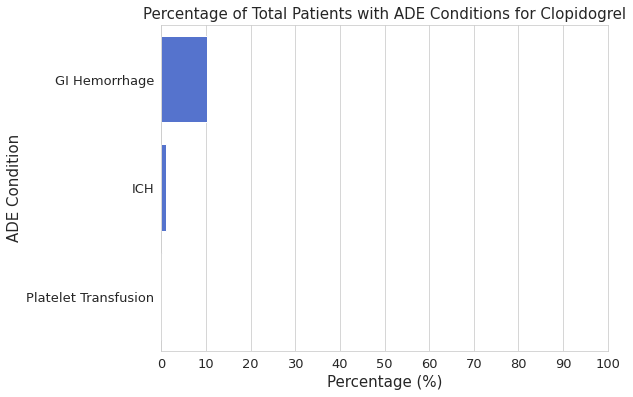

In [147]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(8,6))
# fig.suptitle('Visit Type Frequency for All Events', fontsize = 20)
# fig.subplots_adjust(hspace=0.4, wspace = 1)

# Condition 1
sns.barplot(ax = ax, data = cond_counts_inst, x='Percentage', y='Condition', color = 'royalblue')
ax.set_title('Percentage of Total Patients with ADE Conditions for Clopidogrel', fontsize = 15)
ax.set_xlabel('Percentage (%)', fontsize = 15)
ax.set_ylabel('ADE Condition', fontsize = 15)
ax.set_xticks(range(0,110,10))
ax.tick_params(labelsize=13)
ax.set_yticklabels(['GI Hemorrhage', 'ICH', 'Platelet Transfusion'])

plt.show()

## Popular Condition Codes Frequency

### Data Wrangle

In [148]:
overlaps = [overlap_df2, overlap_df3, overlap_df5]
cond_all_ct = []
cond_show_tbl = []

for ov in overlaps:
    if 'condition_concept_id' in ov.columns:
        cond_ct = ov.groupby([
            'condition_concept_id', 'condition_name']).count().reset_index()[[
            'condition_concept_id', 'condition_name', 'drug_name']]
        cond_ct.columns = ['condition_concept_id', 'condition_name', 'count']
        cond_ct.condition_concept_id[:cond_ct.shape[0]] = (
            cond_ct.condition_concept_id[:cond_ct.shape[0]].astype(int).map(str))
    else:
        cond_ct = ov.groupby([
            'procedure_concept_id', 'procedure_name']).count().reset_index()[[
            'procedure_concept_id', 'procedure_name', 'drug_name']]
        cond_ct.columns = ['procedure_concept_id', 'procedure_name', 'count']
        cond_ct.procedure_concept_id[:cond_ct.shape[0]] = (
            cond_ct.procedure_concept_id[:cond_ct.shape[0]].astype(int).map(str))
    cond_ct = cond_ct.sort_values(by = ["count"], ascending = False)
    cond_show_tbl.append(cond_ct.reset_index(drop = True))
    cond_ct = cond_ct.head(8)
    cond_all_ct.append(cond_ct)

In [149]:
# overlap_df1_ip_only = overlap_df1[(overlap_df1['visit_concept_id'] == 9201.0)]
    

# overlap_df2_ip_only = overlap_df2[(overlap_df2['visit_concept_id'] == 9201.0)]
    

# overlap_df3_ip_only = overlap_df3[(overlap_df3['visit_concept_id'] == 9201.0)]
    

# overlap_df4_ip_only = overlap_df4[(overlap_df4['visit_concept_id'] == 9201.0)]
    

# overlap_df5_ip_only = overlap_df5[(overlap_df5['visit_concept_id'] == 9201.0)]
    

In [150]:
# overlap_df1_erip_only = overlap_df1[(overlap_df1['visit_concept_id'] == 262.0)]
    

# overlap_df2_erip_only = overlap_df2[(overlap_df2['visit_concept_id'] == 262.0)]
    

# overlap_df3_erip_only = overlap_df3[(overlap_df3['visit_concept_id'] == 262.0)]
    

# overlap_df4_erip_only = overlap_df4[(overlap_df4['visit_concept_id'] == 262.0)]
    

# overlap_df5_erip_only = overlap_df5[(overlap_df5['visit_concept_id'] == 262.0)]
    

In [151]:
# d = {'condition': ["GI Hemorrhage", "Intracranial Hemorrhage", "Platelet Transfusion"], 
#      'patientCounts': [overlap_df2.shape[0],overlap_df3.shape[0],overlap_df4.shape[0], overlap_df5.shape[0]], 
#      'ER Visit Counts' : [overlap_df1_er_only.shape[0],overlap_df2_er_only.shape[0],overlap_df3_er_only.shape[0],overlap_df4_er_only.shape[0], overlap_df5_er_only.shape[0]],
#     'Inpatient Visit Counts' : [overlap_df1_ip_only.shape[0],overlap_df2_ip_only.shape[0],overlap_df3_ip_only.shape[0],overlap_df4_ip_only.shape[0], overlap_df5_ip_only.shape[0]],
#     'ER/Inpatient Counts': [overlap_df1_erip_only.shape[0], overlap_df2_erip_only.shape[0], overlap_df3_erip_only.shape[0], overlap_df4_erip_only.shape[0], overlap_df5_erip_only.shape[0]],
#      'Total ER and Inpatient Visit Counts' : [overlap_df1_er.shape[0],overlap_df2_er.shape[0],overlap_df3_er.shape[0],overlap_df4_er.shape[0], overlap_df5_er.shape[0]]}
# conditionCounts = pd.DataFrame(data=d)
# conditionCounts.set_index("condition", inplace = True)

In [152]:
# conditionCounts

### Plots

In [153]:
# fig, axes = plt.subplots(1, 1, figsize=(10,8))

# #Condition1 Plot
# a = sns.barplot(data = cond1allCount, x='condition_concept_id', y='count', order = top8List1)
# axes.set_title('Condition 1 (GI Bleeding) - Frequency of Common Codes', fontsize = 15)
# axes.set_xlabel('Condition Concept ID', fontsize = 15)
# axes.set_ylabel('Frequency', fontsize = 15)
# axes.tick_params(labelsize=13)

# axes.set(ylim = (0,100))


# for p in a.patches:
#     a.annotate(format(p.get_height(), '.0f'), 
#                    (p.get_x() + p.get_width() / 2., p.get_height()), 
#                    ha = 'center', va = 'center', 
#                    xytext = (0, 9), 
#                    textcoords = 'offset points', fontsize = 12)

# plt.show()

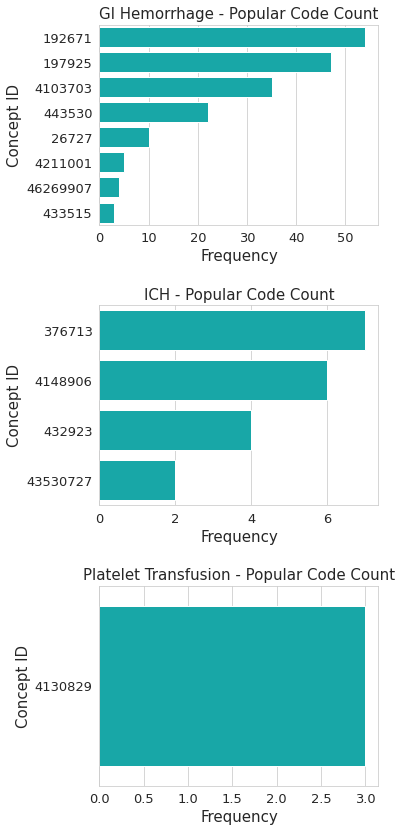

In [154]:
fig, axes = plt.subplots(3, 1, figsize=(5,14))
fig.subplots_adjust(hspace=0.4, wspace = 1)

titles = ['GI Hemorrhage - Popular Code Count', 
          'ICH - Popular Code Count',
          'Platelet Transfusion - Popular Code Count']

for i in range(len(overlaps)):
    if 'condition_concept_id' in cond_all_ct[i]:
        sns.barplot(ax = axes[i], data = cond_all_ct[i], x='count', y='condition_concept_id',
                        order = cond_all_ct[i].condition_concept_id.tolist(), color = 'c')
        axes[i].set_title(titles[i], fontsize = 15)
        axes[i].set_xlabel('Frequency', fontsize = 15 )
        axes[i].set_ylabel('Concept ID', fontsize = 15)
        axes[i].tick_params(labelsize=13)
    else:
        sns.barplot(ax = axes[i], data = cond_all_ct[i], x='count', y='procedure_concept_id',
                        order = cond_all_ct[i].procedure_concept_id.tolist(), color = 'c')
        axes[i].set_title(titles[i], fontsize = 15)
        axes[i].set_xlabel('Frequency', fontsize = 15 )
        axes[i].set_ylabel('Concept ID', fontsize = 15)
        axes[i].tick_params(labelsize=13)

plt.show()

In [155]:
cond_show_tbl[0]

,condition_concept_id,condition_name,count
0,192671,Gastrointestinal hemorrhage,54
1,197925,Hemorrhage of rectum and anus,47
2,4103703,Melena,35
3,443530,Hematochezia,22
4,26727,Hematemesis,10
5,4211001,Chronic gastric ulcer with hemorrhage,5
6,46269907,Intestinal hemorrhage with diverticulosis,4
7,433515,Chronic gastrojejunal ulcer with hemorrhage,3
8,193250,Gastric hemorrhage,3
9,316457,Mallory-Weiss syndrome,2


In [156]:
cond_show_tbl[1]

,condition_concept_id,condition_name,count
0,376713,Cerebral hemorrhage,7
1,4148906,Spontaneous subarachnoid hemorrhage,6
2,432923,Subarachnoid hemorrhage,4
3,43530727,Spontaneous cerebral hemorrhage,2


In [157]:
cond_show_tbl[2]

,procedure_concept_id,procedure_name,count
0,4130829,Platelet transfusion,3


In [158]:
# # rename cond5 table
# cond5allCount.columns = cond4allCount.columns

# # create condition column in all 5 dfs
# # cond1allCount['Condition'] = [1]*cond1allCount.shape[0]
# cond2allCount['Condition'] = [2]*cond2allCount.shape[0]
# cond3allCount['Condition'] = [3]*cond3allCount.shape[0]
# # cond4allCount['Condition'] = [4]*cond4allCount.shape[0]
# cond5allCount['Condition'] = [5]*cond5allCount.shape[0]

# cond12count = pd.concat([cond1allCount, cond2allCount])
# cond34count = pd.concat([cond3allCount, cond4allCount])
# cond34count['condition_concept_id'] = cond34count['condition_concept_id'].astype(int)
# cond12count['condition_concept_id'] = cond12count['condition_concept_id'].map(str)
# cond34count['condition_concept_id'] = cond34count['condition_concept_id'].map(str)

## Visit Type Frequency (2 plots)

Create visit count table for each condition

In [159]:
overlap_dfs = [overlap_df2_all, overlap_df3_all, overlap_df5_all]

vis_id_dfs = []
for i in range(len(overlap_dfs)):
    vis_id_cts = overlap_dfs[i].groupby('visit_concept_id').count().reset_index()[['visit_concept_id', 'drug_name']]
    vis_id_cts.columns = ['visit_concept_id', 'count']
    vis_id_cts.sort_values('count', ascending = False, inplace = True)
    vis_id_cts.reset_index(drop = True, inplace = True)
    vis_id_cts[:vis_id_cts.shape[0]] = vis_id_cts[:vis_id_cts.shape[0]].astype(int)
    vis_id_dfs.append(vis_id_cts)


Create dictionary to convert visit_concept_id to visit_type

In [160]:
vis_id_lst = pd.concat([overlap_df2.visit_concept_id, 
                        overlap_df3.visit_concept_id,
                        overlap_df5.visit_concept_id
                       ]).drop_duplicates().dropna().astype(int).tolist()

insert_visid = ",".join([f"('{x}')" for x in vis_id_lst])

vis_conv_sql = f"""
-- temp SQL table for condition codes for faster lookup using join
CREATE TEMP TABLE temp
(
  visit_concept_id STRING
);
INSERT INTO temp (
    visit_concept_id
)
VALUES {insert_visid};

-- create official table with correct integer cast
CREATE TEMP TABLE search_codes (
    visit_concept_id INT64
);

INSERT INTO search_codes
SELECT CAST(visit_concept_id as INT64) as visit_concept_id FROM temp;

--SELECT * FROM search_codes;

SELECT s.visit_concept_id, c.concept_name 
FROM search_codes s
LEFT JOIN {os.environ["WORKSPACE_CDR"]}.concept c 
        on s.visit_concept_id = c.concept_id ;
"""
vis_id_conv = pd.read_gbq(vis_conv_sql, dialect="standard")

Add visit type to vis_id_cts tables and groupby visit type

In [161]:
vis_type_dfs = []
for i in range(len(vis_id_dfs)):
    vis_type_ct = vis_id_dfs[i].join(
        vis_id_conv.set_index('visit_concept_id'), on = 'visit_concept_id')[['concept_name', 'count']]
    vis_type_ct = vis_type_ct.groupby('concept_name', dropna=False).sum().reset_index().fillna('Unknown')
    vis_type_ct.sort_values('count', ascending = False, inplace = True)
    vis_type_ct['concept_name'][
        vis_type_ct['concept_name'] == 'Emergency Room and Inpatient Visit'] = [
        'ER and Inpatient Visit']*vis_type_ct[vis_type_ct[
        'concept_name'] == 'Emergency Room and Inpatient Visit'].shape[0]
    vis_type_dfs.append(vis_type_ct)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [162]:
# # wrangle data to suit a join
vis_type_jn1 = vis_type_dfs[0].copy()
vis_type_jn2 = vis_type_dfs[1].copy()
vis_type_jn3 = vis_type_dfs[2].copy()

vis_type_jn1.columns = ['concept_name', 'GI_Hemorr']
vis_type_jn2.columns = ['concept_name', 'ICH']
vis_type_jn3.columns = ['concept_name', 'Platelet']

# join all 4 conditions by visit type
vis_type_cts_all = vis_type_jn1.join(
    vis_type_jn2.set_index('concept_name'), on = 'concept_name').join(
    vis_type_jn3.set_index('concept_name'), on = 'concept_name')

# convert all columns to integers
vis_type_cts_all = vis_type_cts_all.fillna(0)
vis_type_cts_all.GI_Hemorr[
    :vis_type_cts_all.shape[0]] = vis_type_cts_all.GI_Hemorr[:vis_type_cts_all.shape[0]].astype(int)
vis_type_cts_all.ICH[
    :vis_type_cts_all.shape[0]] = vis_type_cts_all.ICH[:vis_type_cts_all.shape[0]].astype(int)
vis_type_cts_all.Platelet[
    :vis_type_cts_all.shape[0]] = vis_type_cts_all.Platelet[:vis_type_cts_all.shape[0]].astype(int)

vis_type_cts_all.columns = ['Visit_Type', 'GI_Hemorr', 'ICH', 'Platelet']
vis_type_cts_all

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Visit_Type,GI_Hemorr,ICH,Platelet
7,Outpatient Visit,154,19,0
6,Office Visit,114,29,0
0,Emergency Room Visit,80,0,0
1,ER and Inpatient Visit,79,8,0
2,Inpatient Visit,74,1,4
8,Unknown,23,2,0
3,Laboratory Visit,2,0,0
4,No matching concept,2,0,0
5,Non-hospital institution Visit,2,0,0


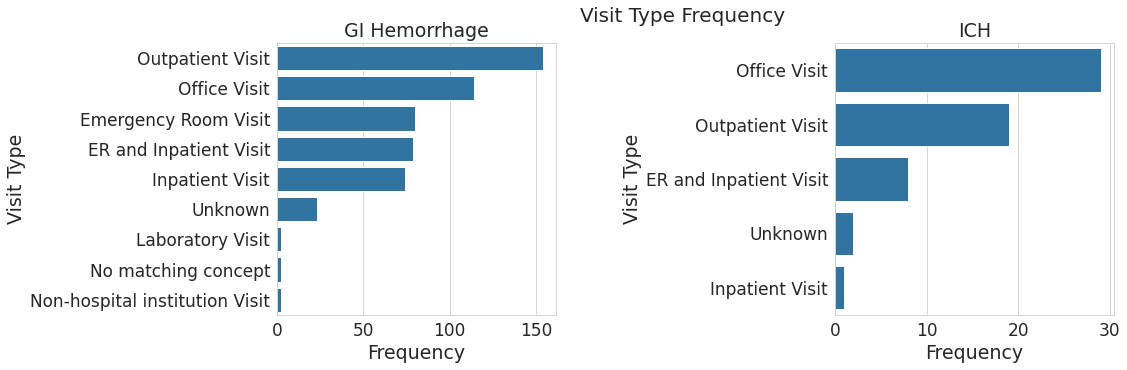

In [163]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Visit Type Frequency', fontsize = 20)
fig.subplots_adjust(hspace=0.4, wspace = 1)
titles = ['GI Hemorrhage', 'ICH', 'Platelet Transfusion']


sns.barplot(ax=axes[0], data = vis_type_dfs[0], x='count', y='concept_name', color = 'tab:blue')
axes[0].set_title(titles[0], fontsize = 19)
axes[0].set_xlabel('Frequency', fontsize = 19)
axes[0].set_ylabel('Visit Type', fontsize = 19)
axes[0].tick_params(labelsize=17)

sns.barplot(ax=axes[1], data = vis_type_dfs[1], x='count', y='concept_name', color = 'tab:blue')
axes[1].set_title(titles[1], fontsize = 19)
axes[1].set_xlabel('Frequency', fontsize = 19)
axes[1].set_ylabel('Visit Type', fontsize = 19)
axes[1].tick_params(labelsize=17)

plt.show()

# Condition 5 plot is not included as visit type is all procedure due to the event type. This would be an 
# unnecessary plot.

### Subplots of Visit Type Frequency

In [164]:
# vis_type_ct4

In [165]:
# fig, axes = plt.subplots(1, 2, figsize=(18,8))
# fig.suptitle('Visit Type Frequency for All Events', fontsize = 20)
# fig.subplots_adjust(hspace=0.4, wspace = 1)

# # # Condition 1
# # sns.barplot(ax = axes[0, 0], data = vis_type_ct1, x='count', y='concept_name', color = 'salmon')
# # axes[0, 0].set_title('Condition 1 (GI Bleeding)', fontsize = 17)
# # axes[0, 0].set_xlabel('Frequency', fontsize = 17)
# # axes[0, 0].set_ylabel('Visit Type', fontsize = 17)
# # axes[0, 0].tick_params(labelsize=15)
# # axes[0, 0].set(xlim=(0, 160))

# # Condition 2
# sns.barplot(ax=axes[0], data = vis_type_ct2, x='count', y='concept_name', color = 'salmon')
# axes[0].set_title('Condition 2 (GI Hemorrhage)', fontsize = 17)
# axes[0].set_xlabel('Frequency', fontsize = 17)
# axes[0].set_ylabel('Visit Type', fontsize = 17)
# axes[0].set_xticks(range(0, 130, 20))
# axes[0].tick_params(labelsize=15)
# axes[0].set(xlim=(0, 160))

# # Condition 3
# sns.barplot(ax=axes[1], data = vis_type_ct3, x='count', y='concept_name', color = 'salmon')
# axes[1].set_title('Condition 3 (Intracranial Hemorrhage)', fontsize = 17)
# axes[1].set_xlabel('Frequency', fontsize = 17)
# axes[1].set_ylabel('Visit Type', fontsize = 17)
# axes[1].tick_params(labelsize=15)
# axes[1].set(xlim=(0, 30))

# # # Condition 4
# # sns.barplot(ax=axes[1, 1], data = vis_type_ct4, x='count', y='concept_name', color = 'salmon')
# # axes[1, 1].set_title('Condition 4 (Intracranial Bleed Min)', fontsize = 17)
# # axes[1, 1].set_xlabel('Frequency', fontsize = 17)
# # axes[1, 1].set_ylabel('Visit Type', fontsize = 17)
# # axes[1, 1].tick_params(labelsize=15)
# # axes[1, 1].set_xticks(range(0, 11, 1))
# # axes[1, 1].set(xlim=(0, 10))
# # plt.show()

# # Condition 5 plot is not included as visit type is all procedure due to the event type. This would be an 
# # unnecessary plot.

In [166]:
# # # wrangle data to suit a join
# # vis_type_jn1 = vis_type_ct1.copy()
# vis_type_jn2 = vis_type_ct2.copy()
# vis_type_jn3 = vis_type_ct3.copy()
# # vis_type_jn4 = vis_type_ct4.copy()


# # vis_type_jn1.columns = ['concept_name', 'cond_1_count']
# vis_type_jn2.columns = ['concept_name', 'cond_2_count']
# vis_type_jn3.columns = ['concept_name', 'cond_3_count']
# # vis_type_jn4.columns = ['concept_name', 'cond_4_count']

# # join all 4 conditions by visit type
# vis_type_cts_all = vis_type_jn2.join(vis_type_jn3.set_index('concept_name'), on = 'concept_name')

# # convert all columns to integers
# vis_type_cts_all = vis_type_cts_all.fillna(0)
# vis_type_cts_all.cond_3_count[
#     :vis_type_cts_all.shape[0]] = vis_type_cts_all.cond_3_count[:vis_type_cts_all.shape[0]].astype(int)
# # vis_type_cts_all.cond_4_count[
# #     :vis_type_cts_all.shape[0]] = vis_type_cts_all.cond_4_count[:vis_type_cts_all.shape[0]].astype(int)
# vis_type_cts_all.columns = ['Visit Type', 'GI Hemorrhage Count', 'ICH Count']

In [167]:
# vis_type_cts_all

### Two Subplots of Comparisons of Visit Type Frequencies

Create combined dataframes

In [168]:
# vis_type_ct1['Condition'] = [1]*vis_type_ct1.shape[0]
# vis_type_ct2['Condition'] = [2]*vis_type_ct2.shape[0]
# vis_type_ct3['Condition'] = [3]*vis_type_ct3.shape[0]
# vis_type_ct4['Condition'] = [4]*vis_type_ct4.shape[0]

# vis_cts12 = pd.concat([vis_type_ct1, vis_type_ct2])
# vis_cts34 = pd.concat([vis_type_ct3, vis_type_ct4])

NameError: name 'vis_type_ct1' is not defined

In [ ]:
# vis_cts34

In [ ]:
# fig, axes = plt.subplots(1, 2, figsize=(10,5), sharey = True)
# fig.suptitle('Compare Visit Type frequencies between Conditions', fontsize = 15)
# sns.set_palette("Paired")

# # Condition 1 vs 2
# sns.barplot(ax = axes[0], data = vis_cts12, x='count', y='concept_name', hue = 'Condition')
# axes[0].set_xlabel('Frequency', fontsize = 15)
# axes[0].set_ylabel('Visit Type', fontsize = 15)
# axes[0].set_title('Bleeding: Condition 1 vs. 2', fontsize = 15)
# axes[0].tick_params(labelsize = 13)
# axes[0].legend(fontsize = 'xx-large', loc = 4)

# # Condition 3 vs 4
# sns.barplot(ax = axes[1], data = vis_cts34, x='count', y='concept_name', hue = 'Condition')
# axes[1].set_title('ICH: Condition 3 vs. 4', fontsize = 15)
# axes[1].set_xlabel('Frequency', fontsize = 15)
# axes[1].set_ylabel('Visit Type', fontsize = 15)
# axes[1].tick_params(labelsize = 13)
# # axes[1].set(xlabel = 'Frequency', ylabel = 'Visit Type', title = 'ICH: Condition 3 vs. 4')
# axes[1].legend(loc=4, fontsize = 'xx-large')
# plt.show()

## Cohort Overlap Visualization (Percent)

### All Visit Types

In [169]:
temp1 = overlap_df1.reset_index()
temp2 = overlap_df2.reset_index()
temp3 = overlap_df3.reset_index()
temp4 = overlap_df4.reset_index()
temp5 = overlap_df5.reset_index()

temp1_er = overlap_df1_er.reset_index()
temp2_er = overlap_df2_er.reset_index()
temp3_er = overlap_df3_er.reset_index()
temp4_er = overlap_df4_er.reset_index()
temp5_er = overlap_df5_er.reset_index()

cond = ['GI Bleed', 'GI Hemorrhage', 'Intracranial Hemorrhage', 'Intracranial Hemorrhage Min', 'Platelet Transfusion']
temps = [temp1, temp2, temp3, temp4, temp5]
temps_er = [temp1_er, temp2_er, temp3_er, temp4_er, temp5_er]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator


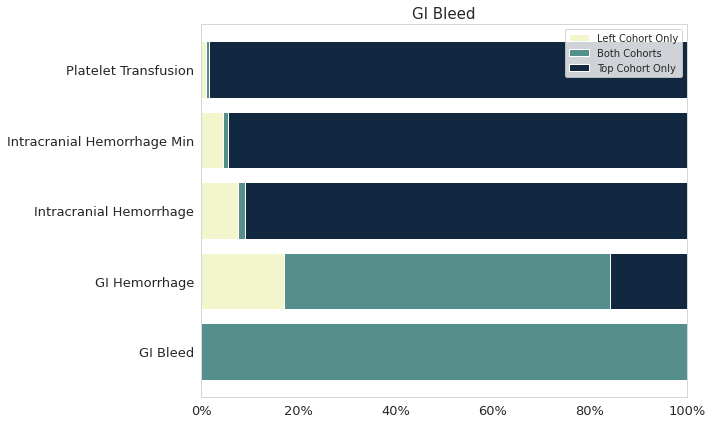

In [170]:
# Condition 1
fig, axes = plt.subplots(1,1, figsize = (10,6))

for i in range(1):
    top_list, left_list, both_list = [], [], []
    for j in range(len(cond)):
        x_y = list(temps[i]['person_id'].isin(temps[j]['person_id']).value_counts())
        y_x = list(temps[j]['person_id'].isin(temps[i]['person_id']).value_counts())

        total = sum(set(x_y + y_x))
        if len(set(x_y).intersection(y_x)) != 0:
            both = set(x_y).intersection(y_x).pop()
            x_y.remove(both)
            y_x.remove(both)
        else:
            both = 0
        both = round(both/total*100,2)
        top = 0.00 if len(x_y) == 0 else round(x_y[0]/total*100,2)
        left = 0.00 if len(y_x) == 0 else round(y_x[0]/total*100,2)

        top_list.append(top)
        left_list.append(left)
        both_list.append(both)
    
    left_both = np.add(left_list, both_list).tolist()
    
    # Left Cohort
    axes.barh(cond, left_list, color='#F3F6CC')
    
    # Both Cohort
    axes.barh(cond, both_list, left=left_list, color='#558F8B')
    
    # Top Co
    axes.barh(cond, top_list, left=left_both, color='#122740')
    
    axes.grid(True, axis='x', linewidth=2, color='white')
    axes.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
    axes.tick_params('y', labelsize= 13)
    axes.set_title(cond[i], fontsize= 15)
    axes.tick_params('x', labelsize = 13)
    axes.legend(['Left Cohort Only', 'Both Cohorts', 'Top Cohort Only'], loc = 'upper right', fontsize = 'medium')
    #plt.figlegend(['Left Cohort Only', 'Both Cohorts', 'Top Cohort Only'], loc = 'upper right', fontsize = 'xx-large')
    
#fig.suptitle('Cohort Overlap', fontsize=30, verticalalignment='top')    
fig.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator


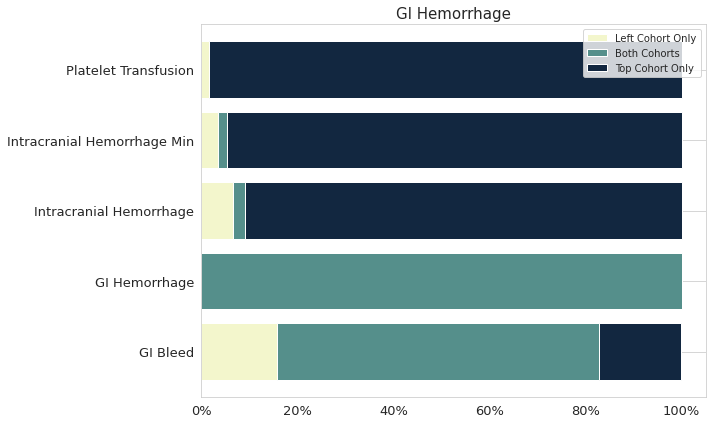

In [171]:
# Condition 2
fig, axes = plt.subplots(1,1, figsize = (10,6))

for i in range(1,2):
    top_list, left_list, both_list = [], [], []
    for j in range(len(cond)):
        x_y = list(temps[i]['person_id'].isin(temps[j]['person_id']).value_counts())
        y_x = list(temps[j]['person_id'].isin(temps[i]['person_id']).value_counts())

        total = sum(set(x_y + y_x))
        if len(set(x_y).intersection(y_x)) != 0:
            both = set(x_y).intersection(y_x).pop()
            x_y.remove(both)
            y_x.remove(both)
        else:
            both = 0
        both = round(both/total*100,2)
        top = 0.00 if len(x_y) == 0 else round(x_y[0]/total*100,2)
        left = 0.00 if len(y_x) == 0 else round(y_x[0]/total*100,2)

        top_list.append(top)
        left_list.append(left)
        both_list.append(both)
    
    left_both = np.add(left_list, both_list).tolist()
    
    # Left Cohort
    axes.barh(cond, left_list, color='#F3F6CC')
    
    # Both Cohort
    axes.barh(cond, both_list, left=left_list, color='#558F8B')
    
    # Top Co
    axes.barh(cond, top_list, left=left_both, color='#122740')
    
    axes.grid(True, axis='x', linewidth=2, color='white')
    axes.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
    axes.tick_params('y', labelsize=13)
    axes.set_title(cond[i], fontsize=15)
    axes.tick_params('x', labelsize = 13)
    axes.legend(['Left Cohort Only', 'Both Cohorts', 'Top Cohort Only'], loc = 'upper right', fontsize = 'medium')
    #plt.figlegend(['Left Cohort Only', 'Both Cohorts', 'Top Cohort Only'], loc = 'upper right', fontsize = 'xx-large')
    
#fig.suptitle('Cohort Overlap', fontsize=30, verticalalignment='top')    
fig.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator


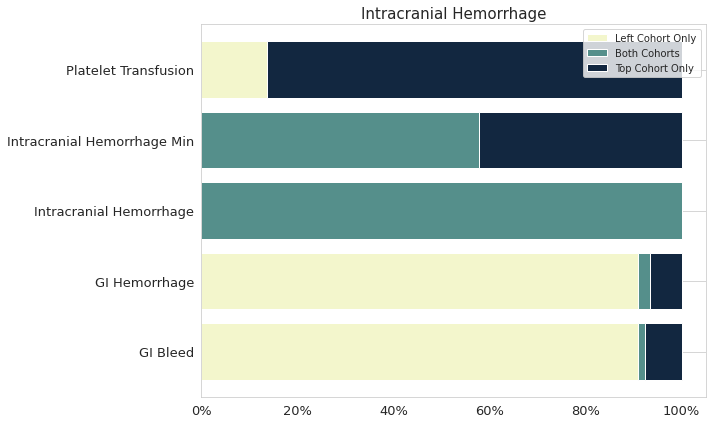

In [172]:
# Condition 3
fig, axes = plt.subplots(1,1, figsize = (10,6))

for i in range(2,3):
    top_list, left_list, both_list = [], [], []
    for j in range(len(cond)):
        x_y = list(temps[i]['person_id'].isin(temps[j]['person_id']).value_counts())
        y_x = list(temps[j]['person_id'].isin(temps[i]['person_id']).value_counts())

        total = sum(set(x_y + y_x))
        if len(set(x_y).intersection(y_x)) != 0:
            both = set(x_y).intersection(y_x).pop()
            x_y.remove(both)
            y_x.remove(both)
        else:
            both = 0
        both = round(both/total*100,2)
        top = 0.00 if len(x_y) == 0 else round(x_y[0]/total*100,2)
        left = 0.00 if len(y_x) == 0 else round(y_x[0]/total*100,2)

        top_list.append(top)
        left_list.append(left)
        both_list.append(both)
    
    left_both = np.add(left_list, both_list).tolist()
    
    # Left Cohort
    axes.barh(cond, left_list, color='#F3F6CC')
    
    # Both Cohort
    axes.barh(cond, both_list, left=left_list, color='#558F8B')
    
    # Top Co
    axes.barh(cond, top_list, left=left_both, color='#122740')
    
    axes.grid(True, axis='x', linewidth=2, color='white')
    axes.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
    axes.tick_params('y', labelsize=13)
    axes.set_title(cond[i], fontsize=15)
    axes.tick_params('x', labelsize = 13)
    axes.legend(['Left Cohort Only', 'Both Cohorts', 'Top Cohort Only'], loc = 'upper right', fontsize = 'medium')
    #plt.figlegend(['Left Cohort Only', 'Both Cohorts', 'Top Cohort Only'], loc = 'upper right', fontsize = 'xx-large')
    
#fig.suptitle('Cohort Overlap', fontsize=30, verticalalignment='top')    
fig.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator


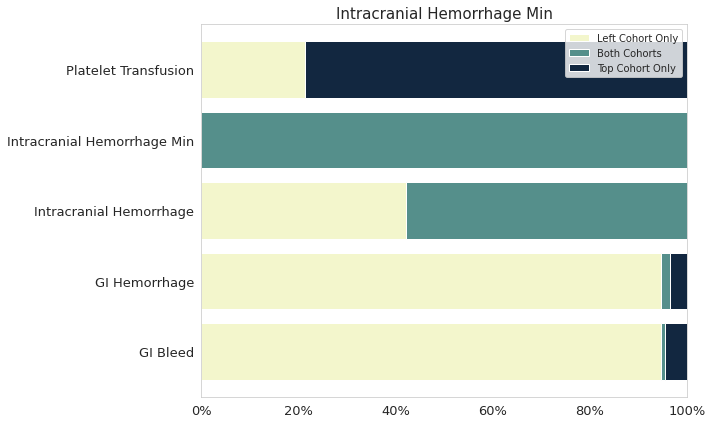

In [173]:
# Condition 4
fig, axes = plt.subplots(1,1, figsize = (10,6))

for i in range(3,4):
    top_list, left_list, both_list = [], [], []
    for j in range(len(cond)):
        x_y = list(temps[i]['person_id'].isin(temps[j]['person_id']).value_counts())
        y_x = list(temps[j]['person_id'].isin(temps[i]['person_id']).value_counts())

        total = sum(set(x_y + y_x))
        if len(set(x_y).intersection(y_x)) != 0:
            both = set(x_y).intersection(y_x).pop()
            x_y.remove(both)
            y_x.remove(both)
        else:
            both = 0
        both = round(both/total*100,2)
        top = 0.00 if len(x_y) == 0 else round(x_y[0]/total*100,2)
        left = 0.00 if len(y_x) == 0 else round(y_x[0]/total*100,2)

        top_list.append(top)
        left_list.append(left)
        both_list.append(both)
    
    left_both = np.add(left_list, both_list).tolist()
    
    # Left Cohort
    axes.barh(cond, left_list, color='#F3F6CC')
    
    # Both Cohort
    axes.barh(cond, both_list, left=left_list, color='#558F8B')
    
    # Top Co
    axes.barh(cond, top_list, left=left_both, color='#122740')
    
    axes.grid(True, axis='x', linewidth=2, color='white')
    axes.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
    axes.tick_params('y', labelsize=13)
    axes.set_title(cond[i], fontsize=15)
    axes.tick_params('x', labelsize = 13)
    axes.legend(['Left Cohort Only', 'Both Cohorts', 'Top Cohort Only'], loc = 'upper right', fontsize = 'medium')
    #plt.figlegend(['Left Cohort Only', 'Both Cohorts', 'Top Cohort Only'], loc = 'upper right', fontsize = 'xx-large')
    
#fig.suptitle('Cohort Overlap', fontsize=30, verticalalignment='top')    
fig.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator


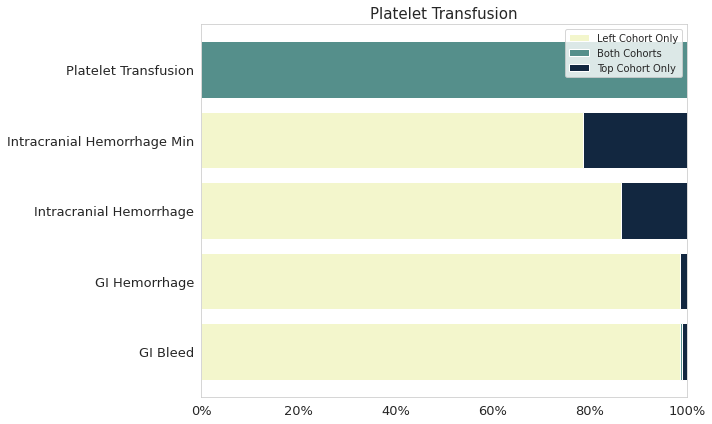

In [174]:
# Condition 5
fig, axes = plt.subplots(1,1, figsize = (10,6))

for i in range(4,5):
    top_list, left_list, both_list = [], [], []
    for j in range(len(cond)):
        x_y = list(temps[i]['person_id'].isin(temps[j]['person_id']).value_counts())
        y_x = list(temps[j]['person_id'].isin(temps[i]['person_id']).value_counts())

        total = sum(set(x_y + y_x))
        if len(set(x_y).intersection(y_x)) != 0:
            both = set(x_y).intersection(y_x).pop()
            x_y.remove(both)
            y_x.remove(both)
        else:
            both = 0
        both = round(both/total*100,2)
        top = 0.00 if len(x_y) == 0 else round(x_y[0]/total*100,2)
        left = 0.00 if len(y_x) == 0 else round(y_x[0]/total*100,2)

        top_list.append(top)
        left_list.append(left)
        both_list.append(both)
    
    left_both = np.add(left_list, both_list).tolist()
    
    # Left Cohort
    axes.barh(cond, left_list, color='#F3F6CC')
    
    # Both Cohort
    axes.barh(cond, both_list, left=left_list, color='#558F8B')
    
    # Top Co
    axes.barh(cond, top_list, left=left_both, color='#122740')
    
    axes.grid(True, axis='x', linewidth=2, color='white')
    axes.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
    axes.tick_params('y', labelsize=13)
    axes.set_title(cond[i], fontsize=15)
    axes.tick_params('x', labelsize = 13)
    axes.legend(['Left Cohort Only', 'Both Cohorts', 'Top Cohort Only'], loc = 'upper right', fontsize = 'medium')
    #plt.figlegend(['Left Cohort Only', 'Both Cohorts', 'Top Cohort Only'], loc = 'upper right', fontsize = 'xx-large')
    
#fig.suptitle('Cohort Overlap', fontsize=30, verticalalignment='top')    
fig.tight_layout()
plt.show()

### Only ER and Inpatient Visit Types

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator


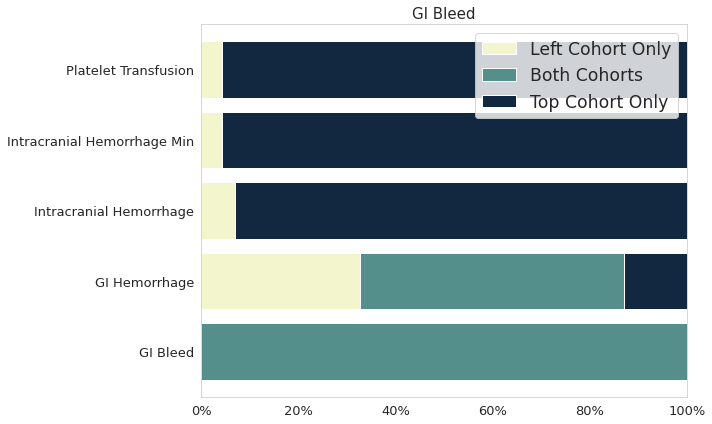

In [175]:
# Condition 1
fig, axes = plt.subplots(1,1, figsize = (10,6))

for i in range(1):
    top_list, left_list, both_list = [], [], []
    for j in range(len(cond)):
        x_y = list(temps_er[i]['person_id'].isin(temps_er[j]['person_id']).value_counts())
        y_x = list(temps_er[j]['person_id'].isin(temps_er[i]['person_id']).value_counts())
        
        if len(set(x_y).intersection(y_x)) != 0:
            both = set(x_y).intersection(y_x).pop()
            x_y.remove(both)
            y_x.remove(both)
        else: 
            both = 0
        top = 0.00 if len(x_y) == 0 else x_y[0]
        left = 0.00 if len(y_x) == 0 else y_x[0]
        total = both + left + top
        
        both = round(both/total*100,2)
        top = round(top/total*100,2)
        left = round(left/total*100,2)
        
        top_list.append(top)
        left_list.append(left)
        both_list.append(both)
    
    left_both = np.add(left_list, both_list).tolist()
    
    # Left Cohort
    axes.barh(cond, left_list, color='#F3F6CC')
    
    # Both Cohort
    axes.barh(cond, both_list, left=left_list, color='#558F8B')
    
    # Top Co
    axes.barh(cond, top_list, left=left_both, color='#122740')
    
    axes.grid(True, axis='x', linewidth=2, color='white')
    axes.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
    axes.tick_params('y', labelsize=13)
    axes.set_title(cond[i], fontsize=15)
    axes.tick_params('x', labelsize = 13)
    axes.legend(['Left Cohort Only', 'Both Cohorts', 'Top Cohort Only'], loc = 'upper right', fontsize = 'xx-large')

    #fig.suptitle('Cohort Overlap (Inpatient/ER Only)', fontsize=25)
    
fig.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator


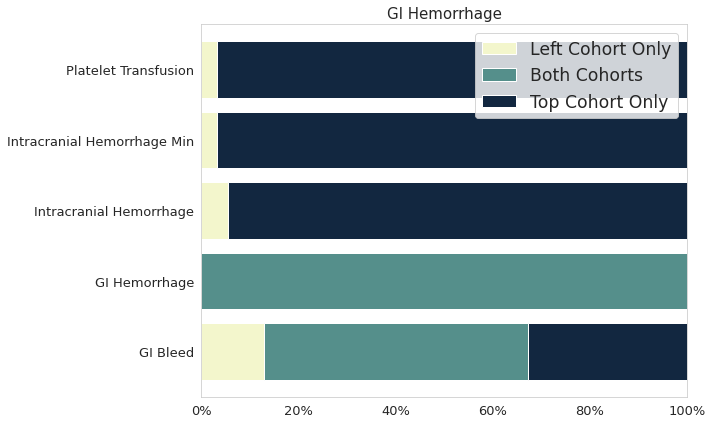

In [176]:
# Condition 2
fig, axes = plt.subplots(1,1, figsize = (10,6))

for i in range(1,2):
    top_list, left_list, both_list = [], [], []
    for j in range(len(cond)):
        x_y = list(temps_er[i]['person_id'].isin(temps_er[j]['person_id']).value_counts())
        y_x = list(temps_er[j]['person_id'].isin(temps_er[i]['person_id']).value_counts())
        
        if len(set(x_y).intersection(y_x)) != 0:
            both = set(x_y).intersection(y_x).pop()
            x_y.remove(both)
            y_x.remove(both)
        else: 
            both = 0
        top = 0.00 if len(x_y) == 0 else x_y[0]
        left = 0.00 if len(y_x) == 0 else y_x[0]
        total = both + left + top
        
        both = round(both/total*100,2)
        top = round(top/total*100,2)
        left = round(left/total*100,2)
        
        top_list.append(top)
        left_list.append(left)
        both_list.append(both)
    
    left_both = np.add(left_list, both_list).tolist()
    
    # Left Cohort
    axes.barh(cond, left_list, color='#F3F6CC')
    
    # Both Cohort
    axes.barh(cond, both_list, left=left_list, color='#558F8B')
    
    # Top Co
    axes.barh(cond, top_list, left=left_both, color='#122740')
    
    axes.grid(True, axis='x', linewidth=2, color='white')
    axes.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
    axes.tick_params('y', labelsize=13)
    axes.set_title(cond[i], fontsize=15)
    axes.tick_params('x', labelsize = 13)
    axes.legend(['Left Cohort Only', 'Both Cohorts', 'Top Cohort Only'], loc = 'upper right', fontsize = 'xx-large')

    #fig.suptitle('Cohort Overlap (Inpatient/ER Only)', fontsize=25)
    
fig.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator


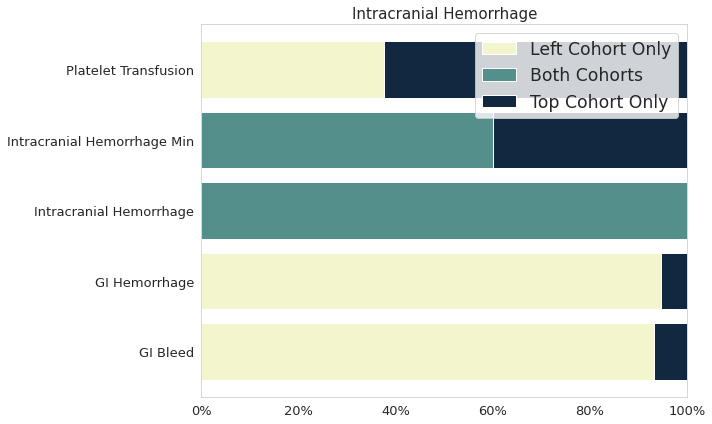

In [177]:
# Condition 3
fig, axes = plt.subplots(1,1, figsize = (10,6))

for i in range(2,3):
    top_list, left_list, both_list = [], [], []
    for j in range(len(cond)):
        x_y = list(temps_er[i]['person_id'].isin(temps_er[j]['person_id']).value_counts())
        y_x = list(temps_er[j]['person_id'].isin(temps_er[i]['person_id']).value_counts())
        
        if len(set(x_y).intersection(y_x)) != 0:
            both = set(x_y).intersection(y_x).pop()
            x_y.remove(both)
            y_x.remove(both)
        else: 
            both = 0
        top = 0.00 if len(x_y) == 0 else x_y[0]
        left = 0.00 if len(y_x) == 0 else y_x[0]
        total = both + left + top
        
        both = round(both/total*100,2)
        top = round(top/total*100,2)
        left = round(left/total*100,2)
        
        top_list.append(top)
        left_list.append(left)
        both_list.append(both)
    
    left_both = np.add(left_list, both_list).tolist()
    
    # Left Cohort
    axes.barh(cond, left_list, color='#F3F6CC')
    
    # Both Cohort
    axes.barh(cond, both_list, left=left_list, color='#558F8B')
    
    # Top Co
    axes.barh(cond, top_list, left=left_both, color='#122740')
    
    axes.grid(True, axis='x', linewidth=2, color='white')
    axes.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
    axes.tick_params('y', labelsize=13)
    axes.set_title(cond[i], fontsize=15)
    axes.tick_params('x', labelsize = 13)
    axes.legend(['Left Cohort Only', 'Both Cohorts', 'Top Cohort Only'], loc = 'upper right', fontsize = 'xx-large')

    #fig.suptitle('Cohort Overlap (Inpatient/ER Only)', fontsize=25)
    
fig.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator


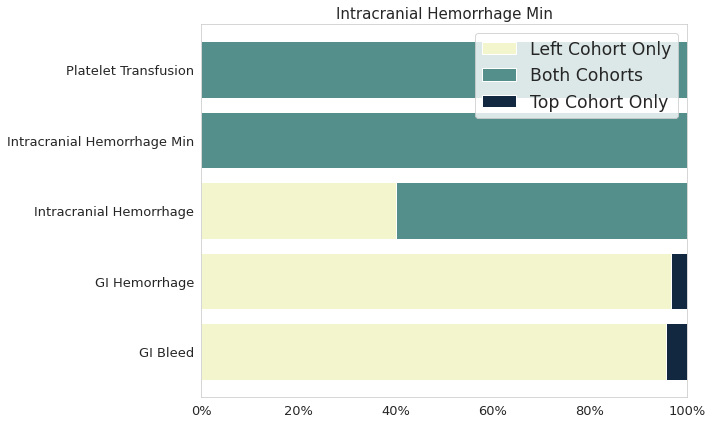

In [178]:
# Condition 4
fig, axes = plt.subplots(1,1, figsize = (10,6))

for i in range(3,4):
    top_list, left_list, both_list = [], [], []
    for j in range(len(cond)):
        x_y = list(temps_er[i]['person_id'].isin(temps_er[j]['person_id']).value_counts())
        y_x = list(temps_er[j]['person_id'].isin(temps_er[i]['person_id']).value_counts())
        
        if len(set(x_y).intersection(y_x)) != 0:
            both = set(x_y).intersection(y_x).pop()
            x_y.remove(both)
            y_x.remove(both)
        else: 
            both = 0
        top = 0.00 if len(x_y) == 0 else x_y[0]
        left = 0.00 if len(y_x) == 0 else y_x[0]
        total = both + left + top
        
        both = round(both/total*100,2)
        top = round(top/total*100,2)
        left = round(left/total*100,2)
        
        top_list.append(top)
        left_list.append(left)
        both_list.append(both)
    
    left_both = np.add(left_list, both_list).tolist()
    
    # Left Cohort
    axes.barh(cond, left_list, color='#F3F6CC')
    
    # Both Cohort
    axes.barh(cond, both_list, left=left_list, color='#558F8B')
    
    # Top Co
    axes.barh(cond, top_list, left=left_both, color='#122740')
    
    axes.grid(True, axis='x', linewidth=2, color='white')
    axes.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
    axes.tick_params('y', labelsize=13)
    axes.set_title(cond[i], fontsize=15)
    axes.tick_params('x', labelsize = 13)
    axes.legend(['Left Cohort Only', 'Both Cohorts', 'Top Cohort Only'], loc = 'upper right', fontsize = 'xx-large')

    #fig.suptitle('Cohort Overlap (Inpatient/ER Only)', fontsize=25)
    
fig.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator


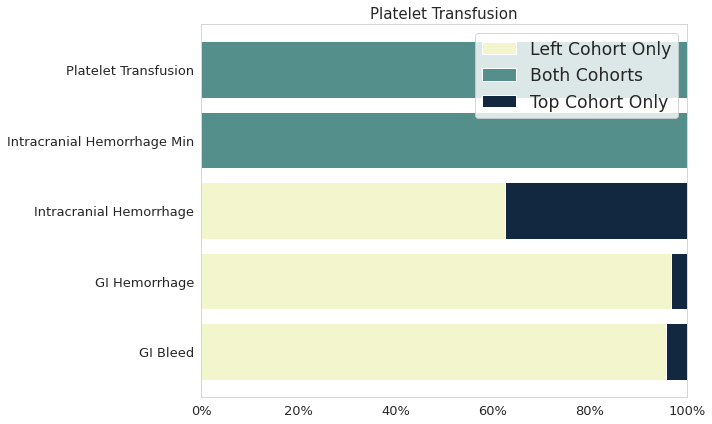

In [179]:
# Condition 5
fig, axes = plt.subplots(1,1, figsize = (10,6))

for i in range(4,5):
    top_list, left_list, both_list = [], [], []
    for j in range(len(cond)):
        x_y = list(temps_er[i]['person_id'].isin(temps_er[j]['person_id']).value_counts())
        y_x = list(temps_er[j]['person_id'].isin(temps_er[i]['person_id']).value_counts())
        
        if len(set(x_y).intersection(y_x)) != 0:
            both = set(x_y).intersection(y_x).pop()
            x_y.remove(both)
            y_x.remove(both)
        else: 
            both = 0
        top = 0.00 if len(x_y) == 0 else x_y[0]
        left = 0.00 if len(y_x) == 0 else y_x[0]
        total = both + left + top
        
        both = round(both/total*100,2)
        top = round(top/total*100,2)
        left = round(left/total*100,2)
        
        top_list.append(top)
        left_list.append(left)
        both_list.append(both)
    
    left_both = np.add(left_list, both_list).tolist()
    
    # Left Cohort
    axes.barh(cond, left_list, color='#F3F6CC')
    
    # Both Cohort
    axes.barh(cond, both_list, left=left_list, color='#558F8B')
    
    # Top Co
    axes.barh(cond, top_list, left=left_both, color='#122740')
    
    axes.grid(True, axis='x', linewidth=2, color='white')
    axes.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
    axes.tick_params('y', labelsize=13)
    axes.set_title(cond[i], fontsize=15)
    axes.tick_params('x', labelsize = 13)
    axes.legend(['Left Cohort Only', 'Both Cohorts', 'Top Cohort Only'], loc = 'upper right', fontsize = 'xx-large')

    #fig.suptitle('Cohort Overlap (Inpatient/ER Only)', fontsize=25)
    
fig.tight_layout()
plt.show()

In [180]:
# l = []
# for i in range(len(cond)):
    
#     for j in range(len(cond)):
#         x_y = list(temps[i]['person_id'].isin(temps[j]['person_id']).value_counts())
#         y_x = list(temps[j]['person_id'].isin(temps[i]['person_id']).value_counts())

#         total = sum(set(x_y + y_x))
#         if len(set(x_y).intersection(y_x)) != 0:
#             both = set(x_y).intersection(y_x).pop()
#             x_y.remove(both)
#             y_x.remove(both)
#         else:
#             both = 0
#         both_count = both
#         top_count = 0 if len(x_y) == 0 else x_y[0]
#         left_count = 0 if len(y_x) == 0 else y_x[0]
#         both = round(both/total*100,2)
#         top = 0.00 if len(x_y) == 0 else round(x_y[0]/total*100,2)
#         left = 0.00 if len(y_x) == 0 else round(y_x[0]/total*100,2)
        
#         l.append({'Top Cohort': cond[i], 'Left Cohort': cond[j], 'count': top_count, 'percent': top, 'label': 'Top Cohort Only'})
#         l.append({'Top Cohort': cond[i], 'Left Cohort': cond[j], 'count': both_count, 'percent': both, 'label': 'Both Cohorts'})
#         l.append({'Top Cohort': cond[i], 'Left Cohort': cond[j], 'count': left_count, 'percent': left, 'label': 'Left Cohort Only'})

In [181]:
# cohort_overlap = pd.DataFrame(l)
# create_download_link(cohort_overlap, "Download cohort_overlap CSV", "cohort_overlap.csv")

In [182]:
# l_er = []
# for i in range(len(cond)):

#     for j in range(len(cond)):
#         x_y = list(temps_er[i]['person_id'].isin(temps_er[j]['person_id']).value_counts())
#         y_x = list(temps_er[j]['person_id'].isin(temps_er[i]['person_id']).value_counts())
        
#         if len(set(x_y).intersection(y_x)) != 0:
#             both = set(x_y).intersection(y_x).pop()
#             x_y.remove(both)
#             y_x.remove(both)
#         else: 
#             both = 0
        
#         both_count = both
#         top_count = 0.00 if len(x_y) == 0 else x_y[0]
#         left_count = 0.00 if len(y_x) == 0 else y_x[0]
#         total = both + left + top
        
#         both = round(both/total*100,2)
#         top = round(top_count/total*100,2)
#         left = round(left_count/total*100,2)
        
#         l_er.append({'Top Cohort': cond[i], 'Left Cohort': cond[j], 'count': top_count, 'percent': top, 'label': 'Top Cohort Only'})
#         l_er.append({'Top Cohort': cond[i], 'Left Cohort': cond[j], 'count': both_count, 'percent': both, 'label': 'Both Cohorts'})
#         l_er.append({'Top Cohort': cond[i], 'Left Cohort': cond[j], 'count': left_count, 'percent': left, 'label': 'Left Cohort Only'})

In [183]:
# cohort_overlap_er = pd.DataFrame(l_er)
# create_download_link(cohort_overlap_er, "Download cohort_overlap_er CSV", "cohort_overlap_er.csv")

## Multidimensional Plots

### Race, Sex, Age and Dispension Count Distribution by ADE Classification

In [184]:
ade2_min = overlap_df2.reset_index()[overlap_df2.reset_index().columns[:39]]
clopidogrel_3['ADE_Classification'] = pd.Series(['No']*1907)
ade2_min['ADE_Classification'] = pd.Series(['Yes']*overlap_df2.shape[0])

In [185]:
clop_ade = pd.concat([clopidogrel_3, ade2_min], ignore_index=True).groupby(
    'person_id', as_index = False).apply(lambda x: x.sort_values(
    'ADE_Classification', ascending = False).head(1)).reset_index(drop = True)

In [186]:
race_dic = {'Another single population': 'Other',
            'I prefer not to answer': 'Unknown',
            'No matching concept': 'Unknown',
            'None of these': 'Other',
            'None Indicated': 'Unknown',
            'PMI: Skip' : 'Unknown',
            'More than one population': 'Other'}
clop_ade.race = clop_ade.race.replace(race_dic)
race_grp = clop_ade.groupby(['race', 'ADE_Classification']).count().reset_index()[[
    'race', 'ADE_Classification', 'person_id']]

race_tot = race_grp.groupby('race').sum('person_id').reset_index()['person_id'].tolist()

len(race_tot)
race_dbl = [0]*len(race_tot)*2
for i in range(len(race_dbl)):
    race_dbl[i] = race_tot[i//2]
    
race_grp['total'] = race_dbl
race_grp['percentage'] = 100*race_grp['person_id']/race_grp['total']

In [187]:
sex_dic = {'Not male, not female, prefer not to answer, or skipped': 'Other',
           'No matching concept': 'Other'}
clop_ade.sex_at_birth = clop_ade.sex_at_birth.replace(sex_dic)
sex_grp = clop_ade.groupby(['sex_at_birth', 'ADE_Classification']).count().reset_index()[[
    'sex_at_birth', 'ADE_Classification', 'person_id']]
sex_tot = sex_grp.groupby('sex_at_birth').sum('person_id').reset_index()['person_id'].tolist()

len(sex_tot)
sex_dbl = [0]*len(sex_tot)*2
for i in range(len(sex_dbl)):
    sex_dbl[i] = sex_tot[i//2]

sex_grp['total'] = sex_dbl
sex_grp['percentage'] = 100*sex_grp['person_id']/sex_grp['total']

In [188]:
clop_ade['age'] = pd.DatetimeIndex(clop_ade.index_date).year - clop_ade.year_of_birth
age_grp = clop_ade[['age', 'ADE_Classification']]

In [189]:
clop_ade.dispensed_count

0       19
1        6
2       14
3       30
4       10
        ..
1902     2
1903    12
1904     3
1905     2
1906    24
Name: dispensed_count, Length: 1907, dtype: int64

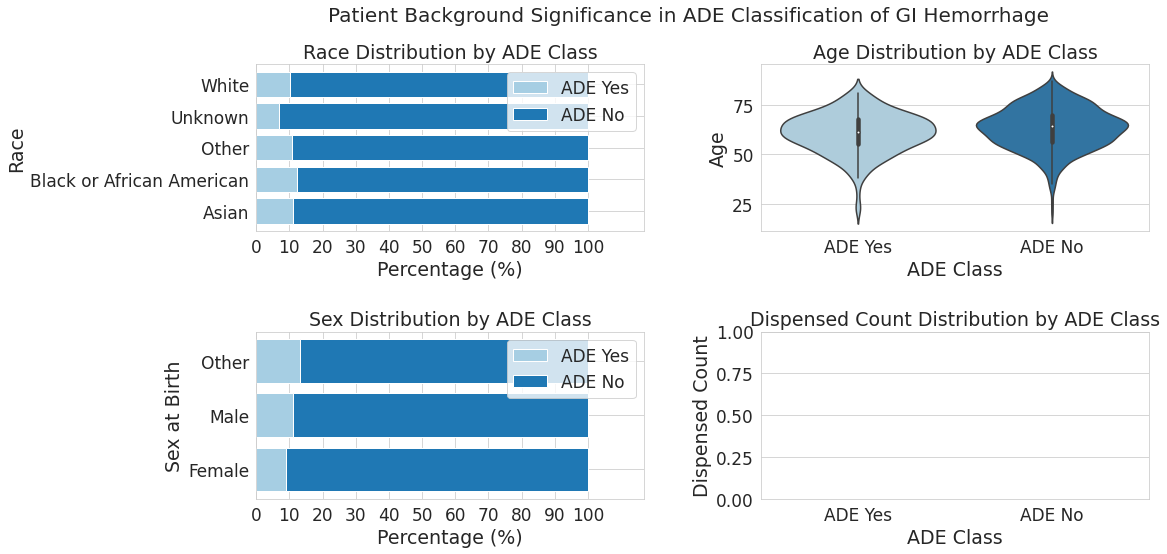

In [190]:
sns.set_palette('Paired')
fig, axes = plt.subplots(2, 2, figsize=(16,8))
fig.suptitle('Patient Background Significance in ADE Classification of GI Hemorrhage', fontsize = 20)
fig.subplots_adjust(hspace=0.6, wspace = 0.3)

# race
axes[0,0].barh(race_grp['race'].drop_duplicates().tolist(), 
               race_grp[race_grp['ADE_Classification'] == 'Yes']['percentage'].tolist(),
              label = 'ADE Yes')
axes[0,0].barh(race_grp['race'].drop_duplicates().tolist(), 
               race_grp[race_grp['ADE_Classification'] == 'No']['percentage'].tolist(), 
               left = race_grp[race_grp['ADE_Classification'] == 'Yes']['percentage'].tolist(),
              label = 'ADE No')
axes[0, 0].set_title('Race Distribution by ADE Class', fontsize = 19)
axes[0, 0].set_xlabel('Percentage (%)', fontsize = 19)
axes[0, 0].set_ylabel('Race', fontsize = 19)
axes[0, 0].tick_params(labelsize = 17)
axes[0, 0].set_xticks(range(0,110,10))
axes[0, 0].set_xlim(0,117)
axes[0, 0].legend(fontsize=17) 

# sex
axes[1, 0].barh(sex_grp['sex_at_birth'].drop_duplicates().tolist(), 
               sex_grp[sex_grp['ADE_Classification'] == 'Yes']['percentage'].tolist(),
               label = 'ADE Yes')
axes[1, 0].barh(sex_grp['sex_at_birth'].drop_duplicates().tolist(), 
               sex_grp[sex_grp['ADE_Classification'] == 'No']['percentage'].tolist(), 
               left = sex_grp[sex_grp['ADE_Classification'] == 'Yes']['percentage'].tolist(),
               label = 'ADE No')
axes[1, 0].set_title('Sex Distribution by ADE Class', fontsize = 19)
axes[1, 0].set_xlabel('Percentage (%)', fontsize = 19)
axes[1, 0].set_ylabel('Sex at Birth', fontsize = 19)
axes[1, 0].tick_params(labelsize = 17)
axes[1, 0].set_xlim(0,117)
axes[1, 0].set_xticks(range(0,110,10))
axes[1, 0].legend(fontsize=17, loc="upper right")

# age
sns.violinplot(ax = axes[0, 1], x="ADE_Classification", y="age", data=age_grp, order = ['Yes', 'No'])
axes[0, 1].set_title('Age Distribution by ADE Class', fontsize = 19)
axes[0, 1].set_xlabel('ADE Class', fontsize = 19)
axes[0, 1].set_ylabel('Age', fontsize = 19)
axes[0, 1].set_xticklabels(labels = ['ADE Yes', 'ADE No'])
axes[0, 1].tick_params(labelsize = 17)

# dispensed amount
sns.violinplot(ax = axes[1, 1], x = 'ADE_Classification', y = 'dispensed_count', 
               data = clop_ade, order = [1, 0])
axes[1, 1].set_title('Dispensed Count Distribution by ADE Class', fontsize = 19)
axes[1, 1].set_xlabel('ADE Class', fontsize = 19)
axes[1, 1].set_ylabel('Dispensed Count', fontsize = 19)
axes[1, 1].set_xticklabels(labels = ['ADE Yes', 'ADE No'])
axes[1, 1].tick_params(labelsize = 17)
plt.show()

### Chi-Squared p-values

In [191]:
ade2_min = overlap_df2.reset_index()[overlap_df2.reset_index().columns[:39]]
clopidogrel_3['ADE_Classification'] = pd.Series(['No']*clopidogrel_3.shape[0])
ade2_min['ADE_Classification'] = pd.Series(['Yes']*overlap_df2.shape[0])

ade3_min = overlap_df3.reset_index()[overlap_df3.reset_index().columns[:39]]
clopidogrel_3['ADE_Classification'] = pd.Series(['No']*clopidogrel_3.shape[0])
ade3_min['ADE_Classification'] = pd.Series(['Yes']*overlap_df3.shape[0])


clop_ade2 = pd.concat([clopidogrel_3, ade2_min], ignore_index=True).groupby(
    'person_id', as_index = False).apply(lambda x: x.sort_values(
    'ADE_Classification', ascending = False).head(1)).reset_index(drop = True)

clop_ade3 = pd.concat([clopidogrel_3, ade3_min], ignore_index=True).groupby(
    'person_id', as_index = False).apply(lambda x: x.sort_values(
    'ADE_Classification', ascending = False).head(1)).reset_index(drop = True)


clop_ades = [clop_ade2, clop_ade3]

In [192]:
'''
Age Bins Classification:
0-17: 0
18-24: 1
25-34: 2
35-44: 3
45-54: 4
55-64: 5
65+: 6
'''

for i in range(len(clop_ades)):
    clop_ades[i]['age'] = pd.DatetimeIndex(clop_ades[i].index_date).year - clop_ades[i].year_of_birth
    clop_ades[i]['age_bins'] = (clop_ades[i]['age'] - 5)//10
    

In [193]:
pval_dfs = []
pvalTitles = ['GI Hemorr', 'ICH']

for i in range(len(clop_ades)):
    ft_lst = ['care_sites', 'race', 
          'sex_at_birth', 'gender', 'ADE_Classification', 'age_bins', 'ethnicity']
    p_vals = [
        chi2_contingency(pd.crosstab(clop_ades[i]['care_sites'],
                                     clop_ades[i]['ADE_Classification'], 
                                     margins = False))[1],
    
        chi2_contingency(pd.crosstab(clop_ades[i]['race'],
                                     clop_ades[i]['ADE_Classification'], 
                                     margins = False))[1],
    
        chi2_contingency(pd.crosstab(clop_ades[i]['sex_at_birth'],
                                     clop_ades[i]['ADE_Classification'], 
                                     margins = False))[1],
    
        chi2_contingency(pd.crosstab(clop_ades[i]['gender'],
                                     clop_ades[i]['ADE_Classification'], 
                                     margins = False))[1],
    
        chi2_contingency(pd.crosstab(clop_ades[i]['ADE_Classification'],
                                     clop_ades[i]['ADE_Classification'], 
                                     margins = False))[1],
    
        chi2_contingency(pd.crosstab(clop_ades[i]['age_bins'],
                                     clop_ades[i]['ADE_Classification'], 
                                     margins = False))[1],
    
        chi2_contingency(pd.crosstab(clop_ades[i]['ethnicity'],
                                     clop_ades[i]['ADE_Classification'], 
                                     margins = False))[1],
    
    ]
    if i == len(clop_ades) - 1:
        p_str = pvalTitles[-1]
    else:
        p_str = pvalTitles[i]
    pval_df = pd.DataFrame({'Feature': ft_lst, p_str: p_vals})
    pval_dfs.append(pval_df)

In [194]:
adf = pval_dfs[0].merge(pval_dfs[1], left_on ='Feature', right_on = 'Feature'
                 )
create_download_link(adf, 'psqwarf', 'psqwarf.csv')

In [195]:
adf

,Feature,GI Hemorr,ICH
0,care_sites,0.836752,0.871127
1,race,0.846859,0.478102
2,sex_at_birth,0.381585,0.733668
3,gender,0.336051,0.959906
4,ADE_Classification,0.000000,0.000000
5,age_bins,0.044983,0.139058
6,ethnicity,0.523592,0.100981


In [196]:
cat_var = ['race', 'ethnicity', 'sex_at_birth']

pval_df = pd.DataFrame(columns = ['cat1', 'cat2', 'P_value'])
for i in range(len(cat_var)):
    for j in range(len(cat_var)):
        
        pval_df = pval_df.append({'cat1': cat_var[i], 'cat2': cat_var[j],
        'P_value': chi2_contingency(pd.crosstab(clop_ade2[cat_var[i]],
                                     clop_ade2[cat_var[j]], 
                                     margins = False))[1]
                                 }, ignore_index = True)
    
#     if i == len(clop_ades) - 1:
#         p_str = pvalTitles[-1]
#     else:
#         p_str = pvalTitles[i]
#     pval_df = pd.DataFrame({'Feature': ft_lst, p_str: p_vals})
#     pval_dfs.append(pval_df)

In [197]:
pval_df.pivot(index = 'cat1', columns = 'cat2', values = 'P_value')

cat2,ethnicity,race,sex_at_birth
cat1,,,
ethnicity,0.000000e+00,0.000000e+00,7.374136e-11
race,0.000000e+00,0.000000e+00,4.229686e-206
sex_at_birth,7.374136e-11,4.229686e-206,0.000000e+00


### Age at ADE Classification Distribution

In [198]:
age_condition1 = overlap_df2.reset_index()
age_condition1['age'] = pd.DatetimeIndex(age_condition1.condition_start_date).year - age_condition1.year_of_birth
age_condition1['condition'] = 'GI Hemorr'
age_condition1 = age_condition1[['age', 'condition']]

age_condition2 = overlap_df3.reset_index()
age_condition2['age'] = pd.DatetimeIndex(age_condition2.condition_start_date).year - age_condition2.year_of_birth
age_condition2['condition'] = 'ICH'
age_condition2 = age_condition2[['age', 'condition']]

age_condition3 = overlap_df5.reset_index()
age_condition3['age'] = pd.DatetimeIndex(age_condition3.procedure_date).year - age_condition3.year_of_birth
age_condition3['condition'] = 'Platelet Transfusion'
age_condition3 = age_condition3[['age', 'condition']]

age_condition = age_condition1.append(age_condition2, ignore_index = True).append(
    age_condition3, ignore_index = True)

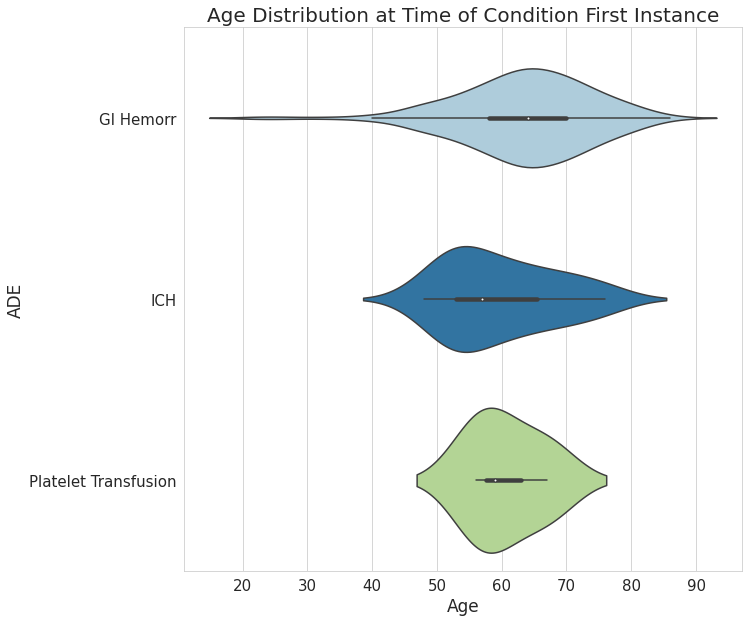

In [199]:
fig,ax = plt.subplots(1,1, figsize = (10,10))
sns.set_style("darkgrid")
sns.violinplot(x="age", y="condition", data=age_condition)
ax.set_title('Age Distribution at Time of Condition First Instance', fontsize = 20)
ax.set_ylabel('ADE', fontsize = 17)
ax.set_xlabel('Age', fontsize = 17)
ax.tick_params(labelsize = 15)
plt.show()

## ADE Classification Rate

In [200]:
overlap_dfs = [overlap_df2, overlap_df3, overlap_df5]
period_ct_dfs = []
for i in range(len(overlap_dfs)):
    if i!=2:
        overlap_dfs[i]['period'] = (overlap_dfs[i]['condition_start_date'] - overlap_dfs[i]['index_date']
                                   )/np.timedelta64(1, 'M')

        period_cts = overlap_dfs[i].groupby('period').count().reset_index()[['period', 'drug_name']]
        period_cts['cum_cts'
                  ] = overlap_dfs[i].groupby('period').count().reset_index()['drug_name'].cumsum().tolist()
        period_cts.columns = ['period', 'count', 'cum_cts']
        period_ct_dfs.append(period_cts)
    else:
        overlap_dfs[i]['period'] = (pd.to_datetime(overlap_dfs[i]['procedure_date'], format='%Y-%m-%d'
                                                  ) - overlap_dfs[i]['index_date']
                                   )/np.timedelta64(1, 'M')

        period_cts = overlap_dfs[i].groupby('period').count().reset_index()[['period', 'drug_name']]
        period_cts['cum_cts'] = overlap_dfs[i].groupby('period').count().reset_index()['drug_name'
                                                                                      ].cumsum().tolist()
        period_cts.columns = ['period', 'count', 'cum_cts']
        period_ct_dfs.append(period_cts)

In [201]:
# overlap_dfs = [overlap_df2, overlap_df3, overlap_df5]
# period_ct_dfs = []
# for i in range(len(overlap_dfs)):
#     if i!=2:
overlap_df2['period'] = (overlap_df2['condition_start_date'] - overlap_df2['index_date']
                            )/np.timedelta64(1, 'M')

period_cts = overlap_df2.groupby(['period', 'sex_at_birth']).count().reset_index()[['period', 
                                                                                    'drug_name', 'sex_at_birth']]

# period_cts['cum_cts'
#             ] = overlap_dfs[i].groupby('period').count().reset_index()['drug_name'].cumsum().tolist()
# period_cts.columns = ['period', 'count', 'cum_cts']
# period_ct_dfs.append(period_cts)
per_male = period_cts[period_cts.sex_at_birth == 'Male']
per_female = period_cts[period_cts.sex_at_birth == 'Female']
per_other = period_cts[period_cts.sex_at_birth != 'Male'][period_cts.sex_at_birth != 'Female']

male_cum = overlap_df2.groupby(['period','sex_at_birth']).count().reset_index()[['period', 'sex_at_birth', 'drug_name']]
per_male['cum_cts'] = male_cum[male_cum.sex_at_birth == 'Male']['drug_name'].cumsum().tolist()

female_cum = overlap_df2.groupby(['period','sex_at_birth']).count().reset_index()[['period', 'sex_at_birth', 
                                                                                   'drug_name']]
per_female['cum_cts'] = female_cum[female_cum.sex_at_birth == 'Female']['drug_name'].cumsum().tolist()

other_cum = overlap_df2.groupby(['period','sex_at_birth']).count().reset_index()[['period', 'sex_at_birth', 
                                                                                   'drug_name']]
per_other['cum_cts'] = female_cum[female_cum.sex_at_birth != 'Female'][female_cum.sex_at_birth != 'Male'][
    'drug_name'].cumsum().tolist()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


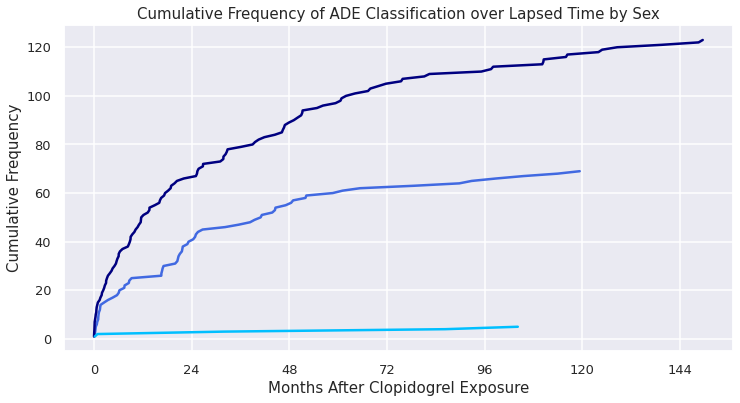

In [202]:
sns.set_style("darkgrid")
sns.set_context("talk")
fig, ax = plt.subplots(1, 1, figsize=(12,6))

sns.lineplot(ax = ax, data=per_female, x="period", y="cum_cts", linewidth=2.5, color='royalblue')
sns.lineplot(ax = ax, data=per_male, x="period", y="cum_cts", linewidth=2.5, color='navy')
sns.lineplot(ax = ax, data=per_other, x="period", y="cum_cts", linewidth=2.5, color='deepskyblue')

ax.set_xlabel('Months After Clopidogrel Exposure', fontsize = 15)
ax.set_ylabel('Cumulative Frequency', fontsize = 15)
ax.set_title('Cumulative Frequency of ADE Classification over Lapsed Time by Sex', fontsize = 15)
ax.tick_params(labelsize = 13)
ax.set_xticks(range(0,160,24))

plt.show()

In [203]:
gi_hem = period_ct_dfs[0].describe()[['cum_cts']]
gi_hem.reset_index(inplace = True)
gi_hem.columns = ['Statistic', 'GI_Hemorr']

ich = period_ct_dfs[1].describe()[['cum_cts']]
ich.reset_index(inplace = True)
ich.columns = ['Statistic', 'ICH']


platelet = period_ct_dfs[2].describe()[['cum_cts']]
platelet.reset_index(inplace = True)
platelet.columns = ['Statistic', 'Platelet_Transusion']


month_stats = gi_hem.join(ich.set_index('Statistic'), on = 'Statistic').join(
    platelet.set_index('Statistic'), on = 'Statistic')

month_stats

,Statistic,GI_Hemorr,ICH,Platelet_Transusion
0,count,183.000000,17.000000,3.0
1,mean,103.278689,10.470588,2.0
2,std,55.945754,5.767556,1.0
3,min,1.000000,1.000000,1.0
4,25%,56.500000,6.000000,1.5
5,50%,105.000000,11.000000,2.0
6,75%,151.500000,15.000000,2.5
7,max,197.000000,19.000000,3.0


In [204]:
# sns.set_style("darkgrid")
# sns.set_context("talk")
# fig, ax = plt.subplots(1, 1, figsize=(12,6))

# sns.lineplot(ax = ax, data=period_cts, x="period", y="cum_cts", linewidth=2.5, color='red')
# ax.set_xlabel('Months After Clopidogrel Exposure', fontsize = 15)
# ax.set_ylabel('Cumulative Frequency', fontsize = 15)
# ax.set_title('Cumulative Frequency of ADE Classification by Lapsed Time', fontsize = 15)
# ax.tick_params(labelsize = 13)
# # plt.setp(l,linewidth=5)

# plt.show()

# Survey Data

In [205]:
# create test cohort to test functions
test_cohort_sql = f"""
    with cohort as (
        select * from {os.environ["WORKSPACE_CDR"]}.person limit 1000
    )
    select distinct person_id from cohort
    """
test_cohort = list(pd.read_gbq(test_cohort_sql, dialect="standard")['person_id'].values)
#     insert_values_sql0 = ",".join([f"({x})" for x in test_cohort])

# insert_values_sql1 = ",".join([f"({x})" for x in all_comorbidities_condition_codes[1200:]])
# cohort_sql = f"""
# CREATE TEMP TABLE cohort
# (
#   person_id INT64
# );
# INSERT INTO cohort
# VALUES {insert_values_sql0};


# SELECT * FROM cohort;

# """
# cohort = pd.read_gbq(cohort_sql, dialect="standard")

# test_cohort

In [206]:
p_id = clopidogrel_3.person_id.to_list()

In [207]:
# Define PROMIS_health_concept_set_sql
questions_concept_set_sql = f"""
    question_concept_id IN (
               1585723, 1585741, 1585747, 1585748 -- Physical Health
               , 1585760, 1585729, 1585717, 1585735 -- Mental Health
               , 1585711
               , 1585811, 1585784 -- Menstrual/Pregnant
               , 1585803, 1585806
               --Lifestyle Qs
               , 1585857, 1585860, 1585864, 1585867, 1585870 
               , 1585873, 1586159, 1586162, 1586166, 1586174
               , 1586177, 1586182, 1586185, 1586190, 1586193 -- smoking
               , 1586198, 1586201, 1586207, 1586213, 1585636
               , 1585650, 1585656, 1585662, 1585668, 1585674
               , 1585680, 1585686, 1585692, 1585698, 1585704
               --Basics
               , 1585940, 1585892, 1585386
            )
"""

In [208]:
# Define SQL query for add Overall Health survey
add_health_survey_sql = f"""
    with_health_survey as (
        select a.person_id, answer, 
        cast(cast(question_concept_id as int64) as string) as question_concept_id,  
        survey_date,
        cast(cast(answer_concept_id as int64) as string) as answer_concept_id, 
        question from cohort a
        inner join (
            SELECT
                answer.person_id, answer.answer,
                answer.question_concept_id, extract(date from answer.survey_datetime) as survey_date,
                answer.answer_concept_id, answer.question    
            FROM {os.environ["WORKSPACE_CDR"]}.ds_survey answer 
            WHERE
                (
                    {questions_concept_set_sql}
                )
            )  b
            on a.person_id = b.person_id
    )
"""

In [209]:
# cohort is list of person_ids 
def get_survey_data_for_cohort(cohort):
    insert_values_sql0 = ",".join([f"({x})" for x in cohort])
    health_sql = f"""
    CREATE TEMP TABLE cohort
    (
      person_id INT64
    );
    INSERT INTO cohort
    VALUES {insert_values_sql0};


    SELECT * FROM cohort;
    with
    {add_health_survey_sql}
    select * from with_health_survey
    """
    health = pd.read_gbq(health_sql, dialect="standard")
    return health

In [210]:
survey_data1 = get_survey_data_for_cohort(p_id[:1000])
survey_data2 = get_survey_data_for_cohort(p_id[1000:])

In [211]:
survey_data2.shape

(23216, 6)

In [212]:
# 25752 + 23286 = 49038
survey_data = survey_data1.append(survey_data2)

In [213]:
# define helper functions
def get_questions(df):
    questions = list(df['question'].unique())
    this_df = df[['person_id','question']][df[['person_id','question']].duplicated()].sort_values('person_id')
    multiple_choice = list(this_df['question'].unique())
    single_choice = [x for x in questions if x not in multiple_choice]
    return (multiple_choice, single_choice)

def create_single_choice_columns(df, single_choice):
    this_df = df.copy()
    this_df = this_df[['person_id','question', 'answer']]
    this_df = this_df[this_df['question'].isin(single_choice)]
    this_df = this_df.pivot(index='person_id', columns="question", values="answer")
    return this_df

def create_multiple_choice_columns(df, multiple_choice):
    this_df = df.copy()
    this_df = this_df[['person_id','question', 'answer']]
    this_df = this_df[this_df['question'].isin(multiple_choice)]
    this_df['question (answer)'] = this_df['question'] + " = " + this_df['answer']
#     this_df['question (answer)'] = this_df['answer']
    this_df = this_df[['person_id','question (answer)']]
    this_df['indicator'] = 1
    this_df = this_df.pivot(index='person_id', columns="question (answer)", values="indicator")
    this_df = this_df.fillna(0)
    this_df = this_df.astype(int)
    return(this_df)

def create_indicator_df(df):
    mult_choice, sing_choice = get_questions(df)
    sing_df = create_single_choice_columns(df, sing_choice)
    mult_df = create_multiple_choice_columns(df, mult_choice)
    output_df = sing_df.join(mult_df, on='person_id', how='outer')
    return(output_df)
    

In [214]:
survey_temp = survey_data[['person_id', 'answer', 'question']]

In [215]:
survey_temp = survey_temp.pivot_table(index="person_id", columns='question', values='answer', aggfunc='sum')

In [216]:
survey_temp

question,Alcohol: 6 or More Drinks Occurrence,Alcohol: Alcohol Participant,Alcohol: Average Daily Drink Count,Alcohol: Drink Frequency Past Year,Attempt Quit Smoking: Completely Quit Age,Cigar Smoking: Cigar Smoke Participant,Cigar Smoking: Current Cigar Frequency,Education Level: Highest Grade,Electronic Smoking: Electric Smoke Participant,Hookah Smoking: Current Hookah Frequency,...,Recreational Drug Use: Which Drugs Used,Smokeless Tobacco: Smokeless Tobacco Frequency,Smokeless Tobacco: Smokeless Tobacco Participant,Smoking: 100 Cigs Lifetime,Smoking: Average Daily Cigarette Number,Smoking: Current Daily Cigarette Number,Smoking: Daily Smoke Starting Age,Smoking: Number Of Years,Smoking: Serious Quit Attempt,Smoking: Smoke Frequency
person_id,,,,,,,,,,,,,,,,,,,,,
1000222,6 or More Drinks Occurrence: Never In Last Year,Alcohol Participant: Yes,Average Daily Drink Count: 1 or 2,Drink Frequency Past Year: Monthly Or Less,NaN,Cigar Smoke Participant: Yes,Current Cigar Frequency: Not At All,College graduate or advanced degree,Electric Smoke Participant: No,NaN,...,Which Drugs Used: Prescription Opioids UseWhic...,NaN,Smokeless Tobacco Participant: No,100 Cigs Lifetime: No,NaN,NaN,NaN,NaN,NaN,NaN
1000329,6 or More Drinks Occurrence: Never In Last Year,Alcohol Participant: Yes,Average Daily Drink Count: 1 or 2,Drink Frequency Past Year: 2 to 4 Per Month,NaN,Cigar Smoke Participant: No,NaN,College graduate or advanced degree,Electric Smoke Participant: No,NaN,...,Which Drugs Used: Marijuana Use,NaN,Smokeless Tobacco Participant: No,100 Cigs Lifetime: No,NaN,NaN,NaN,NaN,NaN,NaN
1002502,6 or More Drinks Occurrence: Never In Last Year,Alcohol Participant: Yes,Average Daily Drink Count: 1 or 2,Drink Frequency Past Year: 4 or More Per Week,NaN,Cigar Smoke Participant: Yes,Current Cigar Frequency: Not At All,Highest Grade: College One to Three,Electric Smoke Participant: No,NaN,...,Which Drugs Used: None Of These Drugs,NaN,Smokeless Tobacco Participant: No,100 Cigs Lifetime: Yes,NaN,NaN,NaN,NaN,Serious Quit Attempt: Attempt Quit Smoking,Smoke Frequency: Not At All
1003851,NaN,Alcohol Participant: Yes,NaN,Drink Frequency Past Year: Never,NaN,Cigar Smoke Participant: Yes,Current Cigar Frequency: Not At All,Highest Grade: College One to Three,Electric Smoke Participant: No,NaN,...,Which Drugs Used: Marijuana Use,NaN,Smokeless Tobacco Participant: No,100 Cigs Lifetime: Yes,NaN,NaN,NaN,NaN,Serious Quit Attempt: Attempt Quit Smoking,Smoke Frequency: Not At All
1004776,NaN,Alcohol Participant: Yes,NaN,Drink Frequency Past Year: Never,NaN,Cigar Smoke Participant: Yes,PMI: Dont Know,Highest Grade: Twelve Or GED,Electric Smoke Participant: No,NaN,...,Which Drugs Used: Marijuana Use,NaN,Smokeless Tobacco Participant: No,100 Cigs Lifetime: Yes,NaN,NaN,NaN,NaN,Serious Quit Attempt: Attempt Quit Smoking,Smoke Frequency: Not At All
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3510164,6 or More Drinks Occurrence: Never In Last Year,Alcohol Participant: Yes,Average Daily Drink Count: 3 or 4,Drink Frequency Past Year: Monthly Or Less,NaN,Cigar Smoke Participant: Yes,Current Cigar Frequency: Not At All,Highest Grade: Twelve Or GED,Electric Smoke Participant: Yes,NaN,...,Which Drugs Used: Marijuana Use,NaN,Smokeless Tobacco Participant: No,100 Cigs Lifetime: No,NaN,NaN,NaN,NaN,NaN,NaN
3513406,6 or More Drinks Occurrence: Never In Last Year,Alcohol Participant: Yes,Average Daily Drink Count: 1 or 2,Drink Frequency Past Year: 2 to 4 Per Month,NaN,Cigar Smoke Participant: No,NaN,College graduate or advanced degree,Electric Smoke Participant: No,NaN,...,Which Drugs Used: None Of These Drugs,NaN,Smokeless Tobacco Participant: No,100 Cigs Lifetime: No,NaN,NaN,NaN,NaN,NaN,NaN
3516867,6 or More Drinks Occurrence: Weekly,Alcohol Participant: Yes,Average Daily Drink Count: 5 or 6,Drink Frequency Past Year: 4 or More Per Week,NaN,Cigar Smoke Participant: No,NaN,College graduate or advanced degree,Electric Smoke Participant: Ye

In [217]:
survey_temp_col = list(survey_temp.columns)
to_delete = list()
for i in survey_temp_col:
    sum = survey_temp[survey_temp[i].isnull()].shape[0]
    sum += survey_temp[survey_temp[i] == 'PMI: Prefer Not To Answer'].shape[0]
    sum += survey_temp[survey_temp[i] == 'PMI: Skip'].shape[0]
    if ((sum/survey_temp.shape[0]) >= 0.5):
        to_delete.append(i)

In [218]:
for i in to_delete:
    del survey_temp[i]

In [219]:
survey_temp_col = list(survey_temp.columns)
to_delete = list()
for i in survey_temp_col:
    sum = survey_temp[survey_temp[i].isnull()].shape[0]
    sum += survey_temp[survey_temp[i] == 'PMI: Prefer Not To Answer'].shape[0]
    sum += survey_temp[survey_temp[i] == 'PMI: Skip'].shape[0]
    if ((sum/survey_temp.shape[0]) >= 0.2):
        to_delete.append((i, sum/1906))
survey_temp = survey_temp.replace({'PMI: Skip': np.nan, 'PMI: Prefer Not To Answer': np.nan, 
                                   'PMI: Dont Know': np.nan})  

In [220]:
del survey_temp['Alcohol: 6 or More Drinks Occurrence']
del survey_temp['Smoking: Serious Quit Attempt']

In [221]:
survey_temp.reset_index(inplace=True)
survey_col = list(survey_temp.columns)

In [222]:
# Change the following columns to ordered variables

# 'Alcohol: Drink Frequency Past Year'
dict1 = {'PMI: Skip': np.nan, 'PMI: Prefer Not To Answer': np.nan, 'NA': np.nan,
         'Drink Frequency Past Year: Never':0, 'Drink Frequency Past Year: Monthly Or Less': 1,
         'Drink Frequency Past Year: 2 to 4 Per Month': 2, 'Drink Frequency Past Year: 2 to 3 Per Week': 3,
         'Drink Frequency Past Year: 4 or More Per Week': 4
        }
survey_temp = survey_temp.replace({'Alcohol: Drink Frequency Past Year': dict1})

# 'Education Level: Highest Grade'
dict1 = {'PMI: Skip': np.nan, 'PMI: Prefer Not To Answer': np.nan,
         'Less than a high school degree or equivalent':0, 'Highest Grade: Twelve Or GED': 1,
         'Highest Grade: College One to Three': 2, 'College graduate or advanced degree': 3,
        }
survey_temp = survey_temp.replace({'Education Level: Highest Grade': dict1})

# Overall Health: Average Fatigue 7 Days
dict1 = {'PMI: Skip': np.nan, 'Average Fatigue 7 Days: None': 0, 'Average Fatigue 7 Days: Mild': 1,
         'Average Fatigue 7 Days: Moderate':2, 'Average Fatigue 7 Days: Severe': 3,
         'Average Fatigue 7 Days: Very Severe': 4
        }
survey_temp = survey_temp.replace({'Overall Health: Average Fatigue 7 Days': dict1})

# Replace: Overall Health: Emotional Problem 7 Days
dict1 = {'PMI: Skip': np.nan, 'Emotional Problem 7 Days: Never': 0, 'Emotional Problem 7 Days: Rarely': 1,
         'Emotional Problem 7 Days: Sometimes': 2, 'Emotional Problem 7 Days: Often': 3,
         'Emotional Problem 7 Days: Always': 4
        }
survey_temp = survey_temp.replace({'Overall Health: Emotional Problem 7 Days': dict1})

# Replace: Overall Health: General Health
dict1 = {'PMI: Skip': np.nan, 'General Health: Poor': 0, 'General Health: Fair': 1,
         'General Health: Good': 2, 'General Health: Very Good': 3,
         'General Health: Excellent': 4
        }
survey_temp = survey_temp.replace({'Overall Health: General Health': dict1})

# Replace: Overall Health: General Mental Health
dict1 = {'PMI: Skip': np.nan, 'General Mental Health: Poor': 0, 'General Mental Health: Fair': 1,
         'General Mental Health: Good': 2, 'General Mental Health: Very Good': 3,
         'General Mental Health: Excllent': 4, 'General Mental Health: Excellent':4
        }
survey_temp = survey_temp.replace({'Overall Health: General Mental Health': dict1})

# Overall Health: General Quality
dict1 = {'PMI: Skip': np.nan, 'General Quality: Poor': 0, 'General Quality: Fair': 1,
         'General Quality: Good': 2, 'General Quality: Very Good': 3,
         'General Quality: Excellent': 4
        }
survey_temp = survey_temp.replace({'Overall Health: General Quality': dict1})

# 'Overall Health: Average Pain 7 Days'
dict1 = {'PMI: Skip': np.nan}
survey_temp = survey_temp.replace({'Overall Health: Average Pain 7 Days': dict1})
survey_temp['Overall Health: Average Pain 7 Days'] = survey_temp[
    'Overall Health: Average Pain 7 Days'].astype(float)

# 'Overall Health: Everyday Activities'
survey_temp = survey_temp.replace({'Overall Health: Everyday Activities': 
                {'Everyday Activities: Completely': 4, 
                 'Everyday Activities: Mostly': 3,
                 'Everyday Activities: Moderately': 2, 
                 'Everyday Activities: A Little': 1, 
                 'Everyday Activities: Not At All': 0,
                 'PMI: Skip': -1}})

# 'Overall Health: General Physical Health'
survey_temp = survey_temp.replace({
    'Overall Health: General Physical Health': {
        'General Physical Health: Very Good': 3,
        'General Physical Health: Good': 2, 
        'PMI: Skip': np.nan,
        'General Physical Health: Fair': 1, 
        'General Physical Health: Poor': 0,
        'General Physical Health: Excellent': 4}
})

# "Overall Health: Social Satisfaction"
xdict1 = {
    "Social Satisfaction: Very Good" : 4,
    "Social Satisfaction: Good" : 3,
    "Social Satisfaction: Excellent" : 2,
    "Social Satisfaction: Fair" : 1,
    "Social Satisfaction: Poor" : 0,
    "PMI: Skip" : np.nan,
    'NA': np.nan
}

survey_temp = survey_temp.replace({"Overall Health: Social Satisfaction": xdict1})

# 'Alcohol: Average Daily Drink Count'
dict1 = {'PMI: Skip': -1, 'PMI: Prefer Not To Answer': np.nan, 'NA': np.nan,
         'Average Daily Drink Count: 1 or 2':0, 'Average Daily Drink Count: 3 or 4': 1,
         'Average Daily Drink Count: 5 or 6': 2, 'Average Daily Drink Count: 7 to 9': 3,
         'Average Daily Drink Count: 10 or More': 4
        }
survey_temp = survey_temp.replace({'Alcohol: Average Daily Drink Count': dict1})

In [223]:

survey_temp

question,person_id,Alcohol: Alcohol Participant,Alcohol: Average Daily Drink Count,Alcohol: Drink Frequency Past Year,Cigar Smoking: Cigar Smoke Participant,Education Level: Highest Grade,Electronic Smoking: Electric Smoke Participant,Hookah Smoking: Hookah Smoke Participant,Insurance: Health Insurance,Marital Status: Current Marital Status,...,Overall Health: General Health,Overall Health: General Mental Health,Overall Health: General Physical Health,Overall Health: General Quality,Overall Health: Organ Transplant,Overall Health: Social Satisfaction,Recreational Drug Use: Which Drugs Used,Smokeless Tobacco: Smokeless Tobacco Participant,Smoking: 100 Cigs Lifetime,Smoking: Smoke Frequency
0,1000222,Alcohol Participant: Yes,0.0,1.0,Cigar Smoke Participant: Yes,3.0,Electric Smoke Participant: No,Hookah Smoke Participant: No,Health Insurance: Yes,Current Marital Status: Married,...,3.0,4.0,3.0,4.0,Organ Transplant: No,4.0,Which Drugs Used: Prescription Opioids UseWhic...,Smokeless Tobacco Participant: No,100 Cigs Lifetime: No,NaN
1,1000329,Alcohol Participant: Yes,0.0,2.0,Cigar Smoke Participant: No,3.0,Electric Smoke Participant: No,Hookah Smoke Participant: No,Health Insurance: Yes,Current Marital Status: Married,...,2.0,4.0,2.0,4.0,Organ Transplant: No,2.0,Which Drugs Used: Marijuana Use,Smokeless Tobacco Participant: No,100 Cigs Lifetime: No,NaN
2,1002502,Alcohol Participant: Yes,0.0,4.0,Cigar Smoke Participant: Yes,2.0,Electric Smoke Participant: No,Hookah Smoke Participant: No,Health Insurance: Yes,Current Marital Status: Married,...,3.0,4.0,3.0,3.0,Organ Transplant: No,2.0,Which Drugs Used: None Of These Drugs,Smokeless Tobacco Participant: No,100 Cigs Lifetime: Yes,Smoke Frequency: Not At All
3,1003851,Alcohol Participant: Yes,NaN,0.0,Cigar Smoke Participant: Yes,2.0,Electric Smoke Participant: No,Hookah Smoke Participant: No,Health Insurance: Yes,Current Marital Status: Widowed,...,1.0,3.0,NaN,2.0,NaN,3.0,Which Drugs Used: Marijuana Use,Smokeless Tobacco Participant: No,100 Cigs Lifetime: Yes,Smoke Frequency: Not At All
4,1004776,Alcohol Participant: Yes,NaN,0.0,Cigar Smoke Participant: Yes,1.0,Electric Smoke Participant: No,Hookah Smoke Participant: No,Health Insurance: Yes,Current Marital Status: Married,...,3.0,3.0,3.0,3.0,Organ Transplant: No,4.0,Which Drugs Used: Marijuana Use,Smokeless Tobacco Participant: No,100 Cigs Lifetime: Yes,Smoke Frequency: Not At All
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1901,3510164,Alcohol Participant: Yes,1.0,1.0,Cigar Smoke Participant: Yes,1.0,Electric Smoke Participant: Yes,Hookah Smoke Participant: No,Health Insurance: Yes,Current Marital Status: Living With Partner,...,1.0,3.0,2.0,2.0,Organ Transplant: No,4.0,Which Drugs Used: Marijuana Use,Smokeless Tobacco Participant: No,100 Cigs Lifetime: No,NaN
1902,3513406,Alcohol Participant: Yes,0.0,2.0,Cigar Smoke Participant: No,3.0,Electric Smoke Participant: No,Hookah Smoke Participant: No,Health Insurance: Yes,Current Marital Status: Married,...,3.0,2.0,2.0,3.0,Organ Transplant: No,3.0,Which Drugs Used: None Of These Drugs,Smokeless Tobacco Participant: No,100 Cigs Lifetime: No,NaN
1903,3516867,Alcohol Participant: Yes,2.0,4.0,Cigar Smoke Participant: No,3.0,Electric Smoke Participant: Yes,Hookah Smoke Participant: No,Health Insurance: Yes,Current Marital Status: Married,...,1.0,1.0,0.0,1.0,Organ Transplant: No,3.0,Which Drugs Used: Marijuana Use,Smokeless Tobacco Participant: No,100 Cigs Lifetime: Yes,Smoke Frequency: Every Day
1904,3517408,Alcohol Participant: Yes,0.0,1.0,Cigar Smoke Participant: No,3.0,Electric Smoke Participant: No,Hookah Smoke Participant: No,Health Insurance: Yes,Current Marital Status: Married,...,2.0,4.0,2.0,3.0,Organ Transplant: No,4.0,Which Drugs Used: None Of These Drugs,Smokeless Tobacco Participant: No,100 Cigs Lifetime: No,NaN


In [224]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_mean.fit(survey_temp)
survey_imp = imp_mean.transform(survey_temp)

survey_filled = pd.DataFrame(survey_imp, columns = survey_col)
#imp.fit(health.drop(columns = 'Marital Status: Current Marital Status'))
#IterativeImputer(random_state=0)
#health_np = np.round(imp.transform(health.drop(columns = 'Marital Status: Current Marital Status')))

In [225]:
health = create_indicator_df(survey_data)
health.columns

Index(['Alcohol: 6 or More Drinks Occurrence', 'Alcohol: Alcohol Participant',
       'Alcohol: Average Daily Drink Count',
       'Alcohol: Drink Frequency Past Year',
       'Attempt Quit Smoking: Completely Quit Age',
       'Cigar Smoking: Cigar Smoke Participant',
       'Cigar Smoking: Current Cigar Frequency',
       'Education Level: Highest Grade',
       'Electronic Smoking: Electric Smoke Participant',
       'Hookah Smoking: Current Hookah Frequency',
       'Hookah Smoking: Hookah Smoke Participant',
       'Insurance: Health Insurance', 'Marital Status: Current Marital Status',
       'Overall Health: Average Fatigue 7 Days',
       'Overall Health: Average Pain 7 Days',
       'Overall Health: Emotional Problem 7 Days',
       'Overall Health: Everyday Activities', 'Overall Health: General Health',
       'Overall Health: General Mental Health',
       'Overall Health: General Physical Health',
       'Overall Health: General Quality', 'Overall Health: Menstrual Stopped'

In [226]:
# Combine 'Recreational Drug Use: Which Drugs Used = PMI: Prefer Not To Answer' and 
# 'Recreational Drug Use: Which Drugs Used = PMI: Skip'
health['Recreational Drug Use: Which Drugs Used = Null'
      ] = health['Recreational Drug Use: Which Drugs Used = PMI: Prefer Not To Answer'
                ] + health['Recreational Drug Use: Which Drugs Used = PMI: Skip']
health[['Recreational Drug Use: Which Drugs Used = Null', 
        'Recreational Drug Use: Which Drugs Used = PMI: Prefer Not To Answer', 
        'Recreational Drug Use: Which Drugs Used = PMI: Skip']]
health.drop(columns = 'Recreational Drug Use: Which Drugs Used = PMI: Prefer Not To Answer', inplace = True)
health.drop(columns = 'Recreational Drug Use: Which Drugs Used = PMI: Skip', inplace = True)

# Column: 'Cigar Smoking: Current Cigar Frequency'
health.drop(columns = 'Cigar Smoking: Current Cigar Frequency', inplace = True)

def binaryConv(colName, health = health):
    bin_dic = {}
    y_str = health[health[colName].str.contains("Yes")
                  ][colName].tolist()[1]
    n_str = health[health[colName].str.contains("No")
                  ][colName].tolist()[1]
    for i in health[colName].unique():
        if i != y_str and i!= n_str:
            bin_dic[i] = -1
    bin_dic[y_str] = 1
    bin_dic[n_str] = 0
    health = health.replace({colName: bin_dic})
    return health

# Column: 'Cigar Smoking: Cigar Smoke Participant'
health = binaryConv('Cigar Smoking: Cigar Smoke Participant', health)

# # Column: 'Overall Health: Average Pain 7 Days'
# health = health.replace({'Overall Health: Average Pain 7 Days': {'PMI: Skip': -1}})

dict1 = {'PMI: Skip': -1}
health = health.replace({'Overall Health: Average Pain 7 Days': dict1})

# Column: 'Overall Health: Everyday Activities'
health = health.replace({'Overall Health: Everyday Activities': 
                {'Everyday Activities: Completely': 4, 
                 'Everyday Activities: Mostly': 3,
                 'Everyday Activities: Moderately': 2, 
                 'Everyday Activities: A Little': 1, 
                 'Everyday Activities: Not At All': 0,
                 'PMI: Skip': -1}})

# Column: 'Overall Health: General Physical Health'
health = health.replace({
    'Overall Health: General Physical Health': {
        'General Physical Health: Very Good': 3,
        'General Physical Health: Good': 2, 
        'PMI: Skip': -1,
        'General Physical Health: Fair': 1, 
        'General Physical Health: Poor': 0,
        'General Physical Health: Excellent': 4}
})

# Column: 'Past 3 Month Use Frequency: Sedative 3 Month Use'
health.drop(columns = 'Past 3 Month Use Frequency: Sedative 3 Month Use', inplace = True)

# Column: 'Smoking: '100 Cigs Lifetime'
health = binaryConv('Smoking: 100 Cigs Lifetime', health)

# Column: 'Smoking: 'Average Daily Cigarette Number'
health.drop(columns = 'Smoking: Average Daily Cigarette Number', inplace = True)

# Column: 'Smoking: 'Daily Smoke Starting Age'
health.drop(columns = 'Smoking: Daily Smoke Starting Age', inplace = True)

# Column: 'Smoking: 'Smoking: Number Of Years'
health.drop(columns = 'Smoking: Number Of Years', inplace = True)

# Column: 'Smoking: 'Smoking: Smoke Frequency'
health.drop(columns = 'Smoking: Smoke Frequency', inplace = True)

In [227]:
# Delete given columns
health = health.drop(['Overall Health: Menstrual Stopped', 
              'Hookah Smoking: Current Hookah Frequency', 
              'Attempt Quit Smoking: Completely Quit Age',
              'Alcohol: 6 or More Drinks Occurrence', 
              'Alcohol: Average Daily Drink Count'], axis=1)

# fill NaN values as NA
health = health.fillna('NA')

# Replace: Alcohol: Alcohol Participant
dict1 = {'Alcohol Participant: Yes': 1,
      'Alcohol Participant: No': 0,
      'PMI: Skip': -1,
      'PMI: Prefer Not To Answer': -1}
health = health.replace({'Alcohol: Alcohol Participant': dict1})

# Replace: Alcohol: Drink Frequency Past Year
dict1 = {'PMI: Skip': -1, 'PMI: Prefer Not To Answer': -1, 'NA': -1,
         'Drink Frequency Past Year: Never':0, 'Drink Frequency Past Year: Monthly Or Less': 1,
         'Drink Frequency Past Year: 2 to 4 Per Month': 2, 'Drink Frequency Past Year: 2 to 3 Per Week': 3,
         'Drink Frequency Past Year: 4 or More Per Week': 4
        }
health = health.replace({'Alcohol: Drink Frequency Past Year': dict1})

# Replace: Education Level: Highest Grade
dict1 = {'PMI: Skip': -1, 'PMI: Prefer Not To Answer': -1,
         'Less than a high school degree or equivalent':0, 'Highest Grade: Twelve Or GED': 1,
         'Highest Grade: College One to Three': 2, 'College graduate or advanced degree': 3,
        }
health = health.replace({'Education Level: Highest Grade': dict1})

# Replace: Electronic Smoking: Electric Smoke Participant
dict1 = {'Electric Smoke Participant: Yes': 1,
      'Electric Smoke Participant: No': 0,
      'PMI: Skip': -1,
      'PMI: Prefer Not To Answer': -1,
        'PMI: Dont Know':-1}
health = health.replace({'Electronic Smoking: Electric Smoke Participant': dict1})

# Replace: Hookah Smoking: Hookah Smoke Participant'
dict1 = {'Hookah Smoke Participant: Yes': 1,
      'Hookah Smoke Participant: No': 0,
      'PMI: Skip': -1,
      'PMI: Prefer Not To Answer': -1,
        'PMI: Dont Know':-1}
health = health.replace({'Hookah Smoking: Hookah Smoke Participant': dict1})

# Replace: Insurance: Health Insurance
dict1 = {'Health Insurance: Yes': 1,
      'Health Insurance: No': 0,
      'PMI: Skip': -1,
      'PMI: Prefer Not To Answer': -1,
        'PMI: Dont Know':-1,
        'NA':-1}
health = health.replace({'Insurance: Health Insurance': dict1})

# Replace: Marital Status: Current Marital Status
dict1 = {'Current Marital Status: Married': 'Married',
      'Current Marital Status: Widowed': 'Widowed',
      'Current Marital Status: Divorced': 'Divorced',
      'Current Marital Status: Living With Partner': 'Living With Partner',
        'Current Marital Status: Never Married': 'Never Married',
        'Current Marital Status: Separated':'Separated',
        'PMI: Prefer Not To Answer': 'Null',
        'PMI: Skip': 'Null'}
health = health.replace({'Marital Status: Current Marital Status': dict1})

# Replace: Overall Health: Average Fatigue 7 Days
dict1 = {'PMI: Skip': -1, 'Average Fatigue 7 Days: None': 0, 'Average Fatigue 7 Days: Mild': 1,
         'Average Fatigue 7 Days: Moderate':2, 'Average Fatigue 7 Days: Severe': 3,
         'Average Fatigue 7 Days: Very Severe': 4
        }
health = health.replace({'Overall Health: Average Fatigue 7 Days': dict1})

# Replace: Overall Health: Emotional Problem 7 Days
dict1 = {'PMI: Skip': -1, 'Emotional Problem 7 Days: Never': 0, 'Emotional Problem 7 Days: Rarely': 1,
         'Emotional Problem 7 Days: Sometimes': 2, 'Emotional Problem 7 Days: Often': 3,
         'Emotional Problem 7 Days: Always': 4
        }
health = health.replace({'Overall Health: Emotional Problem 7 Days': dict1})

# Replace: Overall Health: General Health
dict1 = {'PMI: Skip': -1, 'General Health: Poor': 0, 'General Health: Fair': 1,
         'General Health: Good': 2, 'General Health: Very Good': 3,
         'General Health: Excellent': 4
        }
health = health.replace({'Overall Health: General Health': dict1})

# Replace: Overall Health: General Mental Health
dict1 = {'PMI: Skip': -1, 'General Mental Health: Poor': 0, 'General Mental Health: Fair': 1,
         'General Mental Health: Good': 2, 'General Mental Health: Very Good': 3,
         'General Mental Health: Excllent': 4, 'General Mental Health: Excellent':4
        }
health = health.replace({'Overall Health: General Mental Health': dict1})

# Replace: Overall Health: General Quality
dict1 = {'PMI: Skip': -1, 'General Quality: Poor': 0, 'General Quality: Fair': 1,
         'General Quality: Good': 2, 'General Quality: Very Good': 3,
         'General Quality: Excellent': 4
        }
health = health.replace({'Overall Health: General Quality': dict1})

In [228]:
# *'Overall Health: Organ Transplant'*

xdict = {
    "Organ Transplant: No" : 0,
    "Organ Transplant: Yes" : 1,
    "PMI: Skip" : -1,
    "PMI: Dont Know" : -1,
    'NA': -1
}

health = health.replace({"Overall Health: Organ Transplant": xdict})



#### * 'Overall Health: Social Satisfaction'*

xdict1 = {
    "Social Satisfaction: Very Good" : 4,
    "Social Satisfaction: Good" : 3,
    "Social Satisfaction: Excellent" : 2,
    "Social Satisfaction: Fair" : 1,
    "Social Satisfaction: Poor" : 0,
    "PMI: Skip" : -1,
    'NA': -1
}

health = health.replace({"Overall Health: Social Satisfaction": xdict1})



#### * 'Smokeless Tobacco: Smokeless Tobacco Participant' *

xdict1 = {
    "Smokeless Tobacco Participant: No" : 0,
    "Smokeless Tobacco Participant: Yes" : 1,
    "PMI: Skip" : -1,
    "PMI: Prefer Not To Answer" : -1,
    "PMI: Dont Know" : -1,
    'NA': -1
}

health = health.replace({'Smokeless Tobacco: Smokeless Tobacco Participant': xdict1})



#### * 'Smoking: Serious Quit Attempt'*

xdict1 = {
    "Serious Quit Attempt: Attempt Quit Smoking" : 1,
    "Serious Quit Attempt: No Attempt Quit Smoking" : 0,
    "PMI: Dont Know" : -1,
    "PMI: Prefer Not To Answer" : -1,
    "PMI: Skip" : -1,
    'NA': -1
}

health = health.replace({'Smoking: Serious Quit Attempt': xdict1})

#DELETES
del health[ 'Past 3 Month Use Frequency: Cocaine 3 Month Use']
del health[ 'Past 3 Month Use Frequency: Inhalant 3 Month Use']
del health[ 'Past 3 Month Use Frequency: Marijuana 3 Month Use']
del health[ 'Past 3 Month Use Frequency: Other 3 Month Use']
del health["Past 3 Month Use Frequency: Other Stimulant 3 Month Use"]
del health["Past 3 Month Use Frequency: Prescription Opioid 3 Month Use"]
del health[ 'Pregnancy: 1 Pregnancy Status']
del health['Smokeless Tobacco: Smokeless Tobacco Frequency']
del health['Smoking: Current Daily Cigarette Number']

In [229]:
health.reset_index(inplace=True)

In [230]:
# Convert all -1, and Null to np.nan
health = health.replace({-1: np.nan, 'Null': np.nan})
h_col = list(health.columns)

In [231]:
# import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=1000, random_state=0)
imp.fit(health.drop(columns = 'Marital Status: Current Marital Status'))
IterativeImputer(random_state=0)
health_np = np.round(imp.transform(health.drop(columns = 'Marital Status: Current Marital Status')))

In [232]:
h_col.remove('Marital Status: Current Marital Status')

hlth_filled = pd.DataFrame(health_np, columns = h_col)

In [233]:
# for i in hlth_filled.columns:
#     print(sum(hlth_filled[i].isnull()))

In [234]:
hlth_filled.person_id = hlth_filled.person_id.astype(int)

# Machine Learning

In [235]:
ade2_min = overlap_df2.reset_index()[overlap_df2.reset_index().columns[:39]]
clopidogrel_3['ADE_Classification'] = pd.Series(['No']*1907)
ade2_min['ADE_Classification'] = pd.Series(['Yes']*overlap_df2.shape[0])

clop_ade = pd.concat([clopidogrel_3, ade2_min], ignore_index=True).groupby(
    'person_id', as_index = False).apply(lambda x: x.sort_values(
    'ADE_Classification', ascending = False).head(1)).reset_index(drop = True)

In [236]:
clop_ade.ADE_Classification = clop_ade.ADE_Classification.replace({'Yes': 1, 'No': 0})

In [237]:
clop_ade['age'] = pd.DatetimeIndex(clop_ade.index_date).year - clop_ade.year_of_birth

In [238]:
# follow_up_period,
# avg_days_bw_records,
# dispensed_count,
# avg_days_supply,
# race,
# ethnicity,
# sex_at_birth,
# ADE_Classification,
# age

In [239]:
clop_ade.sex_at_birth = clop_ade.sex_at_birth.replace({'Male': 'Male', 'Female': 'Female', 
                                                       'Not male, not female, prefer not to answer, or skipped': 'Other',
                                                       'No matching concept': 'Other'})

In [240]:
clop_ade.race = clop_ade.race.replace({'White': 'White', 'Asian': 'Asian', 
                                                       'Black or African American': 'Black or African American',
                                                       'PMI: Skip': 'Unknown',
                                       'None of these': 'Other',
                                       'I prefer not to answer': 'Unknown',
                                       'None Indicated': 'Unknown',
                                       'More than one population': 'More than one population',
                                       'No matching concept': 'Unknown',
                                       'Another single population': 'Another single population'})

In [241]:
clop_ade.ethnicity = clop_ade.ethnicity.replace({'Not Hispanic or Latino': 'Not Hispanic or Latino',
                                       'Hispanic or Latino': 'Hispanic or Latino',
                                       'PMI: Skip': 'Unknown',
                                       'What Race Ethnicity: Race Ethnicity None Of These': 'Other',
                                       'PMI: Prefer Not To Answer': 'Unknown'})

In [242]:
X = clop_ade[['person_id', 'follow_up_period', 'avg_days_bw_records', 'dispensed_count', 'avg_days_supply',
          'race', 'ethnicity', 'sex_at_birth', 'age']]

In [243]:
survey_clop = clop_ade[['person_id', 'ADE_Classification', 'follow_up_period', 'avg_days_bw_records', 'dispensed_count', 'avg_days_supply',
          'race', 'ethnicity', 'sex_at_birth', 'age']]

In [244]:
survey_clop = survey_clop.merge(survey_filled, on='person_id')

In [245]:
X = X.merge(hlth_filled, on='person_id')

In [246]:
hlth_filled.columns

Index(['person_id', 'Alcohol: Alcohol Participant',
       'Alcohol: Drink Frequency Past Year',
       'Cigar Smoking: Cigar Smoke Participant',
       'Education Level: Highest Grade',
       'Electronic Smoking: Electric Smoke Participant',
       'Hookah Smoking: Hookah Smoke Participant',
       'Insurance: Health Insurance', 'Overall Health: Average Fatigue 7 Days',
       'Overall Health: Average Pain 7 Days',
       'Overall Health: Emotional Problem 7 Days',
       'Overall Health: Everyday Activities', 'Overall Health: General Health',
       'Overall Health: General Mental Health',
       'Overall Health: General Physical Health',
       'Overall Health: General Quality', 'Overall Health: Organ Transplant',
       'Overall Health: Social Satisfaction',
       'Smokeless Tobacco: Smokeless Tobacco Participant',
       'Smoking: 100 Cigs Lifetime', 'Smoking: Serious Quit Attempt',
       'Organ Transplant: Organ Transplant Description = Organ Transplant Description: Blood Vess

In [247]:
clop_r = clop_ade[['person_id', 'ADE_Classification', 'follow_up_period', 'avg_days_bw_records', 'dispensed_count', 'avg_days_supply',
          'race', 'ethnicity', 'sex_at_birth', 'age']]

In [248]:
clop_r = clop_r.merge(hlth_filled, on='person_id')

In [249]:
# define save_df that saves into csv
def save_df(df, name):
    # This code saves your dataframe into a csv file in a "data" folder in Google Bucket

    # Replace df with THE NAME OF YOUR DATAFRAME
    my_dataframe = df   

#     # Replace 'test.csv' with THE NAME of the file you're going to store in the bucket (don't delete the quotation marks)
    destination_filename = f'{name}.csv'
    print(destination_filename)

#     ########################################################################
#     ##
#     ################# DON'T CHANGE FROM HERE ###############################
#     ##
#     ########################################################################

    # save dataframe in a csv file in the same workspace as the notebook
    my_dataframe.to_csv(destination_filename, index=False)

#     # get the bucket name
    my_bucket = os.getenv('WORKSPACE_BUCKET')

#     # copy csv file to the bucket
    os.system(f"gsutil cp './{destination_filename}' '{my_bucket}/data/'")
    print(f'[INFO] {destination_filename} is successfully uploaded in your bucket.')

In [250]:
save_df(clop_r, 'clop')

clop.csv
[INFO] clop.csv is successfully uploaded in your bucket.


In [251]:
save_df(survey_clop, 'categorical_clop')

categorical_clop.csv
[INFO] categorical_clop.csv is successfully uploaded in your bucket.


In [252]:
# This snippet assumes that you run setup first

# This code lists objects in your Google Bucket

# Get the bucket name
my_bucket = os.getenv('WORKSPACE_BUCKET')

# List objects in the bucket
print(subprocess.check_output(f"gsutil ls -r {my_bucket}", shell=True).decode('utf-8'))




gs://fc-secure-0617591c-0448-460c-9405-9f5784007562/data/:
gs://fc-secure-0617591c-0448-460c-9405-9f5784007562/data/categorical_clop.csv
gs://fc-secure-0617591c-0448-460c-9405-9f5784007562/data/clop.csv
gs://fc-secure-0617591c-0448-460c-9405-9f5784007562/data/clop_cond1
gs://fc-secure-0617591c-0448-460c-9405-9f5784007562/data/clop_cond2
gs://fc-secure-0617591c-0448-460c-9405-9f5784007562/data/clop_cond3
gs://fc-secure-0617591c-0448-460c-9405-9f5784007562/data/clop_cond4
gs://fc-secure-0617591c-0448-460c-9405-9f5784007562/data/clop_cond5
gs://fc-secure-0617591c-0448-460c-9405-9f5784007562/data/clop_cond_all1
gs://fc-secure-0617591c-0448-460c-9405-9f5784007562/data/clop_cond_all2
gs://fc-secure-0617591c-0448-460c-9405-9f5784007562/data/clop_cond_all3
gs://fc-secure-0617591c-0448-460c-9405-9f5784007562/data/clop_cond_all4
gs://fc-secure-0617591c-0448-460c-9405-9f5784007562/data/clop_cond_all5
gs://fc-secure-0617591c-0448-460c-9405-9f5784007562/data/clopidogrel

gs://fc-secure-0617591c-044

In [253]:
del X['person_id']

In [254]:
Y = clop_ade[['person_id', 'ADE_Classification']]
Y = Y.merge(hlth_filled, on = 'person_id')

In [255]:
Y = Y['ADE_Classification']

In [256]:
X = pd.get_dummies(X, columns=['race', 'ethnicity', 'sex_at_birth'])

In [257]:
create_download_link(clop_r, "Download CLOP", "clop.csv")

## Logistic Regression

In [258]:
#splits = [0.25, 0.33, 0.4]
thresh = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
beta = [0.1,0.25,0.5,1,1.25,1.5,2,5]
fbeta = [[0]*len(thresh)]*len(beta)
fbeta_df = pd.DataFrame(columns = ['Beta', 'Thresh', 'fbeta'])

In [259]:
# sum(Ytr)

NameError: name 'Ytr' is not defined

In [260]:
# Xtr, Xte, Ytr, Yte = train_test_split(X, Y, test_size=0.33, random_state=0)
# w = {0:(len(Ytr)-sum(Ytr)), 1:sum(Ytr)}
# clf = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=0, multi_class='ovr', class_weight=w).fit(Xtr, Ytr)
# Yhat = clf.predict_proba(Xte)

# # Ypred = (Yhat[:,1] > 0.3).astype(int)

TypeError: 'int' object is not callable

In [ ]:
# for i in range(len(beta)):
#     for j in range(len(thresh)):
# #         Xtr, Xte, Ytr, Yte = train_test_split(X, Y, test_size=0.33, random_state=0)
# #         clf = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=0, 
#         # multi_class='multinomial').fit(Xtr, Ytr)
# #         Yhat = clf.predict_proba(Xte)
#         Ypred = (Yhat[:,1] > thresh[j]).astype(int)
# #         fbeta_score(Yte, Ypred, beta[i])
        
# #         fbeta[i][j] = Ypred
#         fbeta[i][j] = fbeta_score(Yte, Ypred, beta[i])
#         fbeta_df = fbeta_df.append({'Beta' : beta[i], 'Thresh' : thresh[j], 'fbeta' : 
#                                     fbeta_score(Yte, Ypred, beta[i])}, 
#                 ignore_index = True)
    
# #average_precision = average_precision_score(Yte, Yhat)

In [ ]:
# fbeta_piv = fbeta_df.pivot(index='Thresh', columns='Beta', values='fbeta')
# # fbeta_piv.columns.name = None
# # fbeta_piv.reset_index(inplace = True)
# # fbeta_piv

In [ ]:
# fbeta_df.drop_duplicates(inplace=True)

NameError: name 'fbeta_piv' is not defined

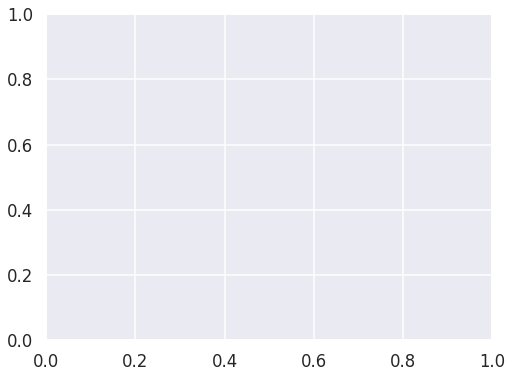

In [264]:
# fig, ax = plt.subplots(1, 1, figsize = (8, 6))

# ax.plot(fbeta_piv['Thresh'], fbeta_piv[0.5], color = "skyblue")
# ax.plot(fbeta_piv['Thresh'], fbeta_piv[1], color = 'navy')
# ax.plot(fbeta_piv['Thresh'], fbeta_piv[1.25], color = 'cornflowerblue')
# ax.plot(fbeta_piv['Thresh'], fbeta_piv[1.5], color = 'royalblue')
# #ax.plot(fbeta_piv['Thresh'], fbeta_piv[2], color = 'blue')
# ax.legend(['Beta = 0.5', 'Beta = 1', 'Beta = 1.25', 'Beta = 1.5', 'Beta = 2'], fontsize = 13)
# ax.tick_params(labelsize = 13)
# ax.set_xlabel('Threshold', fontsize = 15)
# ax.set_ylabel('F Beta Score', fontsize = 15)
# ax.set_title('F Beta Score Analysis by Threshold', fontsize = 17)
# plt.show()

In [263]:
Xtr, Xte, Ytr, Yte = train_test_split(X, Y, test_size=0.33, random_state=0)
#w = {1:(len(Ytr)-sum(Ytr)), 0:sum(Ytr)}
clf = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=0, multi_class='ovr'
                         ).fit(Xtr, Ytr)
Yhat = clf.predict_proba(Xte)

Ypred = (Yhat[:,1] > 0.15).astype(int)

print(classification_report(Yte.to_numpy(), Ypred))

              precision    recall  f1-score   support

           0       0.94      0.83      0.88       570
           1       0.23      0.47      0.31        59

    accuracy                           0.80       629
   macro avg       0.58      0.65      0.59       629
weighted avg       0.87      0.80      0.83       629



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [266]:
# sum((Yte.to_numpy()) == Ypred)/len(Ypred)

TypeError: 'int' object is not callable

In [267]:
# ## Representation of Confusion Matrix:
# [TN, FP]
# [FN, TP]
# ([[416, 158], thresh = 0.1
#     [ 23,  33]])
Ypred = (Yhat[:,1] > 0.15).astype(int)
confusion_matrix(Yte.to_numpy(), Ypred)

array([[474,  96],
       [ 31,  28]])

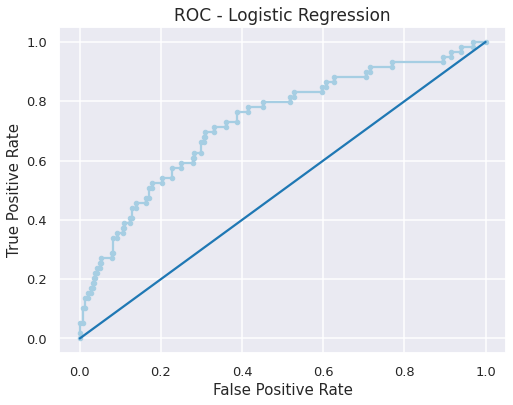

In [268]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))
fpr, tpr, thresholds = metrics.roc_curve(Yte.to_numpy(), Yhat[:, 1])
x = np.linspace(0,1,100)
ax.plot(fpr, tpr, marker='.')
ax.plot(x, x)
ax.set_xlabel('False Positive Rate', fontsize = 15)
ax.set_ylabel('True Positive Rate', fontsize = 15)
ax.tick_params(labelsize = 13)
ax.set_title('ROC - Logistic Regression', fontsize = 17)
plt.show()

In [269]:
metrics.auc(fpr, tpr)

0.7290217068093963

In [270]:
X[['follow_up_period', 'avg_days_bw_records', 'dispensed_count', 'avg_days_supply', 'age']].corr()

,follow_up_period,avg_days_bw_records,dispensed_count,avg_days_supply,age
follow_up_period,1.000000,0.493421,0.631454,0.066825,-0.156626
avg_days_bw_records,0.493421,1.000000,-0.068269,-0.025619,-0.091721
dispensed_count,0.631454,-0.068269,1.000000,-0.059255,-0.144170
avg_days_supply,0.066825,-0.025619,-0.059255,1.000000,0.032588
age,-0.156626,-0.091721,-0.144170,0.032588,1.000000


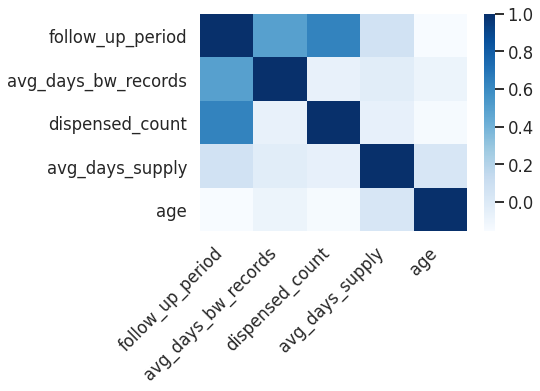

In [271]:
chart = sns.heatmap(X[['follow_up_period', 'avg_days_bw_records', 'dispensed_count', 'avg_days_supply', 'age']].corr(), 
            annot=False, cmap = "Blues")
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [272]:
# import statsmodels.api as sm

# model = sm.Logit(Ytr, Xtr)
# result = model.fit(method='newton', maxiter=10000)
# result.predict(Xte)

/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: inf
         Iterations: 10000


/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:1863: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


LinAlgError: Singular matrix

In [ ]:
# result.summary2()

In [ ]:
# X.dtypes

### Cross-Valid

In [273]:
Xtr, Xte, Ytr, Yte = train_test_split(X, Y, test_size=0.33, random_state=0)
#w = {1:(len(Ytr)-sum(Ytr)), 0:sum(Ytr)}
clf = LogisticRegression(penalty='l1',solver='liblinear', max_iter=10000, random_state=0, multi_class='ovr'
                         )

scores = cross_val_score(clf, X, Y, scoring="roc_auc", cv=10)

In [274]:
scores.mean()

0.746626129306755

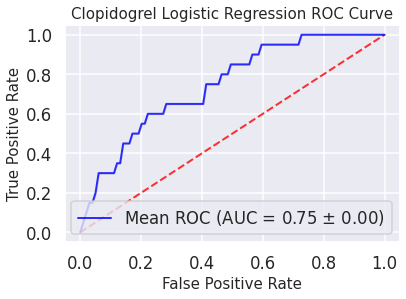

In [278]:
clf = LogisticRegression(penalty='l1',solver='liblinear', max_iter=10000, random_state=0, multi_class='ovr')

cv = StratifiedKFold(n_splits=10)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, Y)):
    clf.fit(X.loc[train], Y.loc[train])
    #viz = plot_roc_curve(clf, X.loc[test], Y.loc[test], alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2)
ax.legend(loc="lower right")
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
ax.set_xlabel('False Positive Rate', size=15)
ax.set_ylabel('True Positive Rate', size=15)
ax.set_title("Clopidogrel Logistic Regression ROC Curve", size=15)
plt.show()

## Random Forest

In [279]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=0)

In [281]:
regressor = RandomForestClassifier(n_estimators=20, random_state=1)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

regressor.fit(X_train, y_train)

# class_weight = dict({0:0.52, 1:4.27})
rdf = RandomForestClassifier(bootstrap=True,
            class_weight='balanced_subsample', 
            criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=500,
            oob_score=False,
            random_state=175,
            verbose=0, warm_start=False)
rdf.fit(X_train, y_train)
y_pred = rdf.predict_proba(X_test)

In [282]:
# [TN, FP]
# [FN, TP]



print(confusion_matrix(y_test,y_pred[:, 1] > .325))

[[334  99]
 [ 19  25]]


In [283]:
scores = cross_val_score(rdf, X, Y, cv=10, scoring = 'roc_auc')
scores.mean()

0.7601213948183151

In [284]:
# y_test["ADE_Classification"]
y_test_df = pd.DataFrame(y_test)
y_test_df.shape

(477, 1)

In [285]:
y_pred.shape

(477, 2)

In [286]:
print(accuracy_score(y_test,y_pred[:, 1] > .4))

0.8197064989517819


In [287]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred[:, 1]>0.325)


metrics.auc(fpr, tpr)

0.6697722023934495

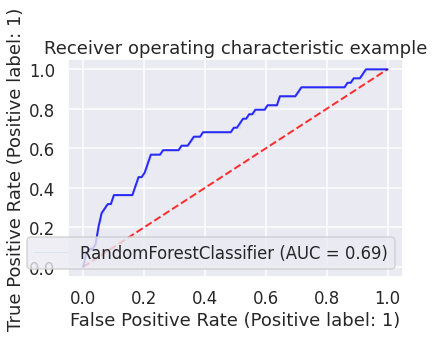

In [288]:
tprs = []
aucs = []

mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()

viz = plot_roc_curve(rdf, X_test, y_test,
                     alpha=0.3, lw=1, ax=ax)
interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
interp_tpr[0] = 0.0
tprs.append(interp_tpr)
aucs.append(viz.roc_auc)



ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b', lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2)

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()

In [289]:
X1 = X.reset_index(drop=True)

In [290]:
Y1 = pd.DataFrame(Y)
Y1.reset_index(drop = True)

,ADE_Classification
0,0
1,0
2,0
3,0
4,0
...,...
1901,0
1902,0
1903,0
1904,0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was pas

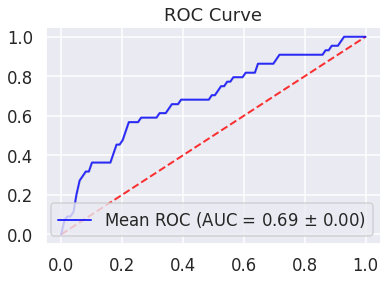

In [291]:
cv = StratifiedKFold(n_splits=10)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X1, Y1)):
    rdf.fit(X1.loc[train], Y1.loc[train])
#     viz = plot_roc_curve(rdf, X1.loc[test], Y1.loc[test],
                        
#                          alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2)
ax.legend(loc="lower right")
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC Curve")
plt.show()

In [292]:
np.mean(aucs)

0.6895863951291205

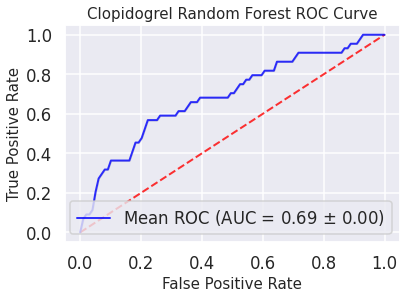

In [293]:
rdf = RandomForestClassifier(bootstrap=True,
            class_weight='balanced_subsample', 
            criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=500,
            oob_score=False,
            random_state=175,
            verbose=0, warm_start=False)

cv = StratifiedKFold(n_splits=10)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, Y)):
    rdf.fit(X.loc[train], Y.loc[train])
    #viz = plot_roc_curve(rdf, X1.loc[test], Y1.loc[test],alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2)
ax.legend(loc="lower right")
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
ax.set_xlabel("False Positive Rate", size = 15)
ax.set_ylabel("True Positive Rate", size = 15)
ax.set_title("Clopidogrel Random Forest ROC Curve", size=15)
plt.show()

## Noiseless Log Reg

In [294]:
# follow up period, sex at birth, overal health general quality 

In [295]:
X_noiseless = X[['follow_up_period', 'sex_at_birth_Male', 'sex_at_birth_Female', 'Overall Health: General Quality']]

In [296]:
clf = LogisticRegression(penalty='l1', solver='liblinear', max_iter=100, random_state=0, multi_class='ovr')

scores = cross_val_score(clf, X_noiseless, Y, scoring="roc_auc", cv=10)

In [297]:
scores.mean()

0.7448595857548928